In [1]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject, CUDA, DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject.LaminartKernels, MEngProject.LaminartInitFunc, MEngProject.Utils, BenchmarkTools, Test

using OrdinaryDiffEq, ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1


files = readdir(datadir("img"))

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260


25-element Array{String,1}:
 ".ipynb_checkpoints"
 "Iine_gap_1_100_gs.png"
 "Iine_gap_2_100_gs.png"
 "Iine_gap_3_100_gs.png"
 "Iine_gap_4_100_gs.png"
 "Iines_gaps_100_gs.png"
 "diag_dots_100_gs.png"
 "diag_gap_100_gs.png"
 "kan_sq_cont.png"
 "kan_sq_cont_l.png"
 "mo05709.png"
 "stairs_100gs.png"
 "stairs_200gs.png"
 "viper00187.png"
 "viper00661.jpg"
 "viper00715.png"
 "viper00717.png"
 "viper00720.png"
 "viper00721.png"
 "viper00842.jpg"
 "viper00891.jpg"
 "viper00904.jpg"
 "viper00921.jpg"
 "viper01006.jpg"
 "viper01333.jpg"

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260


UndefVarError: UndefVarError: prob not defined

In [ ]:
y1Res_cpu

In [3]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1


files = readdir(datadir("res_test"))[2:end]

global benchm_gpu = []
global benchm_cpu = []
global y1Res_gpu = []
global y1Res_cpu = []

# @inbounds begin
    tspan = (0.0f0, 10f0)

    batch_ = string(batch, "_", rand(1000:9999))
    mkdir(plotsdir(string("bench_dim", batch_)))


    test_name = ["025", "050", "075", "100", "200", "300", "400"]
    test_name_plt = [
        "\$25×25\$",
        "\$50×50\$",
        "\$75×75\$",
        "\$100×100\$",
        "\$200×200\$",
        "\$300×300\$",
        "\$400×400\$",
    ]


    for file in enumerate(files[1:1])

        p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("res_test", file[2]),
            Parameters.parameters_f32,
        )

        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(u0[:, :, 1:2, :])
        arr2 = similar(u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  Q_temp,
            similar(arr1), #   P_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
        push!(benchm_gpu, @benchmark solve(prob))
        sol = solve(prob)


        t = 10
        v0 = @view sol(t)[:, :, :, 1]
        axMax = findmax(v0)[1]


        k = 7
		k2 = 8
        fig, ax = plt.subplots()

        v1 = @view sol(t)[:, :, k, 1]
        v2 = @view sol(t)[:, :, k+1, 1]
        im = ax.imshow(
            v1,
            cmap = matplotlib.cm.PRGn,
            vmax = axMax,
            vmin = -axMax,
        )
        im2 = ax.imshow(
            v2,
            cmap = matplotlib.cm.RdBu_r,
            vmax = axMax,
            vmin = -axMax,
            alpha = 0.5,
        )

        cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
        cbar.ax.set_xlabel("\$k=$k2\$")
        cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
        cbar.ax.set_xlabel("\$k=$k\$")
        layer = Utils.layers[k]
        plt.title(string(
            "Layer: $layer, \$t=$t\$, resolution=",
            test_name_plt[file[1]],
        ))
        plt.axis("off")
        fig.tight_layout()
        plt.savefig(plotsdir(
            string("bench_dim", batch_),
            string(
                file[2],
                "_res_",
                test_name[file[1]],
                "_t",
                t,
                "_",
                Utils.la[k],
                ".png",
            ),
        ))
        close("all")

		v3 = @view sol[:,:,7:7,:,:]
		push!(y1Res, Array(v3))
		u0 = nothing
		p = nothing
		arr1 = nothing
		arr2 = nothing
		f = nothing
		prob = nothing
		sol = nothing


		p = LaminartInitFunc.parameterInit_conv_cpu(
            datadir("res_test", file[2]),
            Parameters.parameters_f32,
        )

        u0 = reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        )

        arr1 = similar(u0[:, :, 1:2, :])
        arr2 = similar(u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  Q_temp,
            similar(arr1), #   P_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
        push!(benchm_cpu, @benchmark solve(prob))
        sol = solve(prob)

		push!(y1Res_cpu, sol[:,:,7:7,:,:])
		u0 = nothing
		p = nothing
		arr1 = nothing
		arr2 = nothing
		f = nothing
		prob = nothing
		sol = nothing
	end

    # time plot
    fig, axs = plt.subplots()

    for result ∈ enumerate(y1Res_gpu)
		lab = "$test_name[result[1]]"
        axs.plot(result[2][findmax(result[2][:, :, 1, 1, end])[2][1], findmax(result[2][:, :, 1, 1, end])[2][2], k, 1, :], c = Utils.Colour[result[1]], "--", label = "$lab GPU")
    end

	for result ∈ enumerate(y1Res_cpu)
		lab = "$test_name[result[1]]"
		axs.plot(result[2][findmax(result[2][:, :, 1, 1, end])[2][1], findmax(result[2][:, :, 1, 1, end])[2][2], k, 1, :], c = Utils.Colour[result[1]],":", label = "$lab CPU")
	end
    axs.set_xlabel("Time")
    axs.set_ylabel("Activation")
    plt.title("L2/3, \$k=1\$")
    plt.legend()
    fig.tight_layout()
    plt.savefig(plotsdir(
        string("bench_dim", batch_),
        string(file[2], "_para_", test_name[file[1]], "_time.png"),
    ))
    close("all")



    # benchmark plot

    fig, ax = plt.subplots()
    for bm ∈ enumerate(benchm_gpu)
        ax.scatter(
		median(bm[2].times) * 1e-9,
		test_name_plt[bm[1]],
            label = "GPU",
			color=Utils.colours[1],
            alpha = 0.3,
            edgecolors = "none",
        )
    end

	for bm ∈ enumerate(benchm_cpu)
		ax.scatter(
            median(bm[2].times) * 1e-9,
			test_name_plt[bm[1]],
			label = "CPU",
			alpha = 0.3,
			color=Utils.colours[2],
			edgecolors = "none",
		)
	end

    ax.legend()
	axs.set_xlabel("Resolution (\$px\$)")
    axs.set_ylabel("Time (\$s\$)")
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(plotsdir(
        string("bench_dim", batch_),
        string(file[2], "_para_", test_name[file[1]], "_time.png"),
    ))
    close("all")

	# memory
	fig, ax = plt.subplots()
    for bm ∈ enumerate(benchm_gpu)
        ax.scatter(
            bm[2].memory * 1e-6,
            test_name_plt[bm[1]],
			olor=Utils.colours[1],
            label = "GPU",
            alpha = 0.3,
            edgecolors = "none",
        )
    end

    ax.legend()
	axs.set_xlabel("Resolution (\$px\$)")
    axs.set_ylabel("Memory")
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(plotsdir(
        string("bench_dim", batch_),
        string(file[2], "_para_", test_name[file[1]], "_time.png"),
    ))
    close("all")
end
# end



UndefVarError: UndefVarError: prob not defined

In [4]:
readdir(datadir("res_test"))

8-element Array{String,1}:
 ".ipynb_checkpoints"
 "ver_lines_025_gs.png"
 "ver_lines_050_gs.png"
 "ver_lines_075_gs.png"
 "ver_lines_100_gs.png"
 "ver_lines_200_gs.png"
 "ver_lines_300_gs.png"
 "ver_lines_400_gs.png"

In [ ]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1


# files = readdir(datadir("img"))
files = ["kan_sq_cont_l.png", "stairs_200gs.png"]

tspan = (0.0f0, 800f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("noise", batch_)))
# for file in files[1:end]
    for noise in [0.2f0, 0.4f0, 0.7f0, 1f0, 1.5f0, 2f0]
        try
            p = LaminartInitFunc.parameterInit_conv_gpu_noise(
                datadir("img", file),
                Parameters.parameters_f32,
                noise,
            )

            u0 = cu(reshape(
                zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
                p.dim_i,
                p.dim_j,
                5 * p.K + 2,
                1,
            ))

            arr1 = similar(u0[:, :, 1:2, :])
            arr2 = similar(u0[:, :, 1:1, :])

            f = LaminartFunc.LamFunction(
                arr1, #x
                similar(arr1), #m
                similar(arr1), #s
                arr2, #x_lgn,
                similar(arr1), #C,
                similar(arr1), #H_z,
                similar(arr1), # dy_temp,
                similar(arr1), # dm_temp,
                similar(arr1), # dz_temp,
                similar(arr1), # ds_temp,
                similar(arr2), # dv_temp,
                similar(arr1), # H_z_temp,
                similar(arr2), #  V_temp_1,
                similar(arr2), #  V_temp_2,
                similar(arr1), #  Q_temp,
                similar(arr1), #   P_temp
            )

            prob = ODEProblem(f, u0, tspan, p)
            # 	@benchmark sol = solve(prob)
            sol = solve(prob)


            for t ∈ [25, 50, 100, 200, 400, 800]
                # 				for t ∈ [25,50,100]
                @inbounds begin
                    v0 = @view sol(t)[:, :, :, 1]
                    axMax = findmax(v0)[1]

                    for k ∈ 1:2:10
                        k2 = k + 1
                        fig, ax = plt.subplots()

                        v1 = @view sol(t)[:, :, k, 1]
                        v2 = @view sol(t)[:, :, k+1, 1]
                        im = ax.imshow(
                            v1,
                            cmap = matplotlib.cm.PRGn,
                            vmax = axMax,
                            vmin = -axMax,
                        )
                        im2 = ax.imshow(
                            v2,
                            cmap = matplotlib.cm.RdBu_r,
                            vmax = axMax,
                            vmin = -axMax,
                            alpha = 0.5,
                        )

                        cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
                        cbar.ax.set_xlabel("\$k=$k2\$")
                        cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
                        cbar.ax.set_xlabel("\$k=$k\$")
                        layer = Utils.layers[k]
                        plt.title("Layer: $layer, \$t=$t\$, noise\$σ=$noise\$")
                        plt.axis("off")
                        fig.tight_layout()
                        plt.savefig(plotsdir(
                            string("noise", batch_),
                            string(
                                file,
                                "_noise_",
                                noise,
                                "_t",
                                t,
                                "_",
                                Utils.la[k],
                                ".png",
                            ),
                        ))
                        close("all")
                    end


                    k = 11
                    fig, ax = plt.subplots()
                    v1 = @view sol[:, :, k, 1, t]
                    v2 = @view sol[:, :, k+1, 1, t]
                    im = ax.imshow(
                        v1,
                        cmap = matplotlib.cm.PRGn,
                        vmax = axMax,
                        vmin = -axMax,
                    )
                    im2 = ax.imshow(
                        v2,
                        cmap = matplotlib.cm.RdBu_r,
                        vmax = axMax,
                        vmin = -axMax,
                        alpha = 0.5,
                    )

                    cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
                    cbar.ax.set_xlabel("\$v^-\$")
                    cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
                    cbar.ax.set_xlabel("\$v^+\$")

                    layer = Utils.layers[k]
                    plt.title("Layer: $layer, \$t=$t\$, noise\$σ=$noise\$")
                    plt.axis("off")
                    fig.tight_layout()

                    plt.savefig(plotsdir(
                        string("noise", batch_),
                        string(
                            file,
                            "_noise_",
                            noise,
                            "_t",
                            t,
                            "_",
                            Utils.la[k],
                            ".png",
                        ),
                    ))
                    close("all")
                end
            end
        finally
            nothing
        end


        # time plot
        fig, axs = plt.subplots()

        for k ∈ 1:12
            v3 = @view sol[:, :, k, 1, end]
            v4 = @view sol[findmax(v3)[2][1], findmax(v3)[2][2], k, 1, :]
            layer = Utils.layers_1[k]
            axs.plot(v4, Utils.lines[k], label = "$layer")
        end
        axs.set_xlabel("Time")
        axs.set_ylabel("Activation")
        plt.title("Noise \$σ=$noise\$")
        plt.legend()
        fig.tight_layout()
        plt.savefig(plotsdir(
            string("noise", batch_),
            string(file, "_noise_", noise, "_time.png"),
        ))
        u0 = nothing
        p = nothing
        arr1 = nothing
        arr2 = nothing
        f = nothing
        prob = nothing
        sol = nothing
        close("all")
    end
end


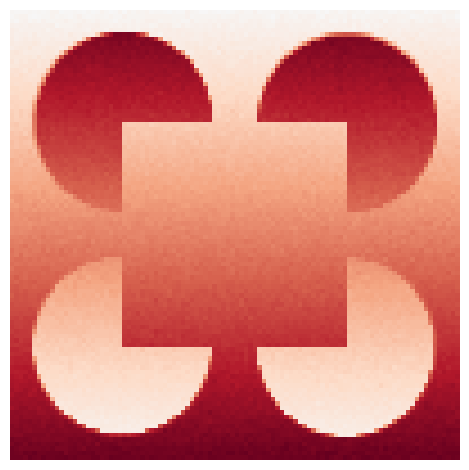

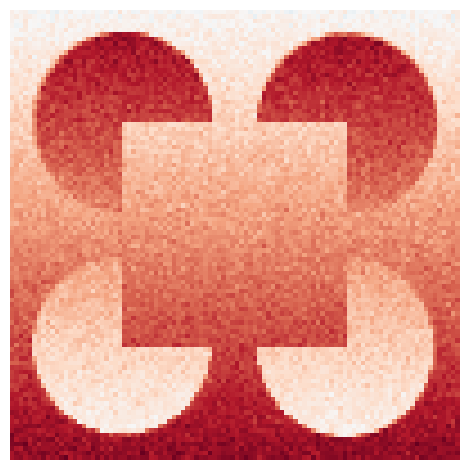

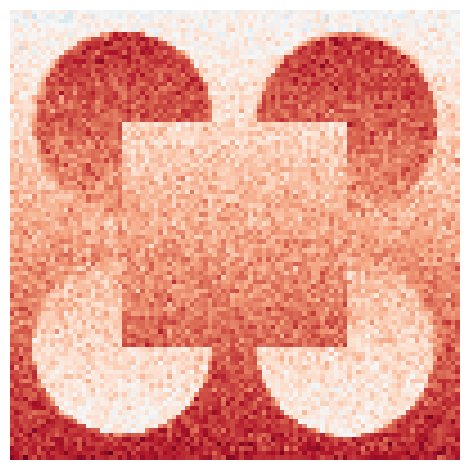

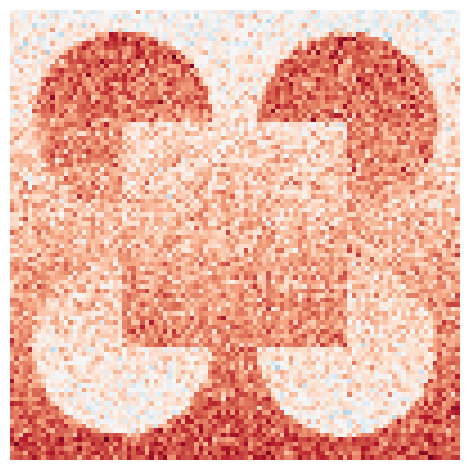

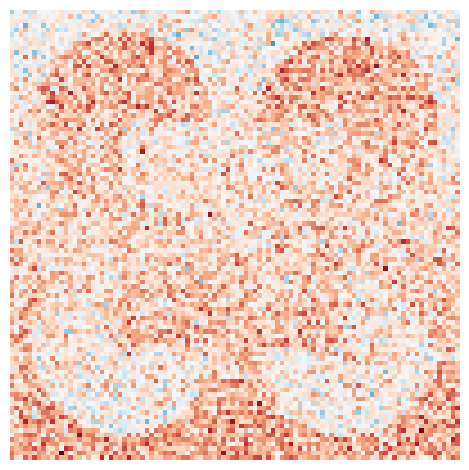

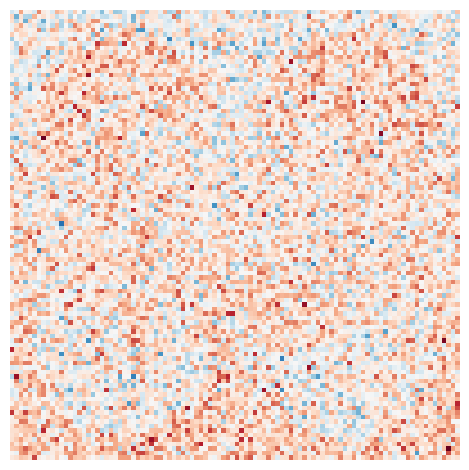

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/LaminartInitFunc.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /mnt/storage_1/users/cullinanen/.julia/packages/Revise/BqeJF/src/Revise.jl:820
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/LaminartInitFunc.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /mnt/storage_1/users/cullinanen/.julia/packages/Revise/BqeJF/src/Revise.jl:820


In [27]:
files = ["kan_sq_cont_l.png", "stairs_200gs.png"]

# tspan = (0.0f0, 800f0)

# batch_ = string(batch, "_", rand(1000:9999))
# mkdir(plotsdir(string("noise", batch_)))
# for file in files[1:end]
for noise ∈ [0.01f0, 0.05f0, 0.1f0, 0.2f0, 0.5f0, 1f0]

            p = LaminartInitFunc.parameterInit_conv_gpu_noise(
                datadir("img", files[1]),
                Parameters.parameters_f32,
                noise,
            );
Utils.plot_rb(p.I[:,:,1,1],axMax=findmax(p.I)[1], axMin=-findmax(p.I)[1])
end

In [23]:
axMax=findmin(p.I)[1]

0.011764706f0

In [15]:
findmax(p.I)[1]

1.5959865f0

In [35]:
p = LaminartInitFunc.parameterInit_conv_gpu_noise(
                datadir("img",files[1]),
                Parameters.parameters_f32,
                noise,
            )

(K = 2, δ_v = 1.25f0, δ_c = 0.25f0, δ_m = 0.01875f0, δ_z = 0.125f0, δ_s = 2.5f0, σ_1 = 1.0f0, C_1 = 1.5f0, C_2 = 0.075f0, σ_2 = 0.5f0, γ = 10.0f0, α = 0.5f0, ϕ = 2.0f0, Γ = 0.2f0, v_21 = 0.0f0, μ = 2.0f0, ν = 1.1f0, n = 6.0f0, att = 0.0f0, η_p = 2.1f0, η_m = 1.5f0, λ = 1.5f0, a_23_ex = 3.0f0, a_23_in = 0.5f0, v12_6 = 1.0f0, v12_4 = 5.0f0, ψ = 0.5f0, C_AB_l = 5, H_σ_x = 3.0f0, H_σ_y = 0.8f0, H_fact = 13.0f0, H_l = 19, T_fact = Float32[0.87, 0.13], T_p_m = 0.302f0, T_v2_fact = 0.625f0, H_size = 19, W_size = 19, W_p_σ_x_same_a = 6.0f0, W_p_σ_x_same_b = 3.0f0, W_p_σ_y_same_a = 2.0f0, W_p_σ_y_same_b = 4.0f0, W_p_σ_opp_a = 4.0f0, W_p_σ_x_opp_b = 3.0f0, W_p_σ_x_opp_c = 1.2f0, W_p_σ_y_opp_b = 1.2f0, W_p_σ_y_opp_c = 3.0f0, W_p_same_fact = 39.0f0, W_p_opp_fact_a = 70.0f0, W_p_opp_fact_b = 50.0f0, W_m_σ_x_same_a = 6.0f0, W_m_σ_x_same_b = 3.0f0, W_m_σ_y_same_a = 2.5f0, W_m_σ_y_same_b = 4.0f0, W_m_σ_opp_a = 4.0f0, W_m_σ_x_opp_b = 3.0f0, W_m_σ_x_opp_c = 1.2f0, W_m_σ_y_opp_b = 1.2f0, W_m_σ_y_opp_c = 

In [31]:
noise =0.2f0

0.2f0

In [ ]:
noise =     img = convert(Array{Float32,2},  load(datadir("img",files[1])));
	img = mult_gauss(img,noise)
Utils.plot_gs(img)

In [ ]:
for file in ["kan_sq_cont_l.png", "stairs_200gs.png"]
    for noise in[0.01f0, 0.05f0, 0.1f0, 2f0, 0.5f0, 1f0]
        fig, ax = plt.subplots()
                        im = ax.imshow(
                            v1,
                            cmap = matplotlib.cm.gray,
                            vmax = 0,
                            vmin = 1,
                        )
                        cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
#                         cbar.ax.set_xlabel("\$k=$k2\$")
#                         cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
#                         cbar.ax.set_xlabel("\$k=$k\$")
#                         layer = Utils.layers[k]
                        plt.title("Input image, noise \$σ=$noise\$")
                        plt.axis("off")
                        fig.tight_layout()
                        plt.savefig(plotsdir(
                            string("noise", batch_),
                            string(
                                file,
                                "_input_noise_",
                                noise,
                                ".png",
                            ),
                        ))
                        close("all")
    end
end

In [36]:
# using DrWatson
# @quickactivate "MEngProject"
# using MEngProject, 
# # CUDA, 
# DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject.LaminartKernels, MEngProject.LaminartInitFunc, MEngProject.Utils, BenchmarkTools, Test

# using OrdinaryDiffEq, ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1



global benches = []

tspan = (0.0f0,10f0)

batch_ = string(batch,"_",rand(1000:9999))
mkdir(plotsdir(string("bench_imp",batch_)))
file = "kan_sq_cont_l.png"

test_name_plt = ["CPU conv", "GPU conv",  "CPU imfilter", "GPU imfilter FFT", "GPU imfilter FIR", "GPU imfilter IIR"]

# GPU
p = LaminartInitFunc.parameterInit_conv_gpu(datadir("img",file), Parameters.parameters_f32);

u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1))

arr1 = similar(u0[:, :, 1:2,:])
arr2 = similar(u0[:, :, 1:1,:])

f = LaminartFunc.LamFunction(
	arr1, #x
	similar(arr1), #m
	similar(arr1), #s
	arr2, #x_lgn,
	similar(arr1), #C,
	similar(arr1), #H_z,
	similar(arr1), # dy_temp,
	similar(arr1), # dm_temp,
	similar(arr1), # dz_temp,
	similar(arr1), # ds_temp,
	similar(arr2), # dv_temp,
	similar(arr1), # H_z_temp,
	similar(arr2), #  V_temp_1,
	similar(arr2), #  V_temp_2,
	similar(arr1), #  Q_temp,
	similar(arr1), #   P_temp
)
prob = ODEProblem(f, u0, tspan, p)
bm = @benchmark solve(prob)
push!(benches, bm)



# # CPU conv

# p = LaminartInitFunc.parameterInit_conv_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1)


# f = LaminartFunc.LamFunction(
# 	arr1, #x
# 	similar(arr1), #m
# 	similar(arr1), #s
# 	arr2, #x_lgn,
# 	similar(arr1), #C,
# 	similar(arr1), #H_z,
# 	similar(arr1), # dy_temp,
# 	similar(arr1), # dm_temp,
# 	similar(arr1), # dz_temp,
# 	similar(arr1), # ds_temp,
# 	similar(arr2), # dv_temp,
# 	similar(arr1), # H_z_temp,
# 	similar(arr2), #  V_temp_1,
# 	similar(arr2), #  V_temp_2,
# 	similar(arr1), #  Q_temp,
# 	similar(arr1), #   P_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)


# # CPU imfilter

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)

# arr1 = similar(u0[:, :, 1:2])
# arr2 = similar(u0[:, :, 1:1])

# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)



# # GPU imfilter FFT

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)


# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)



# # GPU imfilter IIR

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)


# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)



# # GPU imfilter FIR

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)



# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)

In [38]:

push!(benches, bm)

2-element Array{Any,1}:
 Trial(527.254 ms)
 Trial(527.254 ms)

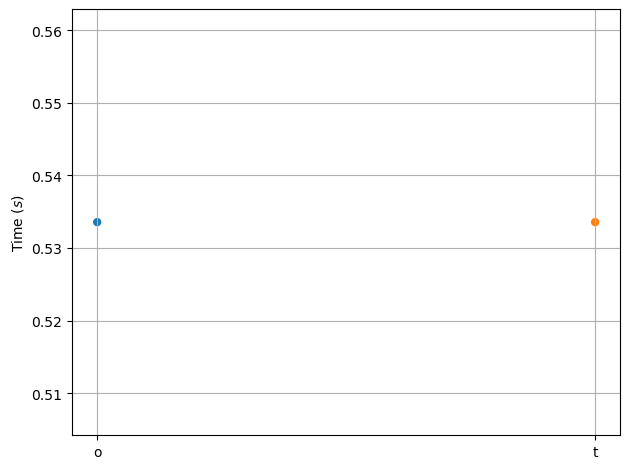

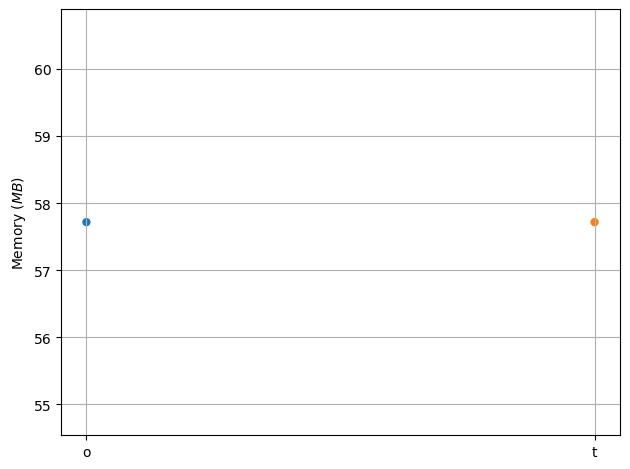

In [48]:
# benchmark plot
test_name_plt = ["o","t"]
# time
fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
            ben[2],
        median(benches[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
#         alpha = 0.3,
        edgecolors = "none",
    )
end


# ax.legend()
ax.set_ylabel("Time (\$s\$)")
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_imp", batch_),
    string("bench_imp_time.png"),
))
# close("all")




# memory

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benches[ben[1]].memory * 1e-6,
        color = Utils.colours[ben[1]],
#         alpha = 0.3,
        edgecolors = "none",
    )
end


# ax.legend()
ax.set_ylabel("Memory (\$MB\$)")
ax.grid(true)
fig.tight_layout()
# plt.savefig(plotsdir(
#     string("bench_imp", batch_),
#     string("bench_imp_mem.png"),
# ))
# close("all")


# alloc

# fig, ax = plt.subplots()
# for ben in enumerate(test_name_plt)
#     ax.scatter(
#         ben[2],
#         benches[ben[1]].allocs * 1e-6,
#         color = Utils.colours[ben[1]],
# #         alpha = 0.3,
#         edgecolors = "none",
#     )
# end


# # ax.legend()
# ax.set_ylabel("Allocations")
# ax.grid(true)
# fig.tight_layout()
# plt.savefig(plotsdir(
#     string("bench_imp", batch_),
#     string("bench_imp_alloc.png"),
# ))
# # close("all")

In [5]:

file = ["kan_sq_cont_l.png"]
        p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("img",file[1]),
            Parameters.parameters_f32,
        )
tspan = (0.0f0,10f0)
        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(u0[:, :, 1:2, :])
        arr2 = similar(u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  Q_temp,
            similar(arr1), #   P_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
#         push!(benchm_gpu, @benchmark solve(prob))
        sol = solve(prob);

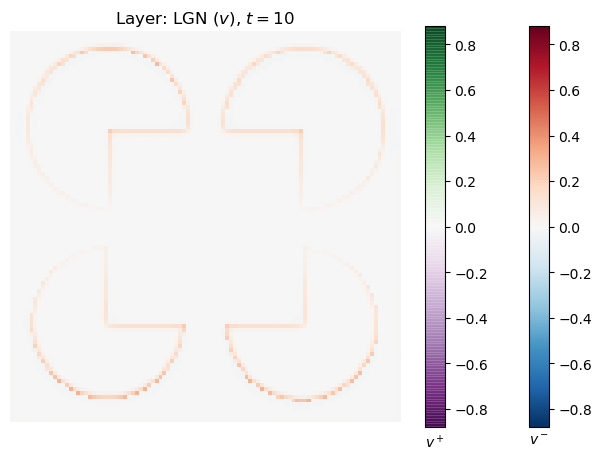

In [7]:
plot(sol)

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays /mnt/storage_1/users/cullinanen/.julia/packages/GPUArrays/eVYIC/src/host/indexing.jl:43


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /mnt/storage_1/users/cullinanen/.julia/packages/PyCall/zqDXB/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('x and y can be no greater than 2-D, but have shapes (100,) and (100, 100, 12, 1, 37)')
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2763, in plot
    is not None else {}), **kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 1647, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 216, in __call__
    yield from self._plot_args(this, kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_base.py", line 345, in _plot_args
    raise ValueError(f"x and y can be no greater than 2-D, but have "


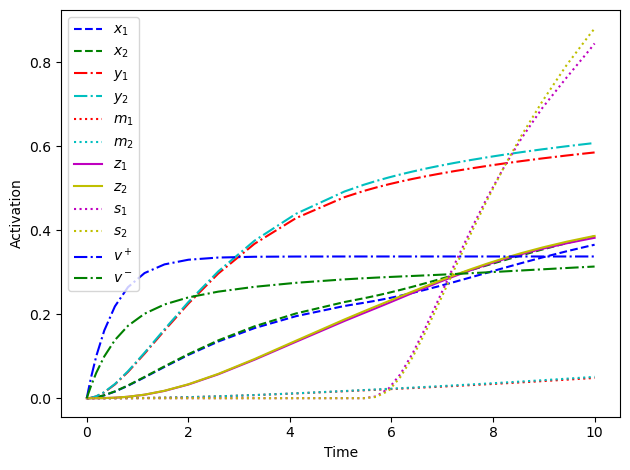

In [12]:
fig, axs = plt.subplots()

        for k ∈ 1:12
            v3 = @view sol[:, :, k, 1, end]
            v4 = @view sol[findmax(v3)[2][1], findmax(v3)[2][2], k, 1, :]
            v5 = sol.t
            layer = Utils.layers_1[k]
            axs.plot(v5,v4, Utils.lines[k], label = "$layer")
        end
        axs.set_xlabel("Time")
        axs.set_ylabel("Activation")
        plt.legend()
        fig.tight_layout()
#         plt.savefig(plotsdir(
#             string("illusions", batch_),
#             string(file, "_time.png"),
#         ))

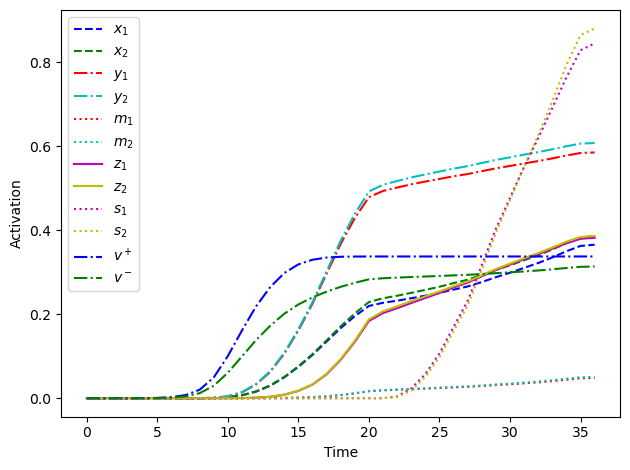

In [13]:
fig, axs = plt.subplots()

        for k ∈ 1:12
            v3 = @view sol[:, :, k, 1, end]
            v4 = @view sol[findmax(v3)[2][1], findmax(v3)[2][2], k, 1, :]
#             v5 = sol
            layer = Utils.layers_1[k]
            axs.plot(v4, Utils.lines[k], label = "$layer")
        end
        axs.set_xlabel("Time")
        axs.set_ylabel("Activation")
        plt.legend()
        fig.tight_layout()
#         plt.savefig(plotsdir(
#             string("illusions", batch_),
#             string(file, "_time.png"),
#         ))

In [14]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


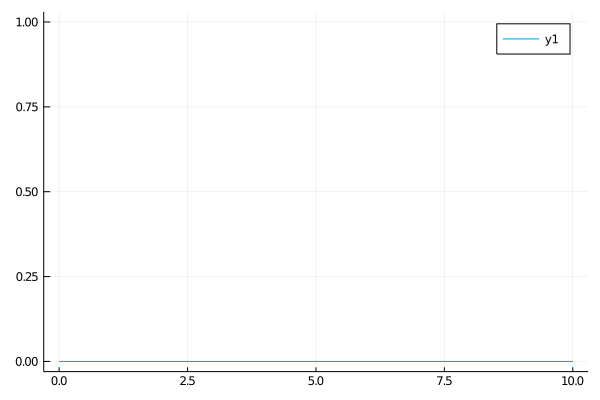

In [22]:
Plots.plot(sol.t,sol[1,1,1,1,:])

In [25]:
@benchmark begin
    t=10
    v0 = @view sol(t)[:,:,:,1]
					axMax = findmax(v0)[1]
					k=7
t=10
					fig, ax = plt.subplots()
					v1 = @view sol(t)[:,:,k,1]
					v2 = @view sol(t)[:,:,k+1,1]
					im = ax.imshow(sol.t, v1,
								   vmax=axMax, vmin=-axMax)



end

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /mnt/storage_1/users/cullinanen/.julia/packages/PyCall/zqDXB/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("[[0.0, -3.118341702526695e-38, 0.0017700216267257929, -2.159253468254833e-27, -1.1932356752938614e-22, 0.001857573282904923, 1.4204611943569034e-05, 1.5144481534720006e-14, 1.7153797479685373e-11, 4.068465564444068e-09, 2.0225320440658834e-07, 2.1075234144518618e-06, 0.000976700335741043, 2.1075227323308354e-06, 2.0225002117513213e-07, 1.4504300452244934e-05, 0.0007499487255699933, 0.00177988619543612, 0.003043352160602808, 0.003335589310154319, -5.412689046968566e-11, -7.333594842506841e-11, -9.411483398169551e-11, -1.1334997523926305e-10, -1.2714188035722884e-10, -1.321566328593704e-10, -1.2704344520830801e-10, -1.1305625186031065e-10, 0.0011551666539162397, 0.0006263611721806228, 0.0027914042584598064, 0.0002347408008063212, 0.00044239862472750247, -1.3825885965615403e-12, 3.1712781289883196e-09, 1.580755792929267e-07, 0.0006545282085426152, 3.59787941306422e-06, 1.6472312154292013e-06, 1.5808012676643557e-07, 3.1798650379499804e-09, 1.3401351209307855e-11, 0.001949749537743628, -5.421902149537548e-18, -5.73810589735878e-19, -3.4450696739414897e-22, 0.0023402690421789885, -1.0875060024193963e-27, -1.580907475070517e-33, 0.0, 0.0, 0.0, -3.0292930231071907e-33, -1.7386852574040756e-27, -7.423508653177569e-23, -4.874125408758203e-22, -9.148948447081507e-19, 2.244171653861143e-15, 2.5510511671850145e-12, 6.050204226504263e-10, 3.0077291768293435e-08, 3.1341258477368683e-07, 6.845556299595046e-07, 3.134117037006945e-07, 3.007495763540646e-08, 6.006121711088497e-10, -5.0283050292976306e-12, -1.1982829659085148e-11, -1.7548431457958813e-11, -2.3896700590553266e-11, 0.0017664727056398988, 1.1817630962696057e-07, 0.0007916929898783565, -4.4920907271706056e-11, -4.6688469063083105e-11, 0.0001916464534588158, 0.002738064620643854, 0.0001485265529481694, -3.638322976229347e-11, 0.001519592828117311, -2.3722737316211884e-11, 0.001300908625125885, -1.181600477184741e-11, -3.908634266941435e-12, 8.34206315136754e-10, 4.1682579166035794e-08, 4.343650346072536e-07, 9.487426382293052e-07, 4.3436608621050254e-07, 4.1684824481080796e-08, 8.385162564295001e-10, 3.5355997643482517e-12, 3.114742799686693e-15, -6.538396419161357e-19, -4.865330556298075e-22, -7.676338573300903e-23, -1.6916224629110514e-27, -3.0724994199976178e-33, 0.0, 0.0], [0.0, -1.2499241551908593e-32, 0.0023938335943967104, 1.5074455371661218e-22, 7.640391867008336e-18, 5.783732054485263e-14, 6.556814119429433e-11, 1.569328844652773e-08, 8.132283824124897e-07, 0.0012307274155318737, 3.972671038354747e-05, 6.0744678194168955e-05, 3.4257678635185584e-05, 7.510736395488493e-06, 5.584331006502907e-07, 4.458251545713665e-09, 0.0018201802158728242, 0.007304008584469557, 0.0036234105937182903, -2.6200194014336375e-08, -3.180746688258296e-08, -3.686520955170636e-08, -4.116457219538461e-08, -4.4549540945126864e-08, -4.683046839204508e-08, -4.7775028377827766e-08, -4.719728963209491e-08, -4.5045759122785967e-08, -4.141626774867291e-08, -3.653478231058216e-08, -3.073919430107708e-08, -2.4493584049878336e-08, -1.8332272588850174e-08, 0.002035068115219474, 0.003140948247164488, 0.0020173725206404924, 0.0018455579411238432, 8.363983397430275e-06, 6.932725227670744e-06, 3.0569910450140014e-05, 6.481716263806447e-05, 2.9561295377789065e-05, 0.002577282255515456, 5.701345173747541e-08, 2.4038593338104874e-10, 2.1245170607562397e-13, 0.0032059941440820694, 1.3948581475697265e-21, 1.1514774603405694e-26, 2.122726359687706e-32, 0.0, -2.826727566222923e-34, -1.775488623083349e-27, -2.1360654422539516e-22, -1.91197504635712e-18, 4.1898075798518635e-19, 6.505212357286669e-14, 8.173000470845793e-11, 1.9401880990699283e-08, 9.657400141804828e-07, 1.0124333130079322e-05, 2.2750238713342696e-05, 1.1806726433860604e-05, 1.7688000752968946e-06, 9.405953704799686e-08, 0.003723794361576438, 0.007707077078521252, 0.010769657790660858, 0.0024792549666017294, -2.7054024798189857e-08, -3.44514958783293e-08, -4.1295734831692243e-08, -4.690835453402542e-08, -5.083085241608387e-08, -5.282949544493931e-08, -5.281894743802695e-08, -5.079445841715824e-08, -4.683501231284026e-08, -4.1175869824883193e-08, -3.428565165108921e-08, 0.0005642625037580729, 0.0011140265269204974, 0.006634133402258158, 0.006633944343775511, -2.6440458711363135e-09, 1.2782766134478152e-07, 2.2711908513883827e-06, 1.4479745914286468e-05, 2.741578828135971e-05, 1.2147872439527418e-05, 1.1576732958928915e-06, 2.325324288676711e-08, 9.796298494624267e-11, 7.993426206316309e-14, 2.93770506211217e-18, -1.9769684882417897e-18, -2.0782400446350789e-22, -1.800796883296553e-27, -2.9746389642786854e-34, 0.0], [3.657511293522795e-32, 1.9191469731974996e-26, 0.006571537349373102, 6.099264554007523e-17, 3.496074957309858e-13, 0.0002661290636751801, 0.0008403521496802568, 0.0005480085383169353, 6.17437981418334e-05, 0.00022852672555018216, 0.0003523985214997083, 0.0002508862526156008, 0.0067482744343578815, 0.0018560998141765594, 0.007390366867184639, -1.4306443745226716e-06, -2.3038660401653033e-06, -3.3318428904749453e-06, -4.41361817138386e-06, -5.383258667279733e-06, -6.091038812883198e-06, -6.458268217102159e-06, -6.520127044495894e-06, -6.407311502698576e-06, -6.284820301516447e-06, -6.27349982096348e-06, -6.395947821147274e-06, -6.566921001649462e-06, -6.629582912864862e-06, -6.4276209741365165e-06, -5.876587692910107e-06, -5.005935236113146e-06, -3.9404098970408086e-06, -2.8493066110968357e-06, -1.8697747918849927e-06, 0.012742005288600922, 0.0014214105904102325, 0.005860225763171911, 9.80612458079122e-05, 0.00034036842407658696, 0.0012258511269465089, 0.00023188121849671006, 0.006379867438226938, 2.4235764612967614e-06, 4.3288448381417766e-08, 1.7767477766827966e-10, 0.005931331310421228, 2.545872004769577e-17, 1.0081446478784546e-21, 9.132148891305913e-27, 5.133021190033701e-32, 2.0787110394619598e-26, 2.356020410878429e-21, 6.078921204894639e-17, 3.4754501793826664e-13, 4.052082280825431e-10, 9.650044319187145e-08, 4.8906081246968824e-06, 5.5621512728976086e-05, 0.00017192529048770666, 0.0002085790183627978, 0.00012383123976178467, 3.568224929040298e-05, 0.006391208618879318, 0.005788202863186598, 0.008121281862258911, -2.0546560790535295e-06, -3.2393484161730157e-06, -4.732555680675432e-06, -6.434131591959158e-06, -8.185444130504038e-06, -9.80483218882e-06, -1.1132261533930432e-05, -1.2059692380717024e-05, -1.2532145774457604e-05, -1.2529585546872113e-05, -1.2050879377056845e-05, -1.1114574590465054e-05, -9.776011211215518e-06, -8.14564737083856e-06, -6.386829227267299e-06, -4.6833724809403066e-06, -3.194252713001333e-06, 0.001368256751447916, 0.01232412550598383, 0.010568039491772652, 0.0030767591670155525, 4.249401899869554e-05, 0.00013696363021153957, 0.00021641977946273983, 0.00017359394405502826, 5.5727490689605474e-05, 4.8909801080299076e-06, 9.64702024930375e-08, 4.0504402609720103e-10, 3.470433846981119e-13, 6.090994733115463e-17, 2.3518156434140815e-21, 2.076953820980701e-26, 3.5734076114573374e-32], [1.185447166774067e-26, 1.3986176188302947e-21, 0.006825573276728392, 1.6583052476776966e-13, 2.116974234800395e-10, 5.600527330784644e-08, 3.124237764495774e-06, 0.005491376388818026, 0.00031360622961074114, 0.0008500631083734334, 0.0021066784393042326, 0.0006505197961814702, 0.0012501322198659182, 1.4876376553729642e-05, -4.1585131839383394e-05, -7.543665560660884e-05, -0.0001175591314677149, -0.00016742045409046113, -0.0002183460892410949, -0.00026155574596486986, -0.00028936032322235405, -0.0002981238649226725, -0.000290610158117488, -0.00027508707717061043, -0.0002619021979626268, -0.0002588492352515459, -0.00026773367426358163, -0.0002835861232597381, -0.0002967898326460272, -0.00029740590252913535, -0.00027945154579356313, -0.00024337352078873664, -0.00019512650032993406, -0.0001434416917618364, -9.644612873671576e-05, -5.792095180368051e-05, -1.8549782907939516e-05, 3.346845551277511e-05, 0.006165654398500919, 0.0012192303547635674, 0.0033142040483653545, 0.0008256792207248509, 0.0061496710404753685, 0.0011965458979830146, 2.514040886580915e-07, 0.00120895158033818, 0.009612824767827988, -1.8287536198910437e-14, 0.0020250806119292974, 1.008661613673195e-24, 1.7551865481303877e-26, 0.0016001766780391335, 0.0007828564266674221, 0.0034606880508363247, 0.0026048331055790186, 8.218651714742009e-08, 4.439843451109482e-06, 6.406397005775943e-05, 0.000339045247528702, 0.0007377763977274299, 0.0019732434302568436, 0.0003414108941797167, 0.009750970639288425, 0.003944934345781803, -3.403542723390274e-05, -6.303685950115323e-05, -0.00010612366168061271, -0.0001653318468015641, -0.00023932107433211058, -0.00032305443892255425, -0.00040875686681829393, -0.00048765496467240155, -0.0005521129933185875, -0.00059703947044909, -0.000619887316133827, -0.0006197479669936001, -0.0005965653108432889, -0.0005511761992238462, -0.0004861455818172544, -0.0004066860710736364, -0.0003206002584192902, -0.000236769876210019, -0.0001629886101000011, -0.00010420807666378096, -6.163819489302114e-05, -3.296022259746678e-05, -4.2617371036612894e-06, 0.006086660549044609, 0.011183771304786205, 0.0007273390656337142, 0.0007454321603290737, 0.0003413295780774206, 6.46725675323978e-05, 0.004600281361490488, 0.0018893121741712093, 3.327871311853414e-10, 2.7484828649115833e-13, 5.053256619126042e-17, 2.161777360028559e-21, 1.7770064099539218e-26], [7.451024752640402e-23, 1.6127748232075285e-18, 0.005558086559176445, -2.906995477669483e-11, -6.397773422150976e-10, 0.0005596239934675395, 0.0005277608288452029, 0.005410308483988047, 0.0013321673031896353, 0.002243003575131297, 0.002503716852515936, 0.0013507555704563856, 0.0002583289169706404, -0.0002697897725738585, -0.0005907267332077026, -0.0009527165675535798, -0.001406551105901599, -0.0019157023634761572, -0.0024083051830530167, 0.07056073099374771, 0.07849735021591187, 0.08098148554563522, -0.00292715965770185, -0.0027313323225826025, -0.002573832403868437, -0.0025357729755342007, -0.0026365213561803102, -0.0028249777387827635, -0.0030018428806215525, 0.08443897217512131, 0.07738183438777924, 0.06363958865404129, -0.002179358620196581, -0.0016670399345457554, -0.0011760605266317725, -0.0007630494073964655, -0.00043507295777089894, -0.00015887861081864685, 0.006974727381020784, 0.005901262164115906, 0.0034720832481980324, 0.0022033972200006247, 0.006528124213218689, 0.0006013477686792612, 0.0027317602653056383, 0.00044665741734206676, 0.00408898713067174, 3.152689168928191e-05, 0.0025969771668314934, 2.0767722332368395e-21, 4.874041095304653e-22, 1.2034730968553417e-17, 0.0011749555123969913, 0.00366342905908823, 0.0013989288127049804, 0.0009406121098436415, 2.9113316486473195e-05, 0.00027458395925350487, 0.0016955879982560873, 0.004703163169324398, 0.0035836489405483007, 0.000715341477189213, 0.0008521510171703994, -0.0002451753243803978, -0.0004823568742722273, -0.0008193974499590695, -0.0012958329170942307, -0.0019159968942403793, -0.002655769931152463, -0.0034594943281263113, 0.013880550861358643, 0.02064419351518154, -0.005125634837895632, -0.005542461294680834, -0.005585629492998123, -0.006054883357137442, -0.005269994959235191, -0.003879112657159567, 0.01618245616555214, 0.009710500948131084, -0.0033345059491693974, -0.0026250637602061033, -0.0018873701337724924, -0.001271961024031043, -0.0008015631465241313, -0.0004700582940131426, -0.00023282687470782548, 0.002784325508400798, 0.010143395513296127, 0.0017559151165187359, 0.002019589301198721, 0.0011069831671193242, 0.00028044567443430424, 0.0014924855204299092, 0.0032326187938451767, 1.8929380729559853e-08, 0.001510991365648806, 4.531342003553408e-14, 1.3503804563628207e-17, 5.454948168489819e-22], [1.917280461637e-21, -3.039032718460058e-16, 0.003713295329362154, -9.746146112377119e-09, 0.001993048470467329, 0.00284415646456182, 7.754336547804996e-05, 0.0017592118820175529, 0.0024956411216408014, 0.004879959858953953, 0.004962339531630278, 0.0021725641563534737, -0.00036102344165556133, -0.0017725586658343673, -0.002841125475242734, 0.0013611114118248224, 0.029094824567437172, -0.006231871899217367, 0.08902793377637863, -0.007570420391857624, -0.007637225557118654, -0.007310924120247364, -0.00672282837331295, -0.006084386259317398, -0.0056270514614880085, -0.005518710240721703, -0.005799040663987398, -0.006362131331115961, -0.00699956901371479, 0.03526990860700607, -0.007617185357958078, -0.00733728613704443, 0.07316942512989044, -0.005667513702064753, 0.08425728976726532, -0.0033594206906855106, -0.0022911278065294027, -0.0013264173176139593, 0.00028241731342859566, 0.004035397432744503, 0.007081659976392984, 0.004896293859928846, 0.0016467676032334566, 0.0004655338416341692, 0.007614787667989731, -3.5963066125077603e-07, 0.000739139097277075, -5.100269095947851e-09, 0.0006321974797174335, 9.769143590331905e-21, 4.184740646235579e-21, 3.826065949397162e-06, -3.3782136810156516e-11, 0.0019111132714897394, 0.00011565801833057776, 7.832032679289114e-06, 0.00013421248877421021, 0.0008690017857588828, 0.004377559293061495, 0.007783202454447746, 0.006215354893356562, 0.0010476770112290978, -0.000605562177952379, -0.0015610860427841544, -0.0024884678423404694, -0.003624328412115574, -0.004953290335834026, -0.00639820983633399, 0.11321663856506348, 0.017191514372825623, 0.09553731977939606, -0.011487494222819805, -0.012243998236954212, -0.012739816680550575, -0.012980165891349316, -0.01297086849808693, -0.01271098479628563, -0.012193653732538223, -0.011414662934839725, 0.0928850844502449, 0.010951374657452106, 0.11566505581140518, -0.006294749211519957, -0.004864993505179882, -0.00355579424649477, -0.002439498668536544, -0.0015210345154628158, -0.0005303327925503254, 0.0011833488242700696, 0.003530548419803381, 0.004461612552404404, 0.006354344543069601, 0.0016122863162308931, 0.00013871050032321364, 0.004061495419591665, -1.336949839725321e-08, 0.007097559981048107, 2.7619448061955154e-08, -2.8655219896819547e-15, 4.378576367179316e-21], [8.590651939926791e-21, -8.439221679335321e-14, 0.0026775163132697344, -5.277297532302327e-07, 0.0009514931007288396, -2.3736604362056823e-06, 0.0002119510609190911, 0.0036471181083470583, 0.005180025473237038, 0.009206636808812618, 0.008504768833518028, 0.002648453926667571, -0.0023026790004223585, -0.00491225766018033, 0.010798227973282337, 0.11937092244625092, 0.09708138555288315, 0.014273402281105518, -0.00892900861799717, -0.00819347519427538, -0.007113175466656685, -0.005887897219508886, -0.004722703713923693, -0.0037949541583657265, -0.00323299178853631, -0.003106183372437954, -0.003428390482440591, -0.004156576469540596, -0.00519239716231823, -0.006381687708199024, -0.007533391937613487, -0.0084465853869915, -0.0002443538105580956, -0.004373983945697546, 0.1514374017715454, 0.11114569008350372, -0.005759730469435453, -0.004065748304128647, -0.0008451446192339063, 0.006445851176977158, 0.012623406015336514, 0.009408699348568916, 0.0035749399103224277, 0.000812726968433708, 0.005160345230251551, 0.00044453726150095463, -1.8036668052445748e-06, -2.756366654921294e-07, 0.00328975822776556, 5.258789678919129e-05, 0.0011557155521586537, 0.0007261601858772337, 0.0012054572580382228, 0.0014427221613004804, -2.638261548781884e-06, 1.801717735361308e-05, 0.0013491500867530704, 0.0021105094347149134, 0.005786961875855923, 0.008448686450719833, 0.0058618648909032345, 0.0008196597918868065, -0.0025995424948632717, -0.004538408946245909, -0.006098490674048662, 0.124795101583004, -0.0015587887028232217, 0.03109421767294407, -0.009985243901610374, -0.009873487986624241, 0.015888195484876633, -0.008836410008370876, -0.008242008276283741, -0.007777223829180002, -0.007519402541220188, -0.007501435000449419, -0.007723828312009573, -0.0081556411460042, -0.008722611702978611, 0.013630404137074947, -0.009736469946801662, -0.009855594485998154, 0.03421473130583763, -0.0006756953080184758, 0.12457006424665451, -0.005792199168354273, -0.004499495029449463, -0.0024935014080256224, 0.001038787537254393, 0.006049020681530237, 0.00854547880589962, 0.0103065874427557, 0.002147604478523135, 0.00039410212775692344, 0.0029541957192122936, -2.687815367607982e-06, 0.004645409528166056, -8.298790099559028e-09, -3.3567547613050364e-12, 3.17844026296409e-18], [1.8127391808858684e-17, 0.0008629450458101928, -3.847366656373197e-07, -6.964561180211604e-06, 0.001689876546151936, -4.356088538770564e-05, 0.0036833665799349546, 0.003236472839489579, 0.009617798030376434, 0.0157236959785223, 0.01340426690876484, 0.003152431920170784, -0.004571417812258005, 0.08444210886955261, 0.11311670392751694, 0.16881638765335083, -0.009318382479250431, -0.00839837547391653, -0.007021129131317139, -0.005442783236503601, -0.003915002103894949, -0.0026225904002785683, -0.001655090949498117, -0.001019494142383337, -0.0006819834234192967, -0.0006086015491746366, -0.0007908219704404473, -0.0012481878511607647, -0.0020145121961832047, -0.0031131254509091377, -0.004505513701587915, -0.006063486915081739, -0.007572158705443144, -0.00877344235777855, 0.008503284305334091, 0.17410516738891602, 0.06851160526275635, 0.12478369474411011, -0.0023469903971999884, 0.009563532657921314, 0.020335813984274864, 0.018365519121289253, 0.011614270508289337, 0.0015278515638783574, 7.124435069272295e-05, 0.0049962131306529045, 0.0020640850998461246, 0.003094553481787443, -2.1225808666258672e-07, 0.002654459560289979, 0.0007117666536942124, 0.002748077269643545, 0.0005109274643473327, -6.004941951687215e-06, -2.2940645067137666e-05, 3.1725929147796705e-05, 0.004347620066255331, 0.004368012771010399, 0.010774941183626652, 0.014507289044559002, 0.009119807742536068, 0.00018344356794841588, -0.005222179461270571, 0.05373582988977432, 0.09707526862621307, 0.1637757271528244, -0.009533022530376911, -0.008902397006750107, -0.007773062214255333, -0.006359650753438473, -0.004897670354694128, -0.003587499028071761, -0.0025572057347744703, -0.0018634237349033356, -0.001516082906164229, -0.0015094903064891696, -0.001844844315201044, -0.002530933590605855, -0.003560092067345977, -0.004877409432083368, -0.006354155484586954, -0.007786845322698355, -0.008935471996665001, -0.00958105269819498, 0.16373886168003082, 0.10519734770059586, 0.047880444675683975, -0.005124167539179325, 0.00048221336328424513, 0.009405123069882393, 0.01466987282037735, 0.012886879034340382, 0.004434467293322086, 0.0009088529623113573, 0.0006778518436476588, -2.3141434212448075e-05, 0.004258009139448404, 0.0007611630717292428, -8.049698130285776e-10, 5.692477642833135e-17], [6.504468785806239e-08, 6.775065912734135e-07, -2.8514994028228102e-06, 0.0034686464350670576, 0.003653084160760045, 0.0022422801703214645, 0.004735162481665611, 0.006349280942231417, 0.016794122755527496, 0.025250105187296867, 0.020517447963356972, 0.005139493849128485, 0.0928523913025856, 0.18758803606033325, 0.08745516836643219, 0.01790689118206501, -0.007031893357634544, -0.00555761530995369, -0.004028613213449717, -0.0026744031347334385, -0.0016253835055977106, -0.0009039838914759457, -0.000456618465250358, -0.00020907736325170845, -9.441729343961924e-05, -6.97205905453302e-05, -0.0001275232498301193, -0.0002900437975768, -0.0006080832681618631, -0.0011579828569665551, -0.0020107817836105824, -0.0031977673061192036, -0.004657663404941559, -0.006218357942998409, -0.007622919045388699, 0.13516710698604584, 0.029800081625580788, 0.20693065226078033, -0.0023491044994443655, 0.014434878714382648, 0.03067673183977604, 0.02625362016260624, 0.017169056460261345, 0.0031832403037697077, 0.002135750139132142, 0.002353561343625188, -7.283906597876921e-05, 0.0014697294682264328, -2.25833127842634e-06, 0.0006316449726000428, 0.0015892565716058016, -3.936550996286314e-08, -5.0098105930374e-06, 0.0011820202926173806, -8.438785880571231e-05, 0.004516055341809988, 0.002889004535973072, 0.008383729495108128, 0.018592126667499542, 0.023230936378240585, 0.013969817198812962, 0.0004944051615893841, 0.1157953143119812, 0.16565491259098053, 0.16151854395866394, -0.007070400286465883, -0.007379586808383465, -0.005959543865174055, -0.0044355024583637714, -0.0030402308329939842, -0.0019205223070457578, -0.001120265107601881, -0.0006050602532923222, -0.00031202597892843187, -0.00018243244267068803, -0.00018314957560505718, -0.00031492701964452863, -0.0006126079242676497, -0.001136047183535993, -0.00194918445777148, -0.003085991134867072, -0.004500687122344971, -0.006043361034244299, -0.007477821782231331, -0.008537746965885162, 0.15709426999092102, 0.16267646849155426, 0.11198944598436356, 0.0008770195418037474, 0.01436741091310978, 0.023474272340536118, 0.018760519102215767, 0.008459564298391342, 0.001990954391658306, 0.0029181872960180044, 0.0028766109608113766, 0.0020638126879930496, 0.0006128319073468447, 1.8893551896326244e-05, 1.8171425608670688e-06], [2.6094246550201206e-06, 2.717863753787242e-05, 4.6566077799070626e-05, 0.0043759397231042385, 0.00585642084479332, 0.003241817932575941, 0.003104135626927018, 0.01208491250872612, 0.027744019404053688, 0.038167331367731094, 0.09722811728715897, 0.08502622693777084, 0.21326710283756256, -0.005783318541944027, -0.0056711952202022076, -0.0047975871711969376, -0.0036899030674248934, -0.002585780806839466, -0.0016495335148647428, -0.0009578275494277477, -0.0005066458834335208, -0.00024001949350349605, -9.695490007288754e-05, -3.232829476473853e-05, -9.447527190786786e-06, -4.476897174754413e-06, -1.5235546925396193e-05, -5.006086576031521e-05, -0.00013960807700641453, -0.000328491092659533, -0.0006642594817094505, -0.0012182475766167045, -0.002035314217209816, -0.0030956713017076254, -0.004287783522158861, 0.010661420412361622, -0.006178585812449455, 0.031093111261725426, 0.14636310935020447, 0.02390125021338463, 0.1754845529794693, 0.039963249117136, 0.021802552044391632, 0.007018420845270157, 0.004806571640074253, -0.0001953363389475271, -0.00012782384874299169, -4.241315764375031e-05, 0.0016409090021625161, 0.0009494447149336338, 0.0034040543250739574, -4.740981864870264e-07, 0.001761935418471694, -7.145258132368326e-05, -0.0001399705361109227, 0.007002170663326979, 0.006155218929052353, 0.01522028911858797, 0.030123518779873848, 0.03500453382730484, 0.021081382408738136, 0.06529754400253296, 0.2044498175382614, -0.006733409594744444, 0.008287698030471802, -0.005361223127692938, -0.004150844644755125, -0.0029361555352807045, -0.0018959544831886888, -0.0011177201522514224, -0.00060206901980564, -0.00029135451768524945, -0.00012318562949076295, -4.437167808646336e-05, -1.6673417121637613e-05, -1.694331513135694e-05, -4.5478234824258834e-05, -0.00012634441372938454, -0.000298570201266557, -0.00061650644056499, -0.0011439027730375528, -0.001939299050718546, -0.003001586999744177, -0.0042409347370266914, -0.005474548786878586, 0.001975604798644781, -0.0068439398892223835, 0.20534299314022064, 0.07192736119031906, 0.02157634124159813, 0.03532314673066139, 0.03035123459994793, 0.015350415371358395, 0.004428123123943806, 0.0003909472725354135, 0.0025065287481993437, 3.579292751965113e-05, 0.00029353672289289534, 0.00010805045894812793, 1.041716768668266e-05], [1.238696222571889e-05, 0.0001289412466576323, 0.0019275523955002427, 0.003262988291680813, 0.0028343640733510256, 0.0008349506533704698, 0.006196493748575449, 0.021058838814496994, 0.04194329306483269, 0.1813884973526001, 0.23337669670581818, 0.256046861410141, 0.0005774807068519294, -0.0023671381641179323, -0.002326538786292076, -0.0018088484648615122, -0.0012614334700629115, -0.0007955111796036363, -0.0004539351211860776, -0.00023460207739844918, -0.00010992168972734362, -4.223380528856069e-05, -1.1815021025540773e-05, -2.2082135728851426e-06, 0.0007752346573397517, -1.1256698684292132e-07, -8.956544661486987e-07, -4.12015742767835e-06, -3.873679816024378e-06, -6.807516183471307e-05, -0.0001586789876455441, -0.00032955053029581904, -0.0006196854519657791, -0.0010533513268455863, -0.0016167931025847793, -0.0022361453156918287, -0.002745920792222023, -0.0024377740919589996, 0.12690123915672302, 0.20520439743995667, 0.2739734351634979, 0.10956808179616928, 0.034046340733766556, 0.01288695354014635, 0.0025589929427951574, 9.398531256010756e-05, 0.0023847646079957485, 0.0006925953202880919, -3.540729267115239e-06, 6.751855476626323e-13, 0.0031567453406751156, 0.002704335143789649, -2.437082184769679e-05, -7.3684670496732e-05, -4.149952656007372e-05, 0.007949909195303917, 0.008698460645973682, 0.025668762624263763, 0.04499194025993347, 0.19589389860630035, 0.17149899899959564, 0.2346142679452896, -0.00224376586265862, -0.003557613119482994, -0.0031072499696165323, -0.002382301725447178, -0.0016530489083379507, -0.0010391295654699206, -0.0005920587573200464, -0.0003061325114686042, -0.00014330592239275575, -5.444780981633812e-05, -1.6038715330068953e-05, -3.4017998586932663e-06, -8.46586090119672e-07, 0.00249819946475327, -3.519949132169131e-06, -1.663072544033639e-05, -5.646253703162074e-05, -0.00014811515575274825, -0.0003161223139613867, -0.0006108477828092873, -0.0010710291098803282, -0.0017018781509250402, -0.0024496898986399174, -0.0031899826135486364, -0.0036245002411305904, -0.0021182552445679903, 0.23857860267162323, 0.17540286481380463, 0.19384486973285675, 0.04530763998627663, 0.025849472731351852, 0.010531616397202015, 0.00349386571906507, 0.005158587358891964, 0.00027359515661373734, 0.000737972732167691, 0.0003475663543213159, 3.3526950574014336e-05], [3.80899800802581e-05, 0.002928367117419839, 0.0008610028889961541, 0.011705522425472736, 0.000878605991601944, 0.002058006590232253, 0.011283760890364647, 0.03234751150012016, 0.14809460937976837, 0.30350229144096375, 0.34345388412475586, 0.17958605289459229, 0.002725146943703294, -0.0002859364030882716, -0.0004980951780453324, -0.00037486289511434734, -0.0002454702334944159, 0.006284358911216259, 0.00036226442898623645, -3.673620813060552e-05, -1.5754545529489405e-05, 0.0024731564335525036, -6.492052193607378e-07, -4.095317507335494e-08, 0.003506267676129937, -1.1054416271250034e-09, 0.0011770209530368447, 0.00021898899285588413, -1.1389053042876185e-06, 0.0003920234157703817, 0.0012176589807495475, 0.0008356428006663918, 0.0004195893707219511, -0.00021264623501338065, -0.0003446019836701453, -0.0004980607191100717, -0.0006071258685551584, -2.2841964891995303e-05, 0.007711972575634718, 0.32324087619781494, 0.3546503186225891, 0.2635175585746765, 0.04835154116153717, 0.02138628251850605, 0.005359872244298458, 0.0006093811825849116, 0.004494058433920145, 0.002843800699338317, 1.5814195648999885e-05, 2.068923157794167e-12, 0.0009354505455121398, 0.0006966378423385322, 0.0013324690517038107, -2.166558988392353e-05, 0.0021850888151675463, 0.011735637672245502, 0.015432147309184074, 0.03887376934289932, 0.17192307114601135, 0.30106252431869507, 0.3106917440891266, 0.05518271028995514, 0.0005001050303690135, -0.0009585742955096066, -0.0008510074112564325, -0.0006106621585786343, -0.0003934426058549434, -0.00022859782620798796, 0.005738436244428158, -5.6706317991483957e-05, -2.346681139897555e-05, 0.000577262369915843, 0.0007677033427171409, 0.0012478202115744352, -1.4300479911355524e-08, 0.0004801884642802179, -1.0911156778092845e-07, 0.0012181627098470926, -6.782874152122531e-06, 0.006050804164260626, -5.8532859839033335e-05, -0.00012345181312412024, -0.00023390367277897894, -0.00040365682798437774, -0.0006251244922168553, -0.000868133851327002, -0.0009536361903883517, 0.0006905563059262931, 0.058107249438762665, 0.3121248781681061, 0.30106091499328613, 0.17303527891635895, 0.03907029330730438, 0.0153416832908988, 0.004010637290775776, 0.0041581494733691216, 0.01460721343755722, 0.0019296860555186868, 0.0008882228285074234, 8.551100472686812e-05], [9.478467836743221e-05, 0.0019036652520298958, 0.0039763059467077255, 0.038380492478609085, 0.0037602626252919436, 0.003828885965049267, 0.017917800694704056, 0.04439397156238556, 0.27405446767807007, 0.34475839138031006, 0.29652702808380127, 0.01766902208328247, 0.0029836890753358603, 0.0002339110942557454, -2.8987171390326694e-05, -3.0073253583395854e-05, 0.0007850059191696346, 0.008598714135587215, 0.0009326743893325329, 0.0010587319266051054, 0.003270086832344532, -2.407047361430159e-07, 0.001796404249034822, -1.6966984761612736e-10, 0.0004217716050334275, 0.004739340860396624, 0.0009603092330507934, -1.5948667941856343e-09, -2.0228942076983003e-08, 0.0031310368794947863, -1.8458127897247323e-06, 0.002238718792796135, 0.0025618677027523518, 0.0027032215148210526, 0.0018989568343386054, 0.0002191745734307915, -1.5853243894525804e-05, 0.0006239282083697617, 0.008065035566687584, 0.1740749180316925, 0.3477212190628052, 0.3279974162578583, 0.20136098563671112, 0.03129972890019417, 0.009198004379868507, 0.001315548550337553, 0.0065448107197880745, 0.0047344062477350235, 0.00167445233091712, 5.011265274273979e-12, -4.978045087256078e-09, 0.00041759415762498975, -2.3318086732615484e-06, 0.001541803707368672, 0.0029416123870760202, 0.00890363659709692, 0.023992067202925682, 0.06827139109373093, 0.2927682101726532, 0.3551556169986725, 0.27679339051246643, 0.011269849725067616, 0.001419427921064198, -2.554045568103902e-05, -9.273144678445533e-05, -6.471167580457404e-05, 0.005087542347609997, -2.1698780983570032e-05, 0.002335646888241172, 0.0005871399771422148, 0.004625983070582151, -3.6911620782120735e-07, 0.0013301761355251074, 0.002792859449982643, -5.796577454142415e-11, 0.004811708349734545, 0.0011445044074207544, 0.001220427337102592, 0.0011570332571864128, -1.6999837271214346e-06, 0.004434098023921251, 0.00016629783203825355, 0.0042997258715331554, 0.0015488192439079285, 0.0006191855645738542, -9.140759357251227e-05, -3.593010205804603e-06, 0.0016015435103327036, 0.01182632427662611, 0.2788095772266388, 0.3557986915111542, 0.29345691204071045, 0.0626399964094162, 0.02374849282205105, 0.005885271355509758, 0.006123540922999382, 0.05179361253976822, 0.004309412091970444, 0.0027183161582797766, 0.0001902189978864044], [0.00020713078265544027, 0.003280601929873228, 0.013880218379199505, 0.0992003008723259, 0.0047287242487072945, 0.0063431113958358765, 0.025902729481458664, 0.21397259831428528, 0.3339148759841919, 0.33239391446113586, 0.09232135862112045, 0.01534350961446762, 0.0024380781687796116, 0.00021121950703673065, 8.693090421729721e-06, -6.214348786670598e-07, 0.0024256440810859203, 0.003966673277318478, 0.006004777271300554, 0.0025722046848386526, 0.004708430729806423, -4.103775985697666e-09, -4.538684705845952e-11, -1.4940356081200729e-13, 0.0009739669039845467, 0.0030453086365014315, 0.000804178707767278, -5.8352719357890326e-12, -8.295970160832056e-11, 0.003643836360424757, -3.453098429417878e-08, 0.0004544264520518482, 0.004499951843172312, 0.0046144030056893826, 0.0038653030060231686, 0.004394156392663717, 2.3656215489609167e-05, 0.0005679548485204577, 0.0069697704166173935, 0.03064768947660923, 0.2419884204864502, 0.3627367615699768, 0.29105740785598755, 0.04188697785139084, 0.01443884614855051, 0.0024648529943078756, 0.0037320670671761036, 0.004874213598668575, 1.132734350761666e-08, 0.00038384427898563445, -2.2743502636757285e-09, -8.080486679773458e-08, 1.384487745781371e-06, 0.0035824549850076437, 0.004056218545883894, 0.010214632377028465, 0.033852532505989075, 0.23948073387145996, 0.3431954085826874, 0.3205832839012146, 0.048608601093292236, 0.010038599371910095, 0.0012854286469519138, 7.208269380498677e-05, -2.065208946078201e-06, 0.0002583895402494818, 0.00731700798496604, 0.0008478158852085471, 0.0027362576220184565, -1.557050950395933e-07, 0.0018217876786366105, -6.464919266591096e-09, 9.656991460360587e-05, -4.444789588470277e-12, -5.080280339746397e-14, 0.00388599606230855, 0.0011213853722438216, -7.227741322113346e-11, 0.004306337796151638, -3.171892970499357e-08, 0.005050796549767256, -3.619425967826828e-07, 0.005141176283359528, 0.00410144729539752, 0.010292290709912777, -1.2008861176582286e-06, 8.775338937994093e-05, 0.0014245007187128067, 0.010495287366211414, 0.05306399241089821, 0.32168760895729065, 0.3447732925415039, 0.24204209446907043, 0.03323419764637947, 0.009505174122750759, 0.00719425780698657, 0.11751262843608856, 0.02074052393436432, 0.004573711194097996, 0.0003802369465120137], [0.00040779137634672225, 0.007570500019937754, 0.041004061698913574, 0.11945238709449768, 0.0073777069337666035, 0.009668126702308655, 0.07093849033117294, 0.28152233362197876, 0.3545851707458496, 0.2566126585006714, 0.037677597254514694, 0.012003352865576744, 0.0017648250795900822, 0.004048924893140793, 6.1453743001038674e-06, 0.0013546128757297993, 0.003509944537654519, -2.1608945743878394e-09, 0.0046571227721869946, 0.0011402819072827697, 0.004061433020979166, 0.0008922244305722415, 0.0024580503813922405, -2.7656964106084017e-17, 0.0015506042400375009, -5.597720939699343e-19, -1.0571050591072473e-17, -4.9932388952733664e-15, 0.000161131945787929, 0.0003798476536758244, 0.0006829476333223283, 0.00035177276004105806, 7.601568358950317e-05, -1.2039275132380567e-09, 0.0006380939739756286, 0.006061436142772436, 1.5583149433950894e-05, 0.0004257960245013237, 0.005366018041968346, 0.024528231471776962, 0.05613825470209122, 0.32564979791641235, 0.34136584401130676, 0.19916532933712006, 0.02090880274772644, 0.004195185378193855, 0.0003069086233153939, 0.0005184932961128652, 2.4010004651131567e-08, 0.002552087651565671, -2.0655398225155608e-10, 1.1743710892631043e-08, 3.364447820786154e-06, 0.005832567811012268, 0.0050026290118694305, 0.015515584498643875, 0.10928138345479965, 0.311514288187027, 0.35912030935287476, 0.18085993826389313, 0.02978665940463543, 0.0079642990604043, 0.0009594556177034974, 5.3657098760595545e-05, 1.3687081263924483e-06, 0.0016243429854512215, 0.006489799357950687, 0.0014410598669201136, -5.079099807403509e-09, 0.0008438159129582345, 0.0011208279756829143, -2.642889379567137e-11, 0.0009302357793785632, 0.0009056035196408629, -9.395095890681362e-18, 0.0032715981360524893, 0.000849599193315953, 5.2615851018344983e-05, 0.001868587452918291, -1.3158928113821133e-10, 0.0032719059381633997, -4.599714831243773e-09, 0.001833429909311235, 0.004687124863266945, 0.009779585525393486, 0.0024593621492385864, 6.379224214470014e-05, 0.0010554649634286761, 0.00830463320016861, 0.030334284529089928, 0.17696736752986908, 0.35884758830070496, 0.31236541271209717, 0.11323238909244537, 0.014091757126152515, 0.010536308400332928, 0.12260132282972336, 0.05686918646097183, 0.007261156570166349, 0.0006914773839525878], [0.0007315405528061092, 0.013201694935560226, 0.08128120005130768, 0.12914080917835236, 0.008685290813446045, 0.013641327619552612, 0.18128332495689392, 0.32723096013069153, 0.30319562554359436, 0.055148281157016754, 0.02874412201344967, 0.00848342850804329, 0.0011534909717738628, 0.004509835038334131, 3.451865040915436e-06, 0.0024538044817745686, 0.002678657416254282, -6.286172537367518e-12, -2.8668389277092254e-12, -1.1403521356367907e-12, 0.0021117108408361673, -1.4613102191523598e-14, -7.36304565224482e-18, 0.002079165540635586, 0.002876399550586939, -2.16798761386237e-23, 0.0010983372339978814, 0.000803413160610944, -1.3486979709968878e-17, 0.0022970931604504585, 1.2458020819394733e-06, -2.9172356804524346e-13, 0.0028199597727507353, 0.0021187756210565567, 0.0024592289701104164, 3.8571479876736703e-07, 9.069261977856513e-06, 0.0002865166461560875, 0.003930817823857069, 0.017721347510814667, 0.04412848502397537, 0.2275310754776001, 0.34732040762901306, 0.2683641314506531, 0.08686936646699905, 0.006648107897490263, 0.0028458680026233196, 0.0033577019348740578, 4.185085700214586e-08, 0.0017896012868732214, 1.8820205810454738e-11, 0.0009076919523067772, 6.333618784992723e-06, 0.006518921349197626, 0.004528811667114496, 0.022002220153808594, 0.2202017605304718, 0.34869658946990967, 0.2939671277999878, 0.05114279314875603, 0.02272821217775345, 0.005693456158041954, 0.0006428784690797329, 3.33175303239841e-05, 8.34215825307183e-07, 0.000840973574668169, 0.003986635711044073, -5.3030125429787134e-11, 2.5263992938562296e-05, 0.0001711345394141972, 0.0012170459376648068, 0.00047252990771085024, 3.6934055970050395e-05, -6.974637515548987e-19, -3.647019580291007e-22, 0.007799976505339146, -7.606465984762663e-19, -1.1749785445502375e-17, -2.455807197952308e-14, 0.0024781508836895227, 0.0016807044157758355, 0.002005972433835268, -3.9458908362988154e-11, 0.0019197267247363925, 1.2295903850656487e-08, 0.0028162163216620684, 3.932284380425699e-05, 0.0007027431856840849, 0.005923245567828417, 0.02313270792365074, 0.05146528035402298, 0.2921617925167084, 0.34955736994743347, 0.2175847738981247, 0.019355298951268196, 0.011173458769917488, 0.13009949028491974, 0.1126193031668663, 0.016439149156212807, 0.0011532511562108994], [0.001204187050461769, 0.020939107984304428, 0.14259929955005646, 0.13583452999591827, 0.011341224424540997, 0.07143434882164001, 0.2476998269557953, 0.3426564633846283, 0.21872210502624512, 0.04241069406270981, 0.019888252019882202, 0.005415838211774826, 0.0006814734661020339, 0.0067636845633387566, 1.7374527487845626e-06, 2.624683403951167e-08, 1.0339148981408641e-10, 0.002732721157371998, -2.267383321231226e-15, -8.929501798084823e-16, 0.00011439470108598471, 0.00042602865141816437, 0.0007848449749872088, 0.005938244983553886, 0.0024600776378065348, 1.5166249340836657e-06, 0.002690586494281888, 2.267809350087191e-06, 0.0015518980799242854, -8.772942746297565e-18, -2.337727058307756e-17, 0.001482876599766314, 1.1738790752706223e-14, 1.34100673274129e-11, 0.003617746289819479, 1.7141067587544967e-07, 0.0011307555250823498, 0.00017320833285339177, 0.002298742299899459, 0.015064803883433342, 0.03160244971513748, 0.05608975142240524, 0.28263840079307556, 0.329149454832077, 0.14048555493354797, 0.009798246435821056, 0.003954790066927671, 0.0011479728855192661, 6.645640127089791e-08, 0.004781953990459442, 3.9865485912393694e-11, 4.520576979416546e-08, 1.0824757737282198e-05, 0.008842574432492256, 0.007074800319969654, 0.10564809292554855, 0.28885945677757263, 0.3288227319717407, 0.15396249294281006, 0.03897160664200783, 0.015684200450778008, 0.003669283352792263, 0.00038890662835910916, 0.0005881167016923428, 0.0008213670225813985, 0.003927304875105619, 0.0012758281081914902, -7.029237760435014e-14, -3.425048195363975e-14, -6.110488058195997e-15, -2.070569061712932e-17, 0.00186625134665519, -4.337957477407379e-22, 0.0019072882132604718, -2.9685954828764363e-27, 0.005423626862466335, -2.949426284598338e-23, -4.561573416964355e-22, 0.00019654538482427597, 0.004518226254731417, 0.0004843721108045429, 0.0033231754787266254, -1.731132056280449e-14, 2.1903456479122063e-11, 6.174188271756975e-09, 5.51391678982327e-07, 2.1820345864398405e-05, 0.00042254789150319993, 0.005475324112921953, 0.015952983871102333, 0.03916854038834572, 0.15696801245212555, 0.3257034718990326, 0.28556951880455017, 0.09634209424257278, 0.011811895295977592, 0.1408136934041977, 0.18556009232997894, 0.031423766165971756, 0.0017748437821865082], [0.0018296482739970088, 0.040715210139751434, 0.20837794244289398, 0.1423884481191635, 0.008463077247142792, 0.1114310696721077, 0.2974770963191986, 0.2796265780925751, 0.11236616224050522, 0.029763327911496162, 0.013907969929277897, 0.0031233644112944603, 0.0017735910369083285, 0.001041935058310628, 0.0009472944075241685, 0.00091458426322788, 4.5036037399359685e-11, 0.0005237178993411362, 6.8159268884063204e-18, 4.649487614378008e-19, 0.002710518892854452, 3.820971750806423e-12, 0.0015851204516366124, 0.005672983359545469, 4.694208257660648e-07, 1.0253094160361798e-06, 4.694208257660648e-07, 0.000191648185136728, 9.061957295664058e-10, 3.820971750806423e-12, 3.377074409165507e-15, 0.0011621334124356508, 4.608619868650028e-15, 5.2155233257189515e-12, 0.004383048042654991, 6.871206892355985e-08, 0.003878988791257143, 9.399992268299684e-05, 0.0012795613147318363, 0.011218844912946224, 0.020718084648251534, 0.04155382141470909, 0.18304774165153503, 0.3366223871707916, 0.1982656717300415, 0.04414967820048332, 0.001400186214596033, 2.2947191610001028e-05, 9.626624120073757e-08, 0.003550118301063776, 6.217884540582475e-11, 7.04344813584612e-08, 1.6817850337247364e-05, 0.006704520434141159, 0.010261488147079945, 0.15699607133865356, 0.3374175429344177, 0.2523551285266876, 0.05044377222657204, 0.027049493044614792, 0.00978460069745779, 0.002131699351593852, 0.00021245497919153422, 0.001378341461531818, 0.002331534866243601, 0.0016047804383561015, 6.98937999490945e-12, 5.828262609401495e-15, -1.74818203541529e-17, 0.0001386801595799625, 4.495963931011593e-12, 0.0033174026757478714, 5.3007017442041615e-08, 0.0007686589378863573, 0.0013898969627916813, 0.001217117183841765, 0.0012791138142347336, 1.0662783989090485e-09, 4.495963931011593e-12, 0.0020974313374608755, 0.00423447648063302, 0.005161902867257595, 0.0013139063958078623, 9.606015635710285e-12, 2.746967764366559e-09, 2.5708513362587837e-07, 1.0921650755335577e-05, 0.00022950339189264923, 0.004719896707683802, 0.009944533929228783, 0.02714255265891552, 0.05007414519786835, 0.2476230412721634, 0.33460530638694763, 0.14755308628082275, 0.00957655068486929, 0.1478486955165863, 0.2560821771621704, 0.061491433531045914, 0.002537699183449149], [0.002580405678600073, 0.06900658458471298, 0.2667590081691742, 0.149732306599617, 0.008437762968242168, 0.1557713896036148, 0.328663170337677, 0.19232948124408722, 0.03705122694373131, 0.019038353115320206, 0.007094306871294975, 0.0016279220581054688, 0.0013381883036345243, 9.659869647293817e-06, 3.1894336416371516e-07, 0.0030447503086179495, 1.7556787620942593e-11, 0.0022631960455328226, 2.8148393762362996e-18, 8.559592186804826e-17, 4.620654987103068e-13, 5.229722210842169e-10, 0.00023622860317118466, 0.005255218595266342, 6.710363959427923e-05, 0.00017031496099662036, 0.0007586318533867598, 0.002070929855108261, 3.0095816327957436e-06, 2.1290607037371956e-06, 2.452145153597485e-10, 2.1640430062069144e-13, 0.0009971339022740722, -3.3384705861328606e-14, 0.004767390433698893, 3.5141813903294405e-09, 0.002873817225918174, 4.528573481366038e-05, 0.0006394701777026057, 0.009914333932101727, 0.015593772754073143, 0.028194956481456757, 0.10320035368204117, 0.2653386890888214, 0.25517213344573975, 0.07311968505382538, 0.0015302525134757161, 9.24760679481551e-05, 1.2732208176657878e-07, 1.1221690937590623e-10, 1.9358459724116983e-07, 9.964190894606872e-08, 2.374491850787308e-05, 0.0029446056578308344, 0.04196813702583313, 0.21091118454933167, 0.313135027885437, 0.1623973250389099, 0.03628073260188103, 0.018280379474163055, 0.005520303267985582, 0.0011165037285536528, 0.000105355451523792, 0.0008928559836931527, 0.0021147863008081913, 0.0008017627988010645, 2.7207734763085023e-12, 0.0006821108399890363, 2.2732198610465881e-13, 2.5757376787005626e-10, 6.15080608667995e-08, 0.00473192660138011, 3.78641088900622e-05, 0.0001344056217931211, 0.00302713830024004, 8.449370943708345e-05, 0.0010606154100969434, 1.2657197601129155e-07, 0.000647084612865001, 4.707740816102535e-13, 0.0022722850553691387, 0.0045306496322155, 3.1661943337599977e-15, 3.759416822984862e-12, 1.096154167434804e-09, 1.0781713655205749e-07, 0.00018560518219601363, 0.00011260729661444202, 0.008554553613066673, 0.006567452568560839, 0.01710883341729641, 0.035819776356220245, 0.15550611913204193, 0.31406158208847046, 0.1991759091615677, 0.03064768575131893, 0.15541431307792664, 0.31246647238731384, 0.10067866742610931, 0.0033968740608543158], [0.0033996112179011106, 0.10093826055526733, 0.31215983629226685, 0.15754742920398712, 0.02950313873589039, 0.19718684256076813, 0.29257136583328247, 0.11785172671079636, 0.024935143068432808, 0.011299937963485718, 0.005230070091784, 0.0007666201563552022, 0.0036343135870993137, 3.095069132541539e-06, 4.6032084810576634e-08, 0.00031656859209761024, 1.5645401911946327e-13, 2.888346946806947e-17, -6.0316388993366174e-18, 2.041257023352054e-16, 0.0009686007397249341, 1.3421058708829037e-09, 0.0002523645816836506, 0.00043145165545865893, 0.004183726850897074, 0.0023944333661347628, 0.0007074790191836655, 0.0014084780123084784, 0.0035790009424090385, 0.0006466751801781356, 6.305382327376208e-10, 0.0034381747245788574, 0.00038525668787769973, -3.846077276103976e-11, 0.007529182359576225, 1.3000704957022435e-09, 0.0027037730906158686, 0.000232758087804541, 0.0002873409539461136, 0.008098946884274483, 0.007273129187524319, 0.017539655789732933, 0.03554389625787735, 0.19077682495117188, 0.30023011565208435, 0.10071997344493866, 0.001864978694356978, 0.0025498229078948498, 1.5335180592046527e-07, -1.4178910823225976e-10, 0.006754704285413027, 1.2769795887379587e-07, 3.0454822990577668e-05, 0.0015367779415100813, 0.06857157498598099, 0.2606510519981384, 0.24342912435531616, 0.09285053610801697, 0.02391367405653, 0.009821499697864056, 0.002819404937326908, 0.000527244876138866, 0.00010260978888254613, 1.6483448916915222e-06, 0.0014544855803251266, 3.4137050825000514e-11, -1.943084755595681e-11, -4.274761832489746e-15, 5.843039810674022e-13, 0.0024124577175825834, 1.5815808751540317e-07, 0.001321668503805995, 0.0009169702534563839, 0.0003451906668487936, 0.004633327480405569, 0.0012697008205577731, 1.6269879779429175e-05, 0.0012793508358299732, 1.3672913912188278e-09, 1.2080037491146722e-12, 0.0006118552992120385, 0.0030912684742361307, 0.000593720527831465, 8.710293906500147e-14, 1.005984809343552e-10, 0.0004035314777866006, 0.0008244185009971261, 0.000921752885915339, 0.008648529648780823, 0.004185104742646217, 0.010465807281434536, 0.023409605026245117, 0.0851818323135376, 0.24211221933364868, 0.24817906320095062, 0.05378713831305504, 0.16292953491210938, 0.33819082379341125, 0.1476365029811859, 0.004292530007660389], [0.004211684223264456, 0.1347486823797226, 0.3395887613296509, 0.16300435364246368, 0.046601466834545135, 0.23373796045780182, 0.22892075777053833, 0.06628953665494919, 0.015395451337099075, 0.005897084716707468, 0.0017046262510120869, 0.0003079089510720223, 0.0013827730435878038, 0.000808748125564307, 1.7253147799323187e-09, 1.5201033791087393e-12, 2.8142905253562584e-16, 1.0927264302565768e-20, 0.0012438797857612371, 0.0026016151532530785, 2.530630652947119e-12, 0.0011098459362983704, 0.0041191913187503815, 0.005093556363135576, 0.00039547847700305283, 0.0010037634056061506, 0.0007665818557143211, 0.00021419422409962863, 1.7803775335778482e-05, 3.465213751496776e-07, 1.4490663113875257e-09, 0.0012424520682543516, -1.8469164999451726e-12, -9.166805092775121e-09, 2.6126652301172726e-05, 0.00011657278810162097, 3.166688244959914e-08, 7.553634532087017e-06, 0.00011469220044091344, 0.0007462679059244692, 0.003222950268536806, 0.010040861554443836, 0.025153478607535362, 0.13411439955234528, 0.31201285123825073, 0.12677529454231262, 0.004596518352627754, 0.0040464214980602264, 5.3486242990175015e-08, -6.609905511822944e-08, 0.007985593751072884, 0.00018830789485946298, 3.536529402481392e-05, 0.0017816012259572744, 0.09230376034975052, 0.29893729090690613, 0.178551584482193, 0.031632255762815475, 0.014483348466455936, 0.005143387708812952, 0.0013016193406656384, 0.00021686208492610604, 1.510340916865971e-05, 2.2698748125549173e-07, -2.6479170855964185e-08, -1.202162813740415e-08, -4.676333542619204e-09, -5.5612992509723735e-12, 1.2026051812372152e-13, 3.264048064011149e-05, 3.6390906643646304e-07, 1.8678803826333024e-05, 0.00022383953910320997, 0.0007931517902761698, 0.0010280344868078828, 0.00041368213715031743, 0.0010551135055720806, 7.458345407940214e-07, 9.96659291558899e-05, 0.0003246404812671244, 7.702974835410714e-05, 0.0026003350503742695, 0.0014476015930995345, 1.98572435218998e-16, 1.0726058713092512e-12, 1.2176365471461281e-09, 2.93368742632083e-07, 0.0011194046819582582, 0.0055417814292013645, 0.0016518729971721768, 0.005120213609188795, 0.01428338885307312, 0.02770817279815674, 0.17204582691192627, 0.2884671986103058, 0.07896110415458679, 0.17068155109882355, 0.3472173511981964, 0.18291649222373962, 0.00516614830121398], [0.004938190337270498, 0.16198261082172394, 0.3471858501434326, 0.1684868484735489, 0.06157095730304718, 0.25944122672080994, 0.17447175085544586, 0.02106352150440216, 0.008711382746696472, 0.0027935514226555824, 0.0006423110608011484, 0.002174242166802287, 5.234840045886813e-06, 9.306992154733962e-08, 3.411621582927182e-05, 3.354596331620052e-13, 6.207095818659935e-17, 2.41008421677862e-21, 0.0018952767131850123, 0.0005462010740302503, 0.003378752851858735, 0.001931417384184897, 0.004835399333387613, 0.007791235111653805, 0.0008127110777422786, 0.002061877865344286, 0.0015759224770590663, 0.00044081095256842673, 3.6651890695793554e-05, 7.108203021743975e-07, 9.69780478143889e-10, -1.3650687247235282e-09, -1.0938883132638466e-09, -4.667691655413364e-07, -1.1994792430414236e-06, -2.759231847448973e-06, -5.6794351621647365e-06, -1.022367814584868e-05, -3.992764050053665e-06, 0.00017985764134209603, 0.0013106686528772116, 0.005266978871077299, 0.01717105321586132, 0.16693732142448425, 0.29483723640441895, 0.14166592061519623, 0.004657950717955828, 0.006207852624356747, -5.753670393460197e-06, -3.3850810723379254e-06, 0.009715399704873562, 0.002341903280466795, 3.204068343620747e-05, 0.01122016180306673, 0.11488170176744461, 0.323259174823761, 0.19009527564048767, 0.022232890129089355, 0.008076554164290428, 0.002382685663178563, 0.0004708425549324602, 5.2181272621965036e-05, -1.8247574189445004e-06, -2.9055640879960265e-06, -1.4437387108046096e-06, -6.283983680077654e-07, -2.4485910898874863e-07, -1.9835690867608946e-09, -1.383194336845861e-09, 1.0934049221589248e-09, 7.465844191756332e-07, 3.845308310701512e-05, 0.0004606428847182542, 0.0016303439624607563, 0.002111215842887759, 0.0008286802913062274, 0.001201309380121529, 1.5320678130592569e-06, 0.0017004541587084532, 0.0003312595363240689, 1.8062160961562768e-05, 0.002434073481708765, 1.749542531357381e-21, 0.00011180825822521001, 2.4349432518021297e-13, 0.001282342942431569, 6.748898329078656e-08, 0.007694290950894356, 0.0028321899008005857, 0.0004890246200375259, 0.002528268378227949, 0.013782692141830921, 0.017818517982959747, 0.11335604637861252, 0.2986019253730774, 0.10141071677207947, 0.05768512189388275, 0.3543663024902344, 0.19076699018478394, 0.00597450090572238], [0.005511358380317688, 0.1804136484861374, 0.3540545105934143, 0.17684033513069153, 0.07215817272663116, 0.27578356862068176, 0.1344425082206726, 0.013541392982006073, 0.004501744173467159, 0.0011557452380657196, 0.0002656709693837911, 0.000314843375235796, 2.4083675498332013e-07, 0.00041787518421187997, 8.783811893987858e-13, 1.6260060031033296e-16, 6.313157545587997e-21, 6.545777971868637e-25, 0.0019061204511672258, 0.0008199882577173412, -5.183230911143255e-08, -9.509009402108859e-08, 0.006365232169628143, 0.008755160495638847, 0.0014938624808564782, 0.0037873638793826103, 0.0028971179854124784, 0.0008109247428365052, 6.678367935819551e-05, 6.825164859947108e-07, -4.733150831270905e-07, -3.245949358188227e-07, -2.100479150612955e-07, -5.494643119163811e-06, -1.3913724615122192e-05, -3.189724884578027e-05, -6.558788300026208e-05, -0.0001206879605888389, -0.00019712945504579693, -0.00024927660706453025, 8.465408609481528e-05, 0.0021573533304035664, 0.011120524257421494, 0.28096166253089905, 0.33963853120803833, 0.1432187706232071, 0.007575075142085552, 0.006159537937492132, -6.85650302330032e-05, -3.9829064917284995e-05, 0.006864871829748154, 0.002517303917557001, -3.287519939476624e-05, 0.009922021068632603, 0.12154827266931534, 0.32883256673812866, 0.2885696589946747, 0.014882899820804596, 0.003927301615476608, 0.0007326442864723504, -4.0075505239656195e-05, -0.00010681804997147992, -6.944233609829098e-05, -3.790208575082943e-05, -1.849658838182222e-05, -8.114696356642526e-06, -3.2491275305801537e-06, -2.5638109946157783e-07, -3.289735275302519e-07, -4.794978281097428e-07, 7.399463584079058e-07, 7.009154796833172e-05, 0.0008473969646729529, 0.002996796043589711, 0.0038772528059780598, 0.001522923936136067, 0.0012088308576494455, 2.6204463665635558e-06, 0.0023092550691217184, -5.2531937910771376e-08, -2.2833800628063727e-08, 2.4889986889320426e-05, 0.0012811898486688733, 3.466249465908745e-21, 8.928588193641871e-17, 3.350469341967255e-07, 5.494349419876698e-10, 0.007642214652150869, 0.002131977118551731, 0.0001282696903217584, 0.002313771052286029, 0.01161301787942648, 0.010582154616713524, 0.07374570518732071, 0.2490457445383072, 0.1161891520023346, 0.06310156732797623, 0.36154666543006897, 0.1984488070011139, 0.006687444169074297], [0.005879356060177088, 0.1888599842786789, 0.35975995659828186, 0.18432143330574036, 0.07727864384651184, 0.2829848825931549, 0.10815849900245667, 0.012327690608799458, 0.0021014378871768713, 0.00039646742516197264, 0.0006184226949699223, 2.1713151454605395e-06, 3.607578946684953e-08, 1.455180420606439e-10, 0.0002476288645993918, 2.3554088710816896e-17, 0.00021085725165903568, 0.0013022429775446653, 0.0027001642156392336, -1.1238026900173281e-06, -2.585897618700983e-06, 0.00013132279855199158, 0.006791968364268541, 0.00021218284382484853, 0.040726326406002045, 0.0061923363246023655, 0.0047291419468820095, 0.08673439919948578, 0.0031747904140502214, -2.934752956207376e-05, -2.386805135756731e-05, -1.6188247172976844e-05, -9.958016562450211e-06, -2.260631117678713e-05, -4.709462518803775e-05, -0.0001033175503835082, -0.0002103371953126043, -0.0003855635004583746, -0.000633187242783606, -0.0009216770413331687, -0.001081623719073832, -0.00022719702974427491, 0.006228631362318993, 0.12843574583530426, 0.22078552842140198, 0.1284983605146408, 0.00866425409913063, 0.002360269194468856, -0.00022283472935669124, -0.0001344673364656046, 0.002592038596048951, 0.0005064824945293367, -0.00024398640380240977, 0.007535610813647509, 0.11601622402667999, 0.2478467971086502, 0.13951680064201355, 0.008989926427602768, 0.000983797712251544, -0.0005720546469092369, -0.0006540162721648812, -0.00046194199239835143, -0.00028298053075559437, -0.000155485569848679, -7.719112909398973e-05, -3.6030680348630995e-05, -1.8455275494488887e-05, -1.0551962077443022e-05, -1.6417287042713724e-05, -2.42054393311264e-05, -2.968469743791502e-05, 0.0017560558626428246, 0.08343683183193207, 0.004891910590231419, 0.0063383993692696095, 0.03464793786406517, 0.00021611404372379184, -5.306735147314612e-06, 0.0033276104368269444, 0.0005598445422947407, -1.1397175967431394e-06, 0.0004361676692496985, 1.0110214910711636e-24, 8.856540150321135e-26, 1.0880671577417871e-20, 2.80230103868567e-16, 0.00039899573312141, 0.003190795425325632, 4.129465764890483e-07, 2.1881227439735085e-05, 0.0002995923859998584, 0.006794072221964598, 0.005819858517497778, 0.049866072833538055, 0.20591773092746735, 0.12481626868247986, 0.0671144351363182, 0.3671310245990753, 0.20457817614078522, 0.00727803772315383], [0.006006008945405483, 0.19239439070224762, 0.36446166038513184, 0.1652146279811859, 0.0788746103644371, 0.2824431359767914, 0.09455690532922745, 0.01044456660747528, 0.0008732849964872003, 0.00011994384112767875, 6.329268671834143e-06, 1.1201637306612611e-07, 4.590637037171774e-10, 0.0009627433028072119, 7.461823590528962e-17, 2.896847897471791e-21, 0.0020150847267359495, 0.0004363807966001332, 0.0010755385737866163, -1.1898498996743001e-05, 0.0012581001501530409, 0.0003871686931233853, 0.00403578020632267, 0.0001656140957493335, 0.06501229852437973, 0.09324899315834045, 0.04069524630904198, 0.001558002782985568, -0.00022805712069384754, -0.000329239439452067, -0.00025208911392837763, -0.0001710799551801756, -0.00010417017620056868, -7.633923814864829e-05, -7.886371167842299e-05, -0.00012993377458769828, -0.0002467871818225831, -0.00044438635814003646, -0.0007292719674296677, -0.0010698841651901603, 0.012098501436412334, 0.02072175405919552, 0.0171748548746109, 0.02826332114636898, 0.12706662714481354, 0.10531599819660187, 0.009648564271628857, 0.0033045343589037657, -0.0002616398851387203, 0.002244609873741865, 0.0004776782589033246, 0.003090197453275323, -0.00037453556433320045, 0.002923067891970277, 0.09435199946165085, 0.14714272320270538, 0.03537566959857941, 0.02141510508954525, 0.01483915839344263, 0.015591095201671124, -0.0008370167342945933, -0.0006768047460354865, -0.00041600866825319827, -0.00023361849889624864, -0.0001249080232810229, -7.76576271164231e-05, -7.686031312914565e-05, -0.00010695041419239715, -0.00017402440425939858, -0.0002564237511251122, -0.00033479108242318034, -0.00022672278282698244, 0.0016393671976402402, 0.03660944476723671, 0.09264771640300751, 0.06087879091501236, 0.005673915613442659, -9.870548092294484e-05, 0.004079430364072323, -2.784632124530617e-05, -1.2103856533940416e-05, -4.705792889581062e-06, 1.4896900610152426e-24, 1.7268508801190027e-26, 2.1213052867374147e-21, 5.464125832059501e-17, 0.00047823999193497, 0.003247328568249941, 8.19851635469604e-08, 4.623222594091203e-06, 7.772681419737637e-05, 0.006144845858216286, 0.0029618777334690094, 0.03336576744914055, 0.17446283996105194, 0.126557856798172, 0.06966739892959595, 0.37220561504364014, 0.2102377563714981, 0.007710253354161978], [0.005872026085853577, 0.1888136863708496, 0.36764439940452576, 0.1639406830072403, 0.07479312270879745, 0.27561500668525696, 0.08955910801887512, 0.008095145225524902, 0.00033670314587652683, 0.00013219862012192607, 5.834376679558773e-07, 6.254911255609841e-09, 0.0005047869635745883, 0.0011428629513829947, 3.3567243615440223e-18, 1.300779883434066e-22, 0.0022766694892197847, 1.930353679128489e-24, -1.0872377060877625e-05, -2.7960983061348088e-05, 0.0005821341765113175, -0.00013226940063759685, -0.00023457426868844777, 0.000902450003195554, 0.08865051716566086, 0.12960635125637054, 0.05927742272615433, 0.0016364621696993709, -0.000699031981639564, -0.0007727017509751022, -0.0005899516399949789, -0.0004009063704870641, -0.00024382435367442667, -0.00013987427519168705, -8.356533362530172e-05, -7.197582453954965e-05, -0.00010117064084624872, -0.00016588350990787148, -0.0002727145329117775, -0.000401249184506014, 0.01072984654456377, 0.03607878461480141, 0.03408917412161827, 0.013128982856869698, 0.07718100398778915, 0.07500215619802475, 0.004998247139155865, 0.0017778684850782156, -9.835388482315466e-05, -6.350877083605155e-05, 0.0016949266428127885, -9.663138189353049e-05, -0.0001463510561734438, 0.005059414077550173, 0.07011920213699341, 0.08841970562934875, 0.015899742022156715, 0.03384435176849365, 0.03144652768969536, 0.01578855700790882, -0.00040756299858912826, -0.00027950803632847965, -0.00017167029727716, -0.00010566850687609985, -7.541751983808354e-05, -8.69373616296798e-05, -0.00014457249199040234, -0.0002517443208489567, -0.00041316833812743425, -0.0006079518934711814, -0.0007961391820572317, -0.0007162021356634796, 0.0017238324508070946, 0.05483675003051758, 0.12978200614452362, 0.08831050992012024, 0.012401324696838856, -0.00024188468523789197, 0.005446478724479675, -6.628812843700871e-05, 2.638538035171223e-06, -1.1207109309907537e-05, 1.9644393727669574e-24, 3.4260446773924914e-30, 0.001387319527566433, 5.353791209327008e-21, 0.001680803019553423, 0.003872415516525507, 8.474648760525838e-10, 2.0593905958321557e-07, 1.1440093658166006e-05, 0.007832150906324387, 0.006886905990540981, 0.025129646062850952, 0.1608862429857254, 0.12270363420248032, 0.0706108957529068, 0.3755098879337311, 0.21412517130374908, 0.00793168880045414], [0.005479816347360611, 0.17693689465522766, 0.3670004904270172, 0.1938878893852234, 0.06574660539627075, 0.26336586475372314, 0.09250743687152863, 0.004086753819137812, 0.0001418596220901236, 0.0004342893371358514, 7.793173750769711e-08, 3.052183505936057e-10, 0.0025464235804975033, 0.0016605535056442022, 1.902115753004717e-21, 1.5480463114869273e-26, 0.00030065796454437077, 2.2783448763247654e-24, -6.658290658378974e-06, -1.712326229608152e-05, 0.001968549331650138, -8.101854473352432e-05, 0.0011942272540181875, 0.0007044242229312658, 0.10753757506608963, 0.20655488967895508, 0.13918007910251617, 0.002477595815435052, -0.0003069918311666697, -0.0004723807505797595, -0.00036215022555552423, -0.00024588321684859693, -0.00014935540093574673, -8.18154658190906e-05, -4.1185929148923606e-05, -2.1165031284908764e-05, -1.4924097740731668e-05, -1.518008593848208e-05, -2.497650530131068e-05, -3.679239671328105e-05, -4.5713954023085535e-05, 9.219138155458495e-05, 0.11123472452163696, 0.00845229160040617, 0.013054278679192066, 0.034992869943380356, 0.00466394005343318, 0.0023160597775131464, -8.975383934739511e-06, 0.0004922571242786944, -5.851893092767568e-06, 0.0016185406129807234, -4.052958956890507e-06, 0.0008646025089547038, 0.036856237798929214, 0.014326808974146843, 0.009644782170653343, 0.11529617011547089, 0.0001401921035721898, -4.522896415437572e-05, -3.8313850382110104e-05, -2.626073001010809e-05, -1.6118470739456825e-05, -1.603451710252557e-05, -2.2807404093327932e-05, -4.433908179635182e-05, -8.801280637271702e-05, -0.00016065196541603655, -0.00026438504573889077, -0.0003893547400366515, -0.0005079284310340881, -0.00033658146276138723, 0.002570758108049631, 0.1401340663433075, 0.2071673572063446, 0.10913089662790298, 0.012713096104562283, -0.00014983458095230162, 0.006405833642929792, -4.236559470882639e-05, 0.0006553900893777609, -7.161698249547044e-06, 0.0002604505862109363, 3.9653178511994544e-30, 0.000843554618768394, 7.034936849629086e-22, 1.8130917252629385e-17, 9.8249973966031e-14, 1.1323331855495056e-10, 7.406509394058958e-05, 2.0330683128122473e-06, 0.003518218407407403, 0.0069549535401165485, 0.027290187776088715, 0.16608817875385284, 0.1128343790769577, 0.06968937069177628, 0.3786647319793701, 0.2174447476863861, 0.007883194833993912], [0.00486040860414505, 0.1552538275718689, 0.35127854347229004, 0.19970740377902985, 0.05178898200392723, 0.24096308648586273, 0.10364333540201187, 0.001649560988880694, 0.0010023965733125806, 0.002505776472389698, 2.4449398949855095e-08, 0.0019986648112535477, 0.0008775748428888619, 0.0005467112059704959, 5.035820942182868e-22, 4.0971671265350294e-27, 4.11296934561754e-30, 0.001177407568320632, -1.4083675523579586e-06, -3.6217797969584353e-06, 0.007945165038108826, -1.7109583495766856e-05, -2.0553963622660376e-05, 0.00528816320002079, 0.11958255618810654, 0.3120833933353424, 0.27060791850090027, 0.0031188009306788445, 0.00015098504081834108, -9.613321890356019e-05, -7.681967690587044e-05, -5.2105329814366996e-05, -3.161490167258307e-05, -1.7176907931570895e-05, -8.372316187887918e-06, -3.7039717426523566e-06, -1.573810891386529e-06, -3.025096759756707e-07, -4.971996077074436e-07, -7.260746315296274e-07, 6.360330644383794e-07, 8.32455261843279e-05, 0.0011112343054264784, 0.00484859012067318, 0.007503782398998737, 0.0031553776934742928, 0.0002973088121507317, 5.6621161093062256e-06, -1.5447540135937743e-07, 0.0023384098894894123, -1.1689326129271649e-07, -1.5312043899484706e-07, 6.288446456892416e-06, 0.0016651761252433062, 0.0034953635185956955, 0.00837959535419941, 0.005558042321354151, 0.001321212388575077, 0.00010104158718604594, 9.46326736084302e-07, -7.59804208882997e-07, -5.256982831269852e-07, -3.2299945473823755e-07, -1.7955426301341504e-06, -4.24787140218541e-06, -9.610286724637263e-06, -1.9719082047231495e-05, -3.629452839959413e-05, -5.9814308770000935e-05, -8.818311471259221e-05, -0.00011086033191531897, 0.00014658525469712913, 0.003245400032028556, 0.27280452847480774, 0.3131987154483795, 0.12183623760938644, 0.012318686582148075, 0.0004884276422671974, 0.0024074625689536333, -9.567357665218879e-06, 0.0015982313780114055, -1.6170142771443352e-06, 2.4486151779056106e-24, 1.109132703099158e-28, 0.004351403564214706, 3.3774063583996857e-19, 1.82444205278293e-15, 0.00087652204092592, 0.0028674048371613026, 0.0016733154188841581, 7.975324933795491e-07, 0.00473860464990139, 0.005810563452541828, 0.03914531692862511, 0.18643233180046082, 0.09835503250360489, 0.06663190573453903, 0.3807072341442108, 0.21940435469150543, 0.007519794628024101], [0.004075710661709309, 0.1297157257795334, 0.32758915424346924, 0.2001037746667862, 0.036986079066991806, 0.2125193029642105, 0.12566955387592316, 0.009275374002754688, 0.006565090734511614, 0.0005223277839832008, 4.0700221859424346e-08, 3.7270998291205615e-05, 1.2988975129843428e-13, 2.391802336492185e-17, 9.276163130347516e-22, 7.548556846393397e-27, 3.894104334556583e-30, 0.0023339518811553717, -1.0216452750455574e-07, -2.6271226261087577e-07, 0.009127493016421795, -1.20067647912947e-06, 8.15153089206433e-06, 0.005615065805613995, 0.12545201182365417, 0.19912847876548767, 0.1155279129743576, 0.0030606058426201344, 0.0002473830245435238, -2.377178816459491e-06, -5.557270469580544e-06, -3.7810652884218143e-06, -2.2934334538149415e-06, -1.2448529105313355e-06, -6.047270630915591e-07, -2.630930282521149e-07, -1.0287880058967858e-07, -1.2796694814909415e-09, -2.0886397056329997e-09, 4.3928558013384134e-10, 8.414199896833452e-07, 4.444498335942626e-05, 0.0005832021124660969, 0.0025221966207027435, 0.003881244221702218, 0.001625159871764481, 0.0005273390561342239, 0.0011681217001751065, 1.2160607631983567e-08, 0.0031841089949011803, 0.0017847215058282018, 0.00044886916293762624, 0.0005797240301035345, 0.0028946781530976295, 0.0018426255555823445, 0.004411732312291861, 0.002891898388043046, 0.0006768237799406052, 5.190293086343445e-05, 9.848122317634989e-07, 8.870404966110357e-10, -2.210619021170146e-09, -1.3674930077200997e-09, -1.2251848602318205e-07, -3.134820190098253e-07, -7.206123200376169e-07, -1.4834304238320328e-06, -2.732984285103157e-06, -4.5057167881168425e-06, -6.625265086768195e-06, -3.5382604437472764e-06, 0.0002582910528872162, 0.0031962362118065357, 0.11764079332351685, 0.20179301500320435, 0.12358512729406357, 0.010800603777170181, 0.0018642484210431576, 0.00354419625364244, -7.203265113275847e-07, 0.0010990482987836003, -1.2174866981240484e-07, 2.3144609007180464e-24, 2.7840600496942942e-28, 0.006026081740856171, 8.684265262319124e-19, 1.1887157597811893e-05, 0.0027838030364364386, 0.0056615727953612804, 0.003634967841207981, 1.328599068983749e-06, 0.005169186741113663, 0.0017058681696653366, 0.05505140498280525, 0.21719975769519806, 0.08006273210048676, 0.06130874529480934, 0.3819837272167206, 0.21351779997348785, 0.00683643389493227], [0.003213536459952593, 0.09878939390182495, 0.2929428517818451, 0.2025088220834732, 0.020656995475292206, 0.17596124112606049, 0.16272012889385223, 0.02754383720457554, 0.004575063940137625, 4.620816980605014e-06, 6.44223092649554e-08, 0.001210586866363883, 0.0003866169136017561, 3.9417459058977116e-17, 1.5292446038766372e-21, 0.001258354401215911, 0.002108314773067832, 1.9243112018097223e-24, -1.915996472590109e-09, -4.9267980806178e-09, 0.003637842368334532, 1.3854430491733183e-08, 6.35896940366365e-05, 0.003012679051607847, 0.12133654952049255, 0.13074776530265808, 0.024467384442687035, 0.002599201863631606, 0.00021660653874278069, 4.08304231314105e-06, -8.693804431914032e-08, -7.0892156145419e-08, -4.300789058220289e-08, -2.3342570543150032e-08, -1.1336980243470407e-08, -4.9272919078191535e-09, -1.916713232574807e-09, -1.1597403809862628e-12, -3.399921945541895e-13, 1.7074540670236615e-09, 4.102397497263155e-07, 2.1496904082596302e-05, 0.0002787778794299811, 0.0011791955912485719, 0.0017855529440566897, 0.0007425954681821167, 0.002483993535861373, 0.002864263718947768, 5.886291010170908e-09, 4.7693715296559525e-12, 0.0033582141622900963, 0.00032821157947182655, 1.6389751635870198e-06, 8.18364933365956e-05, 0.0008702674531377852, 0.00208772043697536, 0.0013699528062716126, 0.0003210834111087024, 2.4649512852192856e-05, 4.6982461299194256e-07, 1.9551691377017733e-09, -2.302706094380047e-13, -1.2376187314561138e-12, -2.3088457812292518e-09, -5.935535618561971e-09, -1.3656873854017704e-08, -2.811920651879518e-08, -5.1808775936024176e-08, -8.540146723134967e-08, -1.0745459633199061e-07, 4.266553787601879e-06, 0.0002272175916004926, 0.002715551760047674, 0.025714799761772156, 0.1348947137594223, 0.12202827632427216, 0.010208598338067532, 8.937999155023135e-06, 0.003995291888713837, 8.094192162388936e-05, -5.9350311332195815e-09, -2.3081010436243332e-09, 1.957798150021128e-24, 6.348600320456599e-28, 0.0012949020601809025, 0.0009004400344565511, 1.0790949026267399e-14, 0.0005631867679767311, 0.005464102141559124, 0.0011082683922722936, 0.0005236992728896439, 0.002352912211790681, 0.0005073510692454875, 0.08462002873420715, 0.2490973174571991, 0.05631667375564575, 0.12703651189804077, 0.3618742823600769, 0.17649243772029877, 0.005884613376110792], [0.002369908383116126, 0.06441017240285873, 0.2471224069595337, 0.2029472142457962, 0.007085035555064678, 0.13282182812690735, 0.20951975882053375, 0.054063256829977036, 0.00015051383525133133, 6.238887635845458e-06, 9.271992951198627e-08, 3.623190636403706e-10, 0.00015971736866049469, 5.813956725848183e-17, 2.256040003045875e-21, 1.836076530241025e-26, 0.0012966954382136464, 1.4567369744214453e-24, 0.00015894031093921512, -2.0452911933532825e-11, 0.0004976747441105545, 2.8061357681963273e-08, 0.0016820039600133896, 0.0016197443474084139, 0.11666208505630493, 0.11781063675880432, 0.013018159195780754, 0.001969902543351054, 0.00016419879102613777, 0.0034451554529368877, 1.2953526251635594e-08, -2.826106293429831e-10, -1.7857623713091186e-10, -9.692301822239457e-11, 0.0026379169430583715, 0.0010762987658381462, -7.956063759195775e-12, -1.1965686368259739e-16, 6.549355784264688e-13, 0.0013678879477083683, 0.001468279049731791, 0.0003659595095086843, 0.00011842236563097686, 0.0007398773450404406, 0.000714224181137979, 0.0008410258451476693, 2.7578542358241975e-05, 5.519856927094224e-07, 0.0010720347054302692, 1.4015668057254516e-05, 2.5062367545874986e-12, 2.8359188330995266e-09, 6.732464612468902e-07, 0.0006149786058813334, 0.0003581866039894521, 0.004109885543584824, 0.0011943216668441892, 0.00013762566959485412, 1.0673722499632277e-05, 2.040220010712801e-07, 8.508095894477208e-10, 7.49855418643447e-13, -1.165589333222434e-16, 0.0004752563836518675, -2.470468794812941e-11, 0.002892651129513979, -1.170434582586921e-10, -2.1564802721307785e-10, -3.4313615837611167e-10, 3.565105544112157e-06, 3.3570790947123896e-06, 0.0001722621964290738, 0.005199667066335678, 0.017767759039998055, 0.12442534416913986, 0.11878624558448792, 0.009299702011048794, 0.0012595191365107894, 0.006130298133939505, -3.15332690514758e-11, -2.469991919329395e-11, -9.607498824282246e-12, 1.4820666078348e-24, 1.3028276665038114e-27, 0.002998593496158719, 0.0037825412582606077, 2.2215870026302646e-14, 2.5182727431127816e-11, 6.027435439648343e-09, 3.1515770615442307e-07, 0.0013893163995817304, 5.670583414030261e-05, 0.013257326558232307, 0.12401127070188522, 0.20443929731845856, 0.03157736733555794, 0.20947712659835815, 0.327989786863327, 0.13108697533607483, 0.004766757600009441], [0.0016268198378384113, 0.035169243812561035, 0.18956375122070312, 0.20514827966690063, 0.015039767138659954, 0.08908379822969437, 0.23857343196868896, 0.0992589071393013, 0.00016682698333170265, 7.666125384275801e-06, 1.2006584881874005e-07, 4.76272188354443e-10, 0.0011770529672503471, 7.674072841754148e-17, 0.0020269425585865974, 2.4239564768551223e-26, 0.000694162561558187, 9.868684436979461e-25, 0.005263312254101038, -1.4900104059107667e-14, 1.6812693598433626e-11, 1.9075775625765345e-08, 4.531239937932696e-06, 0.00584621075540781, 0.11050970107316971, 0.10972487181425095, 0.008391226641833782, 0.0013358949217945337, 0.00011129904305562377, 0.00011710469698300585, 9.074056173119516e-09, 7.749078288765698e-12, -1.5583656598223278e-13, -8.538521045807837e-14, -4.146926942463769e-14, 0.0018438450060784817, -7.008859248866907e-15, 1.799534584279172e-05, 2.5481274533965814e-13, 0.0009375445079058409, 0.00046252936590462923, 0.0012551075778901577, 0.001176096498966217, 0.0023153650108724833, 0.003389830468222499, 0.0006153926951810718, 0.00019416566647123545, 0.002037385245785117, 7.707674498647066e-10, 6.811960392462402e-13, 0.0007383417105302215, 9.128885425369049e-10, 0.0025745162274688482, 0.0013635545037686825, 0.00011599243589444086, 0.004708630032837391, 0.00020060234237462282, 5.128661359776743e-05, 1.9955627067247406e-05, 0.0003318765084259212, 3.307082385717308e-10, 0.000345167878549546, 1.9743911252589896e-05, 0.000601902196649462, -2.1775121514396555e-14, 0.0006589636323042214, -1.0316421518051164e-13, 0.0013831163523718715, 8.099082168810945e-12, 0.001313934801146388, 2.2759224975743564e-06, 0.0008914010250009596, 0.007060732692480087, 0.013534987345337868, 0.11717122048139572, 0.11516372859477997, 0.012316879816353321, 0.002259820932522416, 0.004012899473309517, 1.70972402901981e-11, -1.8598754738456506e-14, -8.46816784446161e-15, 1.0040328737041975e-24, 2.397481372725812e-27, 0.00013291231880430132, 0.002117038471624255, 4.0928245764303844e-14, 9.08722540771123e-06, 1.107932057209382e-08, 0.00036293017910793424, 0.004167466890066862, 7.363346958300099e-05, 0.04154800623655319, 0.17758579552173615, 0.15219055116176605, 0.00974449422210455, 0.21137630939483643, 0.2790643572807312, 0.08568941801786423, 0.0036135332193225622], [0.001034351997077465, 0.01576550304889679, 0.12963718175888062, 0.20583166182041168, 0.02016017772257328, 0.05399253964424133, 0.1928500086069107, 0.1621081829071045, 0.04193086177110672, 8.530925697414204e-06, 1.3965686207484396e-07, 5.607250774808392e-10, 0.0014530024491250515, 9.064454925359421e-17, 0.0026294442359358072, 2.8635401259001936e-26, 1.0696408964516444e-30, 5.982827601418358e-25, 0.003930111415684223, 1.8894687721436425e-15, 1.0217720766703131e-11, 1.1564626589688487e-08, 2.7470418899611104e-06, 0.0003533186099957675, 0.10478150099515915, 0.10248776525259018, 0.008655798621475697, 0.0008105958113446832, 6.750769534846768e-05, 1.3144644981366582e-06, 5.503921318705807e-09, 4.8573259130157975e-12, 0.0009806309826672077, 0.0015053405659273267, -7.677337061887405e-18, 0.002541480353102088, -1.2975738250838642e-18, 1.6813462002986212e-22, 4.3375428127356585e-18, 2.3413251047134376e-14, 2.6490771382059464e-11, 0.0022970186546444893, 0.0015434393426403403, 0.0006074545672163367, 0.0007954729371704161, 0.00217829248867929, 0.0021802629344165325, 0.0015655088936910033, 0.000986473634839058, 2.3431965393071012e-14, 0.00032085765269584954, 1.1428081397868439e-10, 2.710324231713912e-08, 0.001775669865310192, 0.0003295732312835753, 0.003171890042722225, 0.0002984464808832854, 0.0015440058195963502, 2.710324231713912e-08, 0.00046352733625099063, 1.0100440313775758e-13, 1.8712072844313216e-17, 7.26330715919852e-22, 0.003532291390001774, -4.031748202345218e-18, 0.003277679206803441, 0.0010199033422395587, 9.097992533161465e-16, 5.1023621092105564e-12, 5.781320755460229e-09, 1.3804119589622132e-06, 7.082342199282721e-05, 0.008105306886136532, 0.009105337783694267, 0.10920852422714233, 0.10824369639158249, 0.009386087767779827, 0.005618020426481962, 0.007222290150821209, 1.0395715538402683e-11, 0.001925783697515726, -1.4931583027777665e-18, 6.087030210541265e-25, 3.950994051173894e-27, 0.0021388742607086897, 0.005665699020028114, 0.0006238478817977011, 7.643369270837752e-11, 1.823267936629236e-08, 9.346222782369296e-07, 1.1917229130631313e-05, 8.876526408130303e-05, 0.08934775739908218, 0.22222267091274261, 0.10226930677890778, 0.004274334758520126, 0.21551468968391418, 0.2182258814573288, 0.04859359189867973, 0.0025508729740977287], [0.0006061572348698974, 0.00643477588891983, 0.07483629882335663, 0.2087259739637375, 0.022531576454639435, 0.02812943421304226, 0.13506506383419037, 0.2086368203163147, 0.0989871695637703, 8.581439033150673e-06, 1.4580774632122484e-07, 5.91145299377871e-10, 5.180895859893675e-13, 0.00019368862558621913, 3.719218503230437e-21, 3.0271169057223835e-26, 0.0010977651691064239, 3.245791367320944e-25, 3.9825505626637694e-20, 0.0015593478456139565, 5.543301494909114e-12, 6.274019082042059e-09, 1.4903231431162567e-06, 7.464059308404103e-05, 0.09524581581354141, 0.0993100181221962, 0.00622530747205019, 0.00044007020187564194, 3.6640045436797664e-05, 7.134204906833475e-07, 1.1148174053232651e-05, 2.6363280048596893e-12, 0.0012241677613928914, 1.8345263323989332e-20, -2.9793590121126615e-22, 0.005271346308290958, -5.038116653634806e-23, 0.0006264743860810995, -1.8460020884536393e-31, 0.0026202392764389515, 0.0011323913931846619, 0.0022234823554754257, -4.485520462935513e-31, -4.24784020717665e-31, -3.601768998758497e-31, 0.002508873585611582, -1.8587277551967713e-31, 0.0016917837783694267, 0.0015304276021197438, -4.333278310429161e-32, 0.0007541921804659069, -6.725533329006528e-32, -1.1433282409558215e-31, 0.0021671068388968706, -2.7742505982372472e-31, 0.0006823042640462518, 0.00017979045514948666, 0.004232314880937338, -4.385902488878468e-31, 0.0002591021475382149, 0.001432637101970613, -1.954728262938596e-31, -2.0570814477807956e-30, 0.0014896655920892954, -1.5654543291682403e-22, -3.6004459897532272e-22, 1.917404659897918e-20, 5.128911021171285e-16, 2.7693264348371827e-12, 3.1377953568778594e-09, 7.492135409847833e-07, 3.843981176032685e-05, 0.003433891572058201, 0.010340559296309948, 0.10209745168685913, 0.10446649044752121, 0.012734384275972843, 0.0017701340839266777, 0.0028298383112996817, 5.640110340571214e-12, 1.0448117523063905e-15, 4.0511293284406706e-20, 0.0010035820305347443, 5.828092041821191e-27, 0.002258329652249813, 0.004290022421628237, 9.9541021584236e-14, 1.1273185163140909e-10, 2.6859654056465843e-08, 1.3677534980161e-06, 1.6619256712147035e-05, 9.934125409927219e-05, 0.15747995674610138, 0.21185538172721863, 0.05989484861493111, 0.022823931649327278, 0.21765141189098358, 0.15191525220870972, 0.021686727181077003, 0.001669313758611679], [0.00032552177435718477, 0.0033907240722328424, 0.03587754815816879, 0.14911691844463348, 0.021899132058024406, 0.0010715059470385313, 0.07868002355098724, 0.19908036291599274, 0.15551918745040894, 7.791233656462282e-06, 1.3655800046308286e-07, 5.579901540819776e-10, 0.0054931496270000935, 0.007984375581145287, 3.5181534337593134e-21, 2.86351115991383e-26, 3.1771541081680282e-31, 1.575792675750209e-25, 1.9359270432705704e-20, 4.985383405841412e-16, 0.001807544264011085, 0.0004831788537558168, 7.235344128275756e-07, 0.005038458853960037, 0.09392716735601425, 0.09609071165323257, 0.003614729270339012, 0.0016399894375354052, 1.7795067833503708e-05, 0.00036626437213271856, 1.4508161338966374e-09, 1.2803908324213187e-12, 0.00287059647962451, 9.207867617384864e-21, 7.252254681490958e-26, 0.00313171255402267, -4.1007839266740915e-28, 0.002910070586949587, 0.0, 0.0002132376394001767, 2.0374607629491948e-05, 0.004730842541903257, 0.001378142973408103, 0.0008763402001932263, 0.0012369478354230523, 0.0021079627331346273, 0.0, 0.0027335057966411114, 0.0004707187763415277, 0.0, 0.0, 0.0, 0.004335782956331968, 0.001309379586018622, 0.0, 0.0, 0.0, 0.004279518499970436, 0.0007861060439608991, 0.0, 0.003980434499680996, 0.0, 0.0009637938346713781, -4.9553363763682075e-28, -1.2740753620675571e-27, 7.579893267332533e-26, 0.00036516209365800023, 0.0005934713408350945, 1.3449846705121393e-12, 0.0002686784428078681, 3.6387103818924516e-07, 0.0008990400237962604, 0.005380026064813137, 0.008290047757327557, 0.09938845783472061, 0.09899026155471802, 0.009574414230883121, 0.0041743312031030655, 0.0005318208714015782, 2.7383789680257564e-12, 3.113346974714659e-05, 1.9698548577584558e-20, 0.002418938558548689, 0.004837987013161182, 0.004022440407425165, 0.005330129526555538, 0.001301327021792531, 0.0031249739695340395, 3.541822124475402e-08, 1.7943390275831916e-06, 2.1023004592279904e-05, 0.10555040836334229, 0.2043875902891159, 0.14275993406772614, 0.029211003333330154, 0.024269558489322662, 0.21812279522418976, 0.08811596781015396, 0.010111385025084019, 0.0010080934735015035], [0.00015878082194831222, 0.0016591963358223438, 0.013030428439378738, 0.08714451640844345, 0.022781893610954285, 0.000595899298787117, 0.0010854541324079037, 0.14466509222984314, 0.1929912120103836, 0.11982002854347229, 1.1467300709000483e-07, 4.715147716716217e-10, 0.0034902659244835377, 0.009061417542397976, 2.9780113600075054e-21, 3.894789551850408e-05, 1.5816173046811006e-31, 6.846027676859487e-26, 8.410627873390702e-21, 2.1659025537519545e-16, 0.002394750714302063, 0.00015557710139546543, 3.143404398997518e-07, 0.004751748871058226, 0.08720599859952927, 0.08966390043497086, 0.0003413508820813149, 9.290550224250183e-05, 7.733670827292372e-06, 0.0012995058204978704, 6.305218014368563e-10, 5.564551640649396e-13, 1.0305719505578534e-16, 4.001715222701501e-21, 0.000572509306948632, 0.003484315238893032, -6.996590130552257e-34, 0.0018692457815632224, 0.0, 0.0, 0.0, 0.003077599685639143, 0.0008973728399723768, 0.0031527162063866854, 0.0025748691987246275, 0.0037577254697680473, 0.0, 0.0011833254247903824, 0.0020459445659071207, 0.00026465754490345716, 0.0, 0.0, 0.004699286539107561, 0.0004524773685261607, 0.0, 0.0, 0.0, 0.002382339909672737, 0.0, 0.0, 0.0025229710154235363, 0.0, 0.0009422255679965019, 0.002218087436631322, 5.620498109572528e-32, 0.0007957874913699925, 4.2036454390828234e-21, 1.082573486946612e-16, 0.00010384314373368397, 6.623004922268194e-10, 1.5813743914350198e-07, 8.113612238958012e-06, 0.0026167132891714573, 0.004677792079746723, 0.09247325360774994, 0.09351968765258789, 0.00668661342933774, 0.0018039913848042488, 0.0011374327586963773, 1.1897898031382192e-12, 2.2040470943447758e-16, 8.558744901825979e-21, 6.966590275080546e-26, 0.004474283196032047, 0.0033735318575054407, 0.00704790186136961, 1.55232462084251e-13, 0.004056751728057861, 4.1802621808528784e-08, 2.1093358100188198e-06, 2.4044024030445144e-05, 0.15960711240768433, 0.19764676690101624, 0.08444225043058395, 0.0009264203254133463, 0.025986844673752785, 0.15657559037208557, 0.04503372311592102, 0.005689282435923815, 0.0005590817308984697], [6.91031600581482e-05, 0.0007246573222801089, 0.004969469271600246, 0.03902330994606018, 0.021932892501354218, 0.0003993005957454443, 0.0006420569261536002, 0.05041513964533806, 0.17792630195617676, 0.170829176902771, 0.044993478804826736, 3.566661688214623e-10, 3.138887533140483e-13, 0.00213083834387362, 2.2557090096318188e-21, 1.8360202930866488e-26, 7.661973271173841e-32, 2.6547030679385303e-26, 0.0006906844209879637, 8.398766438156346e-17, 0.0007383927004411817, 5.131470248720404e-10, 0.0026160962879657745, 0.002139289164915681, 0.07929274439811707, 0.0868803858757019, 0.0001286756305489689, 0.00031431097886525095, 3.0072515073698014e-06, 0.0024454169906675816, 2.452058556201564e-10, 2.1640271497501418e-13, 4.007847893880294e-17, 1.556251768148745e-21, 0.0019280053675174713, 0.0019410318927839398, 0.0, 0.0011656183050945401, 0.0, 0.0007628578459843993, 0.0, 0.000774813408497721, 0.0, 0.0, 0.0013535387115553021, 0.0, 0.0024890312924981117, 0.00030643402715213597, 0.0, 0.0003470868687145412, 4.580670520226704e-06, 0.0, 0.00012802710989490151, 0.0003700770903378725, 0.0, 0.0, 0.0, 0.003056154353544116, 0.001110966899432242, 0.0, 0.004188119899481535, 0.0, 0.00016436734586022794, 0.0, 0.0011516197118908167, 0.0013587585417553782, 1.6347812178110395e-21, 4.2100770100372584e-17, 0.0008746905950829387, 2.575642199520445e-10, 0.001733498997054994, 3.154967316731927e-06, 0.004318516701459885, 0.0031424066983163357, 0.08891221880912781, 0.08691791445016861, 0.004386606626212597, 1.2401082472024427e-07, 0.0011370298452675343, 4.612294162049946e-13, 8.544121924116614e-17, 0.002013505669310689, 0.0006725062849000096, 9.607994565641489e-27, 0.006781940348446369, 0.004475443623960018, 1.640952591907066e-13, 1.8575463389680635e-10, 4.4157747680628745e-08, 2.221228214693838e-06, 0.14111670851707458, 0.2045775055885315, 0.14441780745983124, 0.0006667967536486685, 0.0005419978406280279, 0.0256635881960392, 0.08900521695613861, 0.021585360169410706, 0.0029177877586334944, 0.0002826755808200687], [2.6024843464256264e-05, 0.0002743561926763505, 0.002485186094418168, 0.010188717395067215, 0.02179088443517685, 0.00015494204126298428, 0.00034624477848410606, 0.00020896659407299012, 0.10303234308958054, 0.1543390154838562, 0.15196584165096283, 2.414878297329892e-10, 2.127077133136021e-13, 3.9378111731599194e-17, 1.5289259293144768e-21, 2.036942169070244e-05, 0.0032728484366089106, 0.0, 0.001020338386297226, 0.0018822640413418412, 0.0011794036254286766, 0.0, 0.0013092654990032315, 0.0066493055783212185, 0.07356993854045868, 0.08308667689561844, 0.0, 0.0017367817927151918, 0.0, 0.0018648612312972546, 0.0, 0.0002305245288880542, 0.0, 0.0, 0.0, 0.0014339397894218564, 0.00032562363776378334, 0.004037830047309399, 0.0, 0.0, 0.0, 0.0, 1.0412096344225574e-05, 0.0, 0.00024175528960768133, 0.0, 0.0, 0.0014266824582591653, 0.00041155298822559416, 0.0, 0.0003223538224119693, 0.0, 0.0, 0.0, 0.0, 0.00029340930632315576, 0.0, 0.0013040562625974417, 0.0, 0.00030429480830207467, 0.0, 0.0006808116449974477, 0.0017439527437090874, 0.0, 0.0, 2.615653435825247e-35, 0.00044998686644248664, 1.8833992975431502e-24, 0.000807546719443053, 0.0005024801357649267, 0.0007685270393267274, 0.0032579118851572275, 0.00010287741315551102, 0.007215659599751234, 0.08734295517206192, 0.08185125887393951, 0.0026922745164483786, 7.02497504612154e-11, 2.962079908609694e-13, 2.6179644347482686e-16, 4.8500442747339664e-20, 0.006556184031069279, 1.5345901579476407e-29, 9.088718400688003e-27, 0.0036123900208622217, 0.004777927882969379, 1.5522354452138232e-13, 1.7569495858182904e-10, 4.1746634593664567e-08, 0.0732213482260704, 0.1825191080570221, 0.15822015702724457, 0.03699254244565964, 0.00040111818816512823, 0.002324957400560379, 0.02568940445780754, 0.03585827723145485, 0.009128153324127197, 0.0013490699930116534, 0.00012846747995354235], [7.76591150497552e-06, 8.278867608169094e-05, 0.0032645626924932003, 0.00013444171054288745, 0.02472512796521187, 0.0013372116954997182, 0.00017046864377334714, 0.00010895737796090543, 0.001389029435813427, 0.08922339230775833, 0.12444502115249634, 0.11108361184597015, 1.2899021586097736e-13, 2.3883111379988438e-17, 9.273332823637328e-22, 0.00010464799561304972, 0.004183195065706968, 0.0, 0.0017682401230558753, 0.0017534713260829449, 0.001413994817994535, 0.0, 0.0018426446476951241, 0.006002497393637896, 0.06701239943504333, 0.07613012939691544, 0.0, 0.0, 0.0, 0.0004919595085084438, 0.0, 6.16075994912535e-05, 0.0, 0.0006501082680188119, 0.00022347857884597033, 0.001470467308536172, 0.0, 0.0, 0.0017991422209888697, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006723456317558885, 0.0027140311431139708, 0.0, 0.0, 0.0007916444446891546, 0.0033335157204419374, 0.0, 0.0, 0.0, 0.0010195088107138872, 0.0, 0.0, 0.0, 0.0008699924219399691, 0.0, 0.0, 0.0010485104285180569, 0.0016564761754125357, 6.533792202390032e-06, 0.0, 0.0, 0.0, 0.00040155660826712847, 0.0, 0.002611455973237753, 0.0024738714564591646, 0.0027169601526111364, 0.006158950738608837, 0.0014089536853134632, 0.005246832501143217, 0.08078640699386597, 0.07581345736980438, 0.0008095737430267036, 0.0002217744622612372, 0.0, 0.0, 0.0037297597154974937, 0.0, 1.3126447133940963e-32, 7.693449178341515e-27, 9.451714847800207e-22, 2.4339946688689224e-17, 1.3139130354469092e-13, 1.4870808751066278e-10, 3.5320951496942143e-08, 0.149087592959404, 0.1381877362728119, 0.0750008076429367, 0.00012528222578112036, 0.0002193468826590106, 0.0013169560115784407, 0.027323013171553612, 0.01351967640221119, 0.004082187078893185, 0.0005472068442031741, 5.105763557367027e-05], [1.3919644743509707e-06, 1.5478064597118646e-05, 0.004889833740890026, 4.2340350773883983e-05, 0.008500104770064354, 0.002863180125132203, 7.580375677207485e-05, 0.00013564237451646477, 1.2626729585463181e-05, 0.017259977757930756, 0.05863980948925018, 0.06236811354756355, 0.026343461126089096, 1.2962106314343768e-17, 5.0330481907643245e-22, 4.096697199628599e-27, 6.989688509344992e-33, 0.0, 0.0007506837137043476, 0.0, 0.0, 0.0, 0.0016527127008885145, 0.004831558093428612, 0.06014379486441612, 0.06906917691230774, 0.0, 0.0, 0.001102086273021996, 0.002843979513272643, 0.0, 0.0023367158137261868, 0.0023618328850716352, 0.0, 0.001769153168424964, 0.0, 0.0, 0.00120560172945261, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001017836038954556, 0.0, 0.0039006641600281, 0.0, 0.0, 0.0, 0.0007656203233636916, 0.0, 0.0, 0.0, 0.0017637761775404215, 0.0017413701862096786, 0.0, 0.000503704824950546, 0.001025765435770154, 0.0021247216500341892, 0.0, 0.0014935192884877324, 0.0023276866413652897, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006048375740647316, 0.0, 0.00690126046538353, 0.07128369808197021, 0.07178672403097153, 0.0016897693276405334, 0.0, 0.0, 0.0, 0.001676173647865653, 0.0, 9.942813171938745e-33, 5.827511951721942e-27, 7.1593310004870665e-22, 1.8436611774165707e-17, 9.952250205587723e-14, 1.1263236177061486e-10, 0.08376776427030563, 0.07194294035434723, 0.07237402349710464, 3.940720853279345e-05, 6.907791248522699e-05, 0.00010380941967014223, 5.6803601182764396e-05, 0.01550473552197218, 0.00869721733033657, 0.0049744099378585815, 0.00018585934594739228, 1.700277607596945e-05], [1.1508357822265225e-08, 5.721058187191375e-07, 0.0064771780744194984, 1.304302077187458e-05, 0.0005075494409538805, 0.003895825007930398, 2.9666673071915284e-05, 0.0046616229228675365, 5.8183277360512875e-06, 4.7527606739095063e-07, 0.0074506537057459354, 0.003717494662851095, 0.029188962653279305, 0.02239123545587063, 2.4443941883056083e-22, 1.989648181039321e-27, 3.394695074718314e-33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.012550873681902885, 0.05941290408372879, 0.06450781971216202, 0.0016951427096500993, 0.00011035378702217713, 0.0, 0.0, 0.0019710420165210962, 0.0016028026584535837, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006532479310408235, 0.0, 0.0, 0.0, 0.0, 0.0014139602426439524, 0.0005476761143654585, 0.0, 0.0029201193246990442, 0.0, 0.0003562767233233899, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00039030189509503543, 0.0, 4.4850756239611655e-05, 0.0003758549864869565, 0.002230408601462841, 0.0012531179236248136, 0.0, 0.002248964738100767, 0.0, 0.0009598896722309291, 0.0, 0.0008336227620020509, 0.0, 0.0017873100005090237, 0.008426296524703503, 0.0, 0.006000509485602379, 0.0647059753537178, 0.0646311491727829, 0.004764920566231012, 0.0, 0.0, 0.0, 0.0, 0.0, 6.739358171129755e-33, 3.949939026750358e-27, 4.852660819071501e-22, 1.249647393982848e-17, 6.745645708683412e-14, 0.04861309379339218, 0.009698797017335892, 0.02155010774731636, 0.010511776432394981, 2.5097377147176303e-05, 3.5478959034662694e-05, 4.794298729393631e-05, 0.0015475103864446282, 0.002923609921708703, 0.003596588270738721, 0.0016045980155467987, 4.5617722207680345e-05, 3.9538358578283805e-06], [4.677128018215626e-09, 2.325099899280758e-07, 0.0058964816853404045, 5.2919049267075025e-06, 2.42676901507366e-06, 0.0023734630085527897, 2.057223355222959e-06, 0.0030634209979325533, 2.0525451418507146e-06, 1.9697711195476586e-07, 3.962354444553284e-09, 1.6707251901393327e-11, 1.4766323675418323e-14, 0.01875358633697033, 0.03744921088218689, 0.025255197659134865, 1.4753250316571398e-33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04665059223771095, 0.07924829423427582, 0.0573333241045475, 0.004951233509927988, 0.001131192548200488, 0.0013799809385091066, 0.0, 0.0006970883114263415, 0.0, 0.0004947608103975654, 4.759107832796872e-05, 0.0, 0.0, 0.0, 0.0002268047392135486, 0.00149138318374753, 0.00014389256830327213, 0.0, 0.0, 0.0, 0.0017486294964328408, 0.0010290276259183884, 0.0, 0.0015179687179625034, 0.0, 0.0, 0.0, 0.0001343287731288001, 0.0, 0.0008547496981918812, 0.0, 1.9742265067179687e-05, 0.002421990502625704, 0.0, 0.0, 0.0, 0.0003707520372699946, 0.0, 6.632295117015019e-05, 0.0, 0.00118265172932297, 0.0, 0.0005263662314973772, 0.0011945987353101373, 0.0, 0.0, 0.0, 0.003475015517324209, 0.007968960329890251, 0.0, 0.008179235272109509, 0.05478566884994507, 0.07614776492118835, 0.033278901129961014, 0.0, 0.0, 0.0, 0.0, 0.0, 4.08762658666699e-33, 2.395760169134513e-27, 0.01729779690504074, 0.020624937489628792, 0.03222931921482086, 0.011134536936879158, 1.0988905785325187e-08, 5.483285008267558e-07, 5.8275036280974746e-06, 1.4515188013319857e-05, 1.6811291061458178e-05, 1.9997505660285242e-05, 1.0963098247884773e-05, 0.0007255073287524283, 0.0005745186354033649, 0.0007757943822070956, 5.141852852830198e-06, 3.0119267080408463e-07], [1.5284477017374343e-09, 7.5982477198977e-08, 0.008760959841310978, 0.004878906067460775, 7.932962944323663e-07, 0.0009488829527981579, 7.997547299964936e-07, 1.743493385220063e-06, 0.0007121420931071043, 7.660351997174075e-08, 1.5409410414335412e-09, 6.49738119209986e-12, 5.742555157117095e-15, 1.063866247318618e-18, 0.0005926116718910635, 3.3627519238041045e-28, 0.019119441509246826, 0.0, 0.0006831358768977225, 0.0, 0.0, 0.0, 0.0, 0.04878025874495506, 0.1028057411313057, 0.04804645851254463, 0.007197520695626736, 0.0022913734428584576, 0.003975628409534693, 0.0, 0.0003618011833168566, 0.0, 0.0005387423443607986, 0.0002564125170465559, 0.00267387623898685, 0.0, 0.0, 0.0004326741036493331, 0.0, 0.0011153286322951317, 0.00022360964794643223, 0.0, 0.0, 0.0012603991199284792, 0.00022589760192204267, 0.0, 1.8478047422831878e-05, 0.0, 0.0, 0.0, 0.0001561810786370188, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001781280036084354, 0.0, 0.0013395112473517656, 0.0010567315621301532, 0.0, 0.0, 0.0008543168660253286, 0.0020828682463616133, 0.002625958062708378, 3.166619353578426e-05, 0.002272329293191433, 0.0, 0.0, 0.0029924700502306223, 0.0045712110586464405, 0.0, 0.0072233546525239944, 0.04694394767284393, 0.11438599973917007, 0.09097792208194733, 0.0, 0.0, 0.0, 0.0, 1.971032725123223e-05, 0.0005701193585991859, 1.3002942019584672e-27, 0.029444441199302673, 4.1137333815777984e-18, 0.003696900326758623, 2.5127851188688766e-11, 5.963042504220084e-09, 2.9730870210187277e-07, 3.14361636810645e-06, 0.0019989681895822287, 5.82718848818331e-06, 4.173870365775656e-06, 2.553799731686013e-06, 1.0418323654448614e-05, 0.003535355208441615, 0.003035326488316059, 9.858295015874319e-07, 1.9830775244145116e-08], [0.0, 0.0, 0.009793768636882305, 0.00432158075273037, 0.0, 0.0, 0.001696622115559876, 0.0, 2.289498115715105e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000348629429936409, 0.013527280651032925, 0.013825496658682823, 0.0, 0.04578733816742897, 0.03617875650525093, 0.004252900835126638, 0.004489523358643055, 0.0019880805630236864, 0.0, 0.0, 0.0, 0.0, 0.0026943362317979336, 0.0017397841438651085, 0.0, 1.4943747373763472e-05, 0.0, 0.0036312623415142298, 0.0, 0.0006281238165684044, 0.0, 0.0, 0.0022041380871087313, 0.0, 0.0018909574719145894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.906115155899897e-05, 0.0, 0.00048040779074653983, 0.0, 0.0, 0.0, 0.0002366489206906408, 0.0, 0.0023211052175611258, 0.0, 0.0, 0.0, 0.0020912927575409412, 0.0, 0.0015725488774478436, 0.005413394421339035, 0.0, 0.0, 0.0042938487604260445, 0.005334567278623581, 0.0, 0.006166176870465279, 0.037321578711271286, 0.044191863387823105, 0.03007805533707142, 0.0, 0.026885347440838814, 0.019528336822986603, 0.0, 0.0, 1.077485029764083e-33, 6.315159435867231e-28, 0.004713520407676697, 1.997920973157758e-18, 1.0784658112568141e-14, 1.2203470872718114e-11, 2.8956290698545217e-09, 1.442830495079761e-07, 1.5201117093965877e-06, 3.493702479318017e-06, 1.978473619601573e-06, 3.6901030853186967e-07, 0.0012084541376680136, 0.00015730281302239746, 0.002469229744747281, 0.005384145304560661, 2.8159269049865543e-07, 5.664463120780283e-09], [0.0, 0.0, 0.009548486210405827, 0.00045976717956364155, 0.0, 0.001685664290562272, 0.006874925922602415, 0.002625065390020609, 0.00010676698002498597, 0.004037264734506607, 0.00473666749894619, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.025641852989792824, 0.028266817331314087, 0.0, 0.013814891688525677, 0.029379868879914284, 0.007870919071137905, 0.00013387168291956186, 0.0018585383659228683, 0.0, 0.0, 0.0, 0.0, 0.003811210859566927, 0.0020337256137281656, 0.0, 0.0006492870743386447, 0.0, 0.0029128706082701683, 0.0, 0.001237692078575492, 0.0, 0.0, 0.0, 0.0, 0.0006755124777555466, 0.0, 0.000573177239857614, 0.002086685737594962, 0.0, 0.0016680570552125573, 0.0023181999567896128, 0.0010458063334226608, 0.0, 0.0, 0.0, 0.0, 0.0005696312291547656, 0.0, 0.0010209790198132396, 0.003407238284125924, 0.002146206796169281, 0.0007046879618428648, 0.0, 0.0, 0.0004958082572557032, 0.0004512147279456258, 0.0031997214537113905, 0.000986791797913611, 5.613539178739302e-05, 0.003369319951161742, 0.0012132178526371717, 0.0, 0.005481875501573086, 0.024765372276306152, 0.0030194681603461504, 0.006957437843084335, 0.01046381052583456, 0.04228699579834938, 0.0, 0.0023745198268443346, 0.0, 4.682715367147492e-34, 2.7445522450388636e-28, 3.3717843065198405e-23, 8.682877666841567e-19, 4.6868607255043816e-15, 5.302923031247353e-12, 0.0021963210310786963, 6.252094664205288e-08, 2.626792229420971e-05, 0.0028794268146157265, 6.514833330584224e-07, 6.252094664205288e-08, 1.2576599761615626e-09, 5.302923031247353e-12, 0.0016755072865635157, 0.007876649498939514, 3.3717843065198405e-23, 2.7445522450388636e-28], [0.0, 0.0, 0.0067214686423540115, 0.0009514813427813351, 0.0020004792604595423, 0.0006860310677438974, 0.006805940996855497, 0.0006246851989999413, 0.0, 0.0017490071477368474, 0.0021279368083924055, 0.0, 2.396589843556285e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02596680261194706, 0.04483131691813469, 0.0, 0.0, 0.018489409238100052, 0.004846838302910328, 0.00207205256447196, 0.004058230202645063, 0.0, 0.0009642983204685152, 0.002394000766798854, 0.0006351948832161725, 0.004968564957380295, 0.0008592546219006181, 0.0, 0.0, 0.0, 0.0034362145233899355, 0.0004535883490461856, 0.005320185329765081, 0.0, 0.0, 0.0, 0.004025548696517944, 0.0024440898559987545, 0.0, 0.0011855799239128828, 0.0, 0.0008757712203077972, 0.003435126505792141, 0.0, 0.0, 0.0, 0.002224500058218837, 0.0, 0.0010048841359093785, 0.0, 0.0, 0.0, 0.0018534112023189664, 0.00018663636001292616, 0.001834531663917005, 0.0, 0.0, 0.0013528346316888928, 0.001901589217595756, 0.001413997495546937, 0.0005078085232526064, 0.0, 0.0015662243822589517, 0.0013918074546381831, 0.0, 0.0047469232231378555, 0.014762882143259048, 0.0, 0.0022129002027213573, 0.01896868646144867, 0.015492460690438747, 0.0, 0.0011957550887018442, 0.0, 1.8210901975901625e-34, 1.0673449585014375e-28, 1.3112724434483201e-23, 3.3767345326459277e-19, 1.82269822370277e-15, 2.062282419487693e-12, 0.0025287303142249584, 2.431414891646e-08, 2.533590475195524e-07, 0.003410861361771822, 0.00029949043528176844, 2.431414891646e-08, 0.0006995300063863397, 2.062282419487693e-12, 0.004413444083184004, 0.00631121126934886, 1.3112724434483201e-23, 1.0673449585014375e-28], [0.0, 0.0, 0.006756011862307787, 0.0, 0.0, 0.0, 0.006560832727700472, 0.0024883700534701347, 0.0, 0.004132709465920925, 0.0, 0.0024924571625888348, 3.158266963509959e-07, 0.0, 0.0038431149441748857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0301540344953537, 0.0, 0.0, 0.0001147964721894823, 0.001787046785466373, 0.0033464839216321707, 0.005544424522668123, 0.0, 0.0, 0.005125377792865038, 0.0014326708624139428, 0.004276050254702568, 0.001061948947608471, 0.0, 0.0, 0.0, 0.002845339709892869, 0.001141732675023377, 0.004780955612659454, 0.0, 0.0, 0.0, 0.002243279479444027, 0.005194871220737696, 7.308593922061846e-05, 0.002686101011931896, 0.0, 0.0, 0.002048215828835964, 0.0013871099799871445, 0.0005587370251305401, 0.0, 0.00026338404859416187, 0.00038238271372392774, 0.0003809058398474008, 0.00024410270270891488, 0.0004662585852202028, 0.0004654712975025177, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00040323365828953683, 0.00024874843074940145, 0.0, 0.0, 0.0, 0.0015770880272611976, 0.0, 0.0, 0.0, 0.0, 0.0, 0.030142568051815033, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018271129811182618, 0.0, 0.003931313753128052, 0.0, 4.2439543904038146e-05, 0.0025582851376384497, 0.0, 0.0, 0.0036048374604433775, 0.0, 0.0023892163299024105, 0.0040655420161783695, 0.0, 0.0], [0.0, 0.0, 0.0037317366804927588, 0.0, 0.0, 0.0, 0.0026921662501990795, 0.0008450926980003715, 0.0016152076423168182, 0.004093970637768507, 0.0, 0.0032886459957808256, 0.0009754086495377123, 0.0, 0.006643500179052353, 0.004896562546491623, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.679868526291102e-05, 0.0, 0.005454227328300476, 0.0004428538086358458, 0.0, 0.0015915505355224013, 0.0, 0.0017826842376962304, 0.0, 0.0, 0.0, 0.0012748043518513441, 0.0, 0.0, 0.0033995667472481728, 0.0, 0.003008923726156354, 0.00041857370524667203, 0.0018484763568267226, 0.002531560603529215, 0.001838145893998444, 0.0005090158083476126, 0.0, 0.001644703559577465, 0.0, 0.0003817323304247111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019102328224107623, 0.0, 0.0, 0.0018424075096845627, 0.0, 0.0013766024494543672, 0.0, 0.0, 0.0007893198053352535, 0.0, 0.0011056717485189438, 0.0016577084315940738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00033506983891129494, 0.0022562528029084206, 0.0019976228941231966, 0.0, 0.0, 0.0, 0.00015019446436781436, 0.0031246235594153404, 0.0, 0.0003402653965167701, 0.003764202818274498, 0.0, 0.0], [0.0, 0.0, 0.0026619895361363888, 0.0, 0.0, 0.0, 0.0030870880000293255, 0.004505161661654711, 0.002384820021688938, 0.006371150724589825, 0.0, 0.006998530123382807, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005563653074204922, 0.005475359968841076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00047779243323020637, 0.0015495186671614647, 0.004305747337639332, 0.0, 0.0016162593383342028, 0.00204177456907928, 0.0, 0.0017250017262995243, 0.0, 0.0, 9.762427453097189e-07, 0.0014882755931466818, 0.0, 0.0, 0.0010892653372138739, 0.0, 0.0035634615924209356, 0.002093166345730424, 0.0012913881801068783, 0.0013361547607928514, 0.0, 0.0, 0.00014467359869740903, 0.0019193862099200487, 0.0005012096371501684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007007493986748159, 0.0, 0.0019819368608295918, 0.0, 0.0, 0.0, 0.0008027367875911295, 0.0, 2.6976449589710683e-05, 0.0023272994440048933, 0.0, 0.002636983757838607, 0.0, 0.0, 0.0, 0.0, 0.0016393776750192046, 0.005375375971198082, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002480156486853957, 0.0005809816648252308, 0.0, 0.0, 0.0008551558712497354, 0.0, 0.0005632513202726841, 0.00020201533334329724, 0.0015154621796682477, 0.0, 0.0018641044152900577, 0.0, 0.00212140753865242, 0.002491655061021447, 0.00033470455673523247, 0.0, 0.0008995183743536472, 0.0, 0.0], [0.0, 0.0, 0.002733696950599551, 0.0, 0.0, 0.0, 0.0009918464347720146, 0.0032147597521543503, 0.0026218064595013857, 0.0030420359689742327, 0.0010420393664389849, 0.003990904428064823, 0.0012011813232675195, 0.0, 0.0012538976734504104, 0.0, 0.0, 0.0006902665481902659, 0.00163515645544976, 0.0038450155407190323, 0.0, 0.0008268171804957092, 0.003370689693838358, 0.0, 0.00029164040461182594, 0.00020372755534481257, 0.0, 0.0015626797685399652, 0.0011057682568207383, 0.0, 0.0006779826362617314, 0.003323076758533716, 0.0, 0.0006269394652917981, 0.0, 0.0036491795908659697, 0.0024014736991375685, 0.0, 0.0026407132390886545, 0.0, 0.0002549217315390706, 0.0, 0.0031748581677675247, 0.004248515237122774, 0.0, 0.00021829923207405955, 0.0, 0.0, 0.00017303961794823408, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0017468428704887629, 0.0, 0.0, 0.0, 0.0006033622194081545, 0.0007804646738804877, 0.0, 0.0003933814587071538, 0.0004556152271106839, 0.0008228060323745012, 0.0, 0.0, 0.001644794479943812, 0.0, 0.0021852448116987944, 0.0, 0.0, 0.0, 0.0, 0.0007460744818672538, 0.0007171730976551771, 0.0, 0.0, 0.0, 0.0, 4.994886330678128e-05, 0.0, 0.0, 0.0006785685545764863, 0.0, 0.0, 0.0, 0.0, 0.0033230166882276535, 0.0001297348499065265, 0.0, 0.00013100176875013858, 0.0017452489119023085, 0.0, 0.0, 0.0025196177884936333, 0.00011629146320046857, 0.0006841879221610725, 0.0004463660588953644, 0.0, 0.0], [0.0, 0.0, 0.002805065829306841, 0.0, 0.0, 0.0, 0.0, 0.005905074533075094, 0.002375711454078555, 0.0022974100429564714, 0.0045378911308944225, 0.004064761567860842, 0.0012470381334424019, 5.298978430801071e-05, 0.004313828889280558, 0.0, 1.911996878334321e-05, 0.0027927206829190254, 0.0, 0.0, 3.713936894200742e-05, 0.001662085298448801, 0.0, 0.0, 0.000701835029758513, 0.0005896479124203324, 0.0, 0.0, 0.0004848452808801085, 0.0, 5.523951040231623e-05, 9.363995195599273e-05, 0.0, 0.0008368316921405494, 0.0005893849884159863, 0.003248770721256733, 0.002687443047761917, 0.0003484571061562747, 0.0002073771320283413, 0.0, 0.0005251364782452583, 0.0002538241969887167, 0.0023987398017197847, 0.00177552062086761, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006765673751942813, 0.0, 0.0, 0.002740889322012663, 0.0, 0.0, 0.0, 0.0014303087955340743, 0.0033922651782631874, 0.0022295161616057158, 0.0029226087499409914, 0.001174546661786735, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002101472346112132, 0.0, 0.0, 0.0, 0.0020350150298327208, 0.0, 0.0, 0.0012212146539241076, 0.0, 0.0, 0.0, 0.0037756168749183416, 0.0, 0.0, 0.001965513452887535, 0.0, 0.0, 2.416619054201874e-06, 0.0, 0.0, 0.0, 0.00018713496683631092, 0.0, 0.0], [0.0, 0.0, 0.002439267234876752, 0.0, 0.0, 0.001183800515718758, 0.0, 0.0025159702636301517, 4.6498455049004406e-05, 0.0, 0.004138185176998377, 0.00047414249274879694, 0.0, 0.0011342038633301854, 0.00028181643574498594, 0.0005937134847044945, 0.0005153691163286567, 0.004095599055290222, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006051453296095133, 8.74002853379352e-06, 0.0039054632652550936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014072953490540385, 4.166114013059996e-05, 0.0047475844621658325, 0.0030063290614634752, 0.0003559429314918816, 0.0014337525935843587, 0.0, 0.0030105288606137037, 0.0, 0.0045303055085241795, 0.0, 0.0007274146191775799, 0.0013386846985667944, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008846409036777914, 0.0, 2.8782469598809257e-05, 0.0, 0.0, 0.0003538536839187145, 0.0007797072757966816, 0.0, 0.0021328909788280725, 0.0005072573549114168, 0.0, 0.0, 0.0012193192960694432, 0.0021418004762381315, 0.0, 0.0021963028702884912, 0.0015200694324448705, 0.0025635329075157642, 0.0, 0.0, 0.0028876904398202896, 0.0018882491858676076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003943006740882993, 0.0017884434200823307, 0.0, 0.0, 0.0012340827379375696, 0.0, 0.0, 0.0, 0.0007663145661354065, 0.0016689110780134797, 0.001419777050614357, 0.0005898451781831682, 0.0, 0.0004881404456682503, 0.0, 0.0033806220162659883, 0.0030657981988042593, 0.0, 0.0, 0.0], [0.0, 0.0, 0.000640733924228698, 0.0, 0.0, 0.0038088338915258646, 0.001176735502667725, 0.00397111289203167, 0.0, 0.0, 0.0016900378977879882, 0.0, 0.0, 0.0014820529613643885, 0.0, 0.0018115655984729528, 0.0, 0.0006230322178453207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006999943871051073, 0.0, 0.0022443460766226053, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005843943799845874, 0.0, 0.0035886389669030905, 0.0020812712609767914, 0.002441433258354664, 0.0044120904058218, 0.0, 0.0031343302689492702, 0.0, 0.0019328732741996646, 0.0, 0.0021314455661922693, 0.0034857955761253834, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.444871567306109e-05, 0.0004878602339886129, 0.0, 0.0005374869797378778, 0.0, 0.0, 0.0, 0.0010271668434143066, 0.0, 0.0, 0.0, 0.0019523769151419401, 0.0024889695923775434, 0.0, 0.0029380565974861383, 0.0, 0.0, 0.0, 0.0, 9.13585681701079e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008445941493846476, 0.0, 0.00019395729759708047, 0.0020497965160757303, 0.0005534770898520947, 0.0, 0.0, 0.0, 0.0003237776109017432, 0.001628237427212298, 0.0028469811659306288, 0.0029536504298448563, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.003142731497064233, 0.0019965798128396273, 0.0, 0.001297722919844091, 0.0024732155725359917, 0.0, 1.4495307368633803e-05, 0.0, 0.0, 0.0, 0.0022031033877283335, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.017136212438344955, 0.0, 0.0, 0.0004796655266545713, 0.0, 0.006050278898328543, 0.0, 0.0, 0.0, 0.0, 0.0032876511104404926, 0.0, 0.0, 0.0002483863790985197, 0.0, 1.2356852494121995e-05, 0.0063470834866166115, 0.002260994166135788, 9.941274765878916e-05, 0.0, 0.0035629896447062492, 0.0, 0.0037017902359366417, 0.0010059004416689277, 0.0, 0.000281340820947662, 0.0023589711636304855, 0.0, 0.0, 0.0013633300550282001, 0.0, 0.0010608568554744124, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020135249942541122, 0.0, 5.4809577704872936e-05, 0.0, 0.0020646043121814728, 0.0008219120791181922, 0.001782446401193738, 0.003095407970249653, 0.000611115072388202, 0.0, 0.0, 0.0, 0.0037689299788326025, 0.0, 0.0010944092646241188, 0.0, 0.0, 0.022783366963267326, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004660266451537609, 0.0008235379355028272, 0.004617792554199696, 0.0, 0.00042037651292048395, 0.0, 0.0, 1.7247110008611344e-05, 0.00031261236290447414, 0.0009475580882281065, 0.0024231853894889355, 0.0031563432421535254, 0.0, 0.0, 0.0], [1.905231253051177e-28, 2.3406474934542653e-23, 0.0021524957846850157, 3.2535537120497804e-15, 3.681212886602614e-12, 0.004925645887851715, 4.340118664458714e-08, 0.004733598791062832, 9.878057198875467e-07, 4.522505889781314e-07, 0.002160473959520459, 0.0077025494538247585, 3.681212886602614e-12, 3.2535537120497804e-15, 6.027531223812256e-19, 2.3406474934542653e-23, 1.905231253051177e-28, 3.250679016985337e-34, 0.0, 0.0, 0.0, 0.021865636110305786, 0.027340713888406754, 0.0, 0.00032707653008401394, 0.007756488397717476, 0.004543408751487732, 0.0063331034034490585, 0.0, 0.0, 0.0, 0.0, 0.0028196817729622126, 0.0, 0.0, 0.0, 7.350622763624415e-05, 0.00024866507737897336, 0.0023995675146579742, 0.002050641691312194, 0.0, 0.0, 0.0, 0.0, 1.6890526239876635e-05, 0.0, 0.000904471380636096, 0.0029460189398378134, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002471713814884424, 0.0, 0.0, 0.002816795138642192, 2.5084327717195265e-05, 0.0, 0.0, 0.0, 0.0012239193310961127, 0.0025494284927845, 0.0, 0.0, 0.0, 0.0, 0.0014873326290398836, 0.000595417688600719, 0.017215201631188393, 0.0, 0.0, 0.04609125480055809, 0.019573774188756943, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001964523922652006, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008637885912321508, 0.0001713873934932053, 0.0005289134569466114, 0.0, 0.0009442379232496023, 0.0, 0.0], [4.899072740455365e-28, 6.018696317917853e-23, 0.003751271404325962, 8.366129173437674e-15, 0.0032307938672602177, 0.0005978592671453953, 0.0005642336909659207, 0.0013247652677819133, 0.0034667837899178267, 1.1629095979515114e-06, 1.1160102530993754e-07, 0.005527215078473091, 9.465813549658364e-12, 8.366129173437674e-15, 1.5499098204365343e-18, 6.018696317917853e-23, 4.899072740455365e-28, 8.358731862121008e-34, 0.0, 0.0, 0.0, 0.0390668623149395, 0.018939761444926262, 0.003622822929173708, 0.010633985511958599, 0.021975841373205185, 0.00621333671733737, 0.0017136458773165941, 0.0, 0.0017994461813941598, 0.0, 0.0, 0.0010869496036320925, 0.0007711397483944893, 0.0, 0.0, 0.0, 0.0, 0.0051157549023628235, 0.002023136941716075, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006488829967565835, 0.0, 0.003203765954822302, 0.0003112207923550159, 0.001083194394595921, 0.0003620232455432415, 0.002595683792605996, 0.0, 0.0, 0.0, 0.002392518101260066, 0.0001267620682483539, 0.0, 0.0, 0.0023427745327353477, 0.0017228664364665747, 0.0020612708758562803, 0.0, 0.0, 0.0, 0.002718239091336727, 0.0015133839333429933, 0.0, 0.00025483849458396435, 0.0, 0.0031825529877096415, 0.0, 0.0038162730634212494, 0.0033864807337522507, 0.02854279614984989, 0.002564071211963892, 0.0, 0.029105188325047493, 0.022135907784104347, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0021343263797461987, 0.0052371881902217865, 0.0015531544340774417, 0.0, 0.0, 0.0, 0.0015918997814878821, 0.0, 0.002065561944618821, 0.0, 0.0], [3.2453488360746376e-23, 8.358375229524897e-19, 0.0024893765803426504, 5.123133254431034e-12, 0.00036773402825929224, 6.533991836477071e-08, 8.838223948259838e-07, 4.04538377551944e-06, 0.002539402339607477, 0.00029336861916817725, 2.5800187586355605e-07, 5.170667893850123e-09, 2.1785104969973546e-11, 1.9251109021245667e-14, 3.566342888908076e-18, 0.00827640201896429, 1.127268270568729e-27, 1.9233275100971107e-33, 0.0, 0.0, 0.02134927734732628, 0.02606131322681904, 0.0004903342924080789, 0.0248058270663023, 0.046276677399873734, 0.03349505737423897, 0.005702206399291754, 0.0, 0.0, 0.000909028050955385, 0.0, 0.00047709792852401733, 0.0, 1.4363711215992225e-06, 0.0, 0.0, 0.0016045172233134508, 0.0, 0.0007647902239114046, 0.0021080654114484787, 0.0, 0.0, 0.0, 0.0, 0.0007690677302889526, 0.0008003013208508492, 0.0, 0.0, 0.0024909002240747213, 0.0011705082142725587, 0.0, 0.001315167872235179, 0.0018523307517170906, 0.0023071058094501495, 0.0010642731795087457, 0.0, 0.0, 0.003798219608142972, 0.0001536763593321666, 0.005794881843030453, 0.002078966936096549, 0.003093202132731676, 0.0, 0.0, 0.0, 0.0012438975973054767, 0.002124759368598461, 0.0, 0.0010726269101724029, 0.0017419778741896152, 4.4454820454120636e-05, 0.0, 0.0016645030118525028, 0.005960332229733467, 0.03857859596610069, 0.03544069826602936, 0.0, 0.019616296514868736, 0.01598343439400196, 0.0016578974900767207, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004408249631524086, 0.0017407062696292996, 0.0018291895976290107, 0.0, 0.0, 0.00017113117792177945, 9.9123855761718e-05, 0.0, 0.001526987529359758, 0.0, 0.0], [8.344968241324094e-23, 2.149185630618952e-18, 0.005412552040070295, 1.3163685419481652e-11, 3.1573936798423574e-09, 1.65367310955844e-07, 0.0023915262427181005, 9.031157787831035e-06, 1.3646164916281123e-05, 0.00013101797958370298, 5.318475473359285e-07, 1.0649045201205354e-08, 4.4857950687315906e-11, 0.00033450257615186274, 7.34311969846903e-18, 0.025606421753764153, 2.3210477613948936e-27, 0.004414014983922243, 0.0013220683904364705, 0.0, 0.0, 0.0, 0.0, 0.08171042054891586, 0.10882208496332169, 0.04538748040795326, 0.0063761379569768906, 0.0026235044933855534, 0.0, 0.0, 0.0, 0.0, 0.0019308560295030475, 1.5611070921295322e-05, 0.0, 0.0, 3.334860139148077e-06, 0.0, 0.0, 0.0, 0.0, 0.0006844167946837842, 0.0, 0.0, 0.0006283964612521231, 0.0, 0.000298348197247833, 0.0, 0.002133861416950822, 0.0, 5.0103102694265544e-05, 0.0, 0.0, 0.003936444874852896, 0.0, 0.0008309870027005672, 0.0, 0.0, 0.0, 0.007928378880023956, 0.0, 0.0006341551197692752, 0.002242371439933777, 0.0, 0.0015849930932745337, 0.0, 0.0, 0.0, 0.0022434068378061056, 0.0, 0.0026379101909697056, 0.0, 0.006267534103244543, 0.0030118790455162525, 0.04883778467774391, 0.09416581690311432, 0.0439947247505188, 0.0, 0.0, 0.0, 0.0, 0.000851470569614321, 0.007979713380336761, 0.017931776121258736, 1.4949583828638424e-06, 2.414306907162734e-22, 6.21720901154707e-18, 3.355938438384318e-14, 3.797056419285738e-11, 9.005229451020114e-09, 0.0002083785366266966, 0.0016231097979471087, 1.0188832675339654e-05, 0.001989184645935893, 0.00044112562318332493, 9.005229451020114e-09, 3.797056419285738e-11, 0.002356048673391342, 6.21720901154707e-18, 2.414306907162734e-22], [1.1507213903690587e-17, 6.211776427435256e-14, 0.0037376699037849903, 1.6697450533342817e-08, 8.358060767932329e-07, 0.002808606019243598, 0.0010780786396935582, 2.688779386517126e-05, 2.671032962098252e-05, 1.0523827768338379e-05, 9.814134500629734e-07, 1.9626700265007457e-08, 0.012222900986671448, 0.03244888037443161, 0.033857785165309906, 0.02512417733669281, 4.2764758265893476e-27, 7.29649180022564e-33, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02997324801981449, 0.0701504722237587, 0.05364286154508591, 0.006760553456842899, 0.0025138957425951958, 0.00020046159625053406, 0.0, 0.0, 0.0, 0.0009653198649175465, 0.0, 0.0012091841781511903, 0.0, 0.0005050009349361062, 0.0, 0.00020236651471350342, 0.0, 0.0008582388400100172, 0.002243062714114785, 0.0, 0.0014771065907552838, 0.0023661968298256397, 0.0, 0.0026434496976435184, 0.00023763631179463118, 0.0018181571504101157, 0.0, 0.0, 0.001632088329643011, 0.00038445109385065734, 0.0, 0.002727307379245758, 0.0, 0.0005037380033172667, 0.0, 0.0005450871540233493, 0.0072129336185753345, 0.0, 0.00022269644250627607, 0.003600912867113948, 0.0, 0.001272542867809534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029152012430131435, 0.0, 0.005321602337062359, 0.00514142494648695, 0.058011434972286224, 0.0756787359714508, 0.046636924147605896, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005785074550658464, 0.03180895373225212, 0.02847224287688732, 0.012537835165858269, 8.629409713927297e-14, 9.763696101616759e-11, 2.315592162460689e-08, 1.151129140453122e-06, 1.1994939086434897e-05, 2.6199060812359676e-05, 0.0020648683421313763, 0.0034897751174867153, 2.315592162460689e-08, 9.763696101616759e-11, 0.007535635959357023, 1.5986845252557236e-17, 6.208096015245155e-22], [2.958938871154467e-17, 1.597261141709702e-13, 0.002666947664692998, 0.0015581730986014009, 2.1454295620060293e-06, 0.005677368491888046, 0.0013902464415878057, 5.561986472457647e-05, 4.632383934222162e-05, 0.01652522385120392, 0.012326568365097046, 3.237139267753264e-08, 0.0373467393219471, 1.2041482719792052e-13, 0.00012025977775920182, 8.662097645852141e-22, 7.050718592836874e-27, 1.20298798819367e-32, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006739319302141666, 0.06458167731761932, 0.06141379103064537, 0.007773804012686014, 0.0008285968797281384, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001675338833592832, 0.0, 0.00041237729601562023, 0.0, 0.0, 0.00017931782349478453, 0.0, 0.0, 0.0019432755652815104, 0.0025894823484122753, 0.0, 0.0, 0.001807506661862135, 0.0008470037137158215, 0.0, 0.0022040698677301407, 0.0019156853668391705, 0.00199114833958447, 0.0016900752671062946, 0.0, 0.0016983612440526485, 0.0, 0.0, 0.007346774451434612, 0.0, 0.0, 0.0005174428224563599, 0.0, 0.0026447277050465345, 0.0, 0.0, 0.0, 0.0014750899281352758, 0.0, 0.0019141491502523422, 0.0, 0.0036172496620565653, 0.007096093613654375, 0.06568529456853867, 0.06068861484527588, 0.010805395431816578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.9838531632079733e-32, 1.1627423016224881e-26, 1.4284721544516925e-21, 0.0375509187579155, 0.018232405185699463, 0.0021572508849203587, 0.002116464776918292, 2.6533607524470426e-06, 2.7830512408399954e-05, 6.268644938245416e-05, 0.0018911092774942517, 5.053589575254591e-06, 2.840710919826961e-07, 4.867183545087528e-09, 0.003620316507294774, 1.7337864881305544e-14, 3.2066278899029064e-18], [6.808432962928835e-17, 3.675213345460948e-13, 0.0012507609790191054, 9.872934469967731e-08, 4.929697752231732e-06, 0.004104443360120058, 0.00012800774129573256, 0.0001065087053575553, 7.290551002370194e-05, 0.0726979523897171, 0.06241583079099655, 0.07166978716850281, 2.0108854859035574e-10, 1.776566768045898e-13, 3.290993653579384e-17, 1.2779568878903482e-21, 1.040222573391943e-26, 1.7748101538870488e-32, 0.0, 0.00045013194903731346, 0.0, 0.0, 0.0, 0.0051163858734071255, 0.07053624838590622, 0.06782252341508865, 0.004827447701245546, 0.005403975024819374, 0.0, 0.0, 0.001432641758583486, 0.0, 0.001240647747181356, 0.0, 0.0017138157272711396, 0.0, 0.00026758151943795383, 0.0, 0.0034014619886875153, 0.0, 0.00297346874140203, 0.004153758753091097, 0.0, 0.0, 0.003143913112580776, 0.0034565560054033995, 0.0008790111751295626, 0.0, 9.03956824913621e-05, 0.0, 0.0008011515601538122, 0.003268724773079157, 0.00011596063995966688, 0.0, 0.002401622710749507, 0.0, 0.0014812687877565622, 0.0, 0.0, 0.0037256318610161543, 0.003144618356600404, 0.0, 0.0, 0.0, 0.004714528098702431, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002419569995254278, 0.06760600954294205, 0.06279592216014862, 0.0037720785476267338, 0.0, 0.0, 0.0, 8.875077037373558e-05, 0.0, 0.0, 4.0847588212613653e-32, 2.394088847128774e-26, 2.9412317111108727e-21, 7.574198392850006e-17, 0.03144573047757149, 0.0594564788043499, 0.055680178105831146, 0.01426610630005598, 5.835336560267024e-05, 0.00014002140960656106, 9.157466411124915e-05, 2.1364072381402366e-05, 1.6366078625651426e-06, 3.1177467718634944e-08, 0.0008086200105026364, 1.1453942720500432e-13, 2.1208500624275803e-17], [6.430443064966637e-14, 7.335499568883463e-11, 0.0021409846376627684, 1.0591635373202735e-06, 1.9057673853239976e-05, 0.00012693880125880241, 0.0017394040478393435, 0.00018929297220893204, 0.07183461636304855, 0.13605834543704987, 0.1384158879518509, 0.03960565850138664, 2.655091146941402e-10, 2.34547353327591e-13, 4.3447764244743735e-17, 1.6871529991110658e-21, 0.002190818777307868, 2.3430939346476587e-32, 0.002379926387220621, 0.0009860075078904629, 0.002843589521944523, 0.0, 0.0037387453485280275, 0.005374034401029348, 0.0725478082895279, 0.07348506152629852, 0.00754708843305707, 0.007579027209430933, 0.000497553963214159, 0.0, 0.0, 0.0, 0.0028953992296010256, 0.0012283489340916276, 0.0035338448360562325, 0.0, 0.0, 1.36768812808441e-05, 0.0013365544145926833, 0.000184445598279126, 0.0006024200702086091, 0.0034182751551270485, 0.0, 0.0, 0.000957230688072741, 0.0015257090562954545, 0.001984161091968417, 0.0003483465116005391, 0.0, 0.0, 0.0016438801540061831, 0.0007134034531190991, 0.0010082714725285769, 0.0, 0.0019756529945880175, 0.0, 0.0013386846985667944, 0.0, 0.0006473033572547138, 0.0, 0.00018480159633327276, 0.0005309892003424466, 0.0, 0.0005696392036043108, 0.0017305752262473106, 0.0001972857426153496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07429767400026321, 0.06579887121915817, 0.003462142078205943, 0.0012310268357396126, 0.0, 7.867823296692222e-05, 0.0011526322923600674, 0.0, 0.0, 7.526102581139696e-32, 4.411052877755328e-26, 5.419157864764304e-21, 1.3955329703668648e-16, 7.533247571751833e-13, 0.1267106533050537, 0.11741720139980316, 0.08535365015268326, 0.00010846287477761507, 0.00026788300601765513, 0.003887343220412731, 0.001676030340604484, 3.967899829149246e-06, 7.660398892994635e-08, 0.00565252685919404, 2.8243992431301046e-13, 5.2304413533128604e-17], [2.5949882975946637e-13, 2.947102561989823e-10, 7.1141521118534e-08, 3.832547463389346e-06, 5.469673851621337e-05, 0.0002757988986559212, 0.0004970507579855621, 0.0003104662464465946, 0.15563908219337463, 0.18461206555366516, 0.1000414714217186, 7.46224415593133e-08, 3.137113069318076e-10, 7.357947470154613e-05, 0.0015452849911525846, 1.9931326814700427e-21, 0.0015327141154557467, 0.002238293644040823, 0.00017629914509598166, 0.0, 0.0015708658611401916, 0.0, 0.0026441761292517185, 0.007886914536356926, 0.07955724745988846, 0.07795816659927368, 0.00969108659774065, 0.004321234300732613, 0.0024037081748247147, 0.0009357072412967682, 0.0009656797046773136, 0.0, 0.0, 0.0, 0.0007269670022651553, 0.0, 0.0, 0.0, 0.002815583487972617, 0.0, 0.0, 0.000520119268912822, 0.0, 0.0, 0.0033579166047275066, 0.0, 0.0010892667341977358, 0.0, 0.0014382597291842103, 0.002919904189184308, 0.0022240192629396915, 0.0026511091273278, 0.0023850391153246164, 0.0, 0.0014761682832613587, 0.0, 0.0015361147234216332, 0.0, 0.0003493588010314852, 7.659847324248403e-05, 0.0, 0.0030063646845519543, 0.0, 0.0022028384264558554, 0.0, 0.0015713798347860575, 0.0004602422413881868, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0007613258203491569, 0.07788052409887314, 0.07169485837221146, 0.004790793173015118, 0.004744210280478001, 0.0015842473367229104, 0.0006144464132376015, 0.0015553153352811933, 0.0038737172726541758, 0.00023586067254655063, 1.2408446662124667e-31, 7.272596815786763e-26, 8.93469041229566e-21, 2.300856210422144e-16, 1.2420509499372345e-12, 0.028566384688019753, 0.1543373167514801, 0.1510523110628128, 0.0862155333161354, 0.0004637385718524456, 0.0010722215520218015, 0.00010340657172491774, 8.667755537317134e-06, 1.690614652716249e-07, 0.002911898074671626, 6.250269399266095e-13, 1.157588842337821e-16], [1.616576206231457e-08, 8.043152206482773e-07, 8.544607226212975e-06, 2.727417268033605e-05, 0.0001263040176127106, 0.0005149604985490441, 0.0008336268365383148, 0.11352414637804031, 0.20605385303497314, 0.1459939330816269, 3.996689883933868e-06, 7.895955178582881e-08, 0.0020854456815868616, 0.009925480000674725, 0.0027113365940749645, 0.00033421945408917964, 1.71504246436958e-26, 0.007964761927723885, 3.231760322018084e-21, 8.322411050172801e-17, 4.492613421037961e-13, 5.084911380848212e-10, 0.00778097053989768, 0.005065991543233395, 0.08633637428283691, 0.0840442106127739, 0.008508875966072083, 0.0028922148048877716, 3.108089231318445e-06, 6.060530921558893e-08, 2.538484700220778e-10, 0.0019330281065776944, 0.002456256188452244, 5.3057279728818685e-05, 1.311485723087403e-26, 0.0002979316923301667, 0.0, 0.0, 0.0002847116847988218, 0.0, 0.0, 9.118235175264999e-05, 0.0, 0.0, 0.0016057471511885524, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000504212046507746, 0.002938005607575178, 0.0, 0.0, 0.0018835103837773204, 0.0, 0.0016122465021908283, 0.0, 0.0007127936696633697, 0.001033973996527493, 0.0, 0.002112792804837227, 0.0, 0.0008256880100816488, 2.1054013361981118e-32, 0.0037146524991840124, 0.0026342077180743217, 3.9042253241845513e-17, 2.1080607691317116e-13, 2.3885601829753966e-10, 5.70334286464913e-08, 2.926672323155799e-06, 3.504046981106512e-05, 0.0039047279860824347, 0.08426148444414139, 0.08192496746778488, 0.00794077105820179, 0.0032195979729294777, 0.0043540108017623425, 0.00048625332419760525, 7.986033090994437e-17, 0.0046384031884372234, 2.5242438090680455e-26, 2.2613445620553867e-31, 1.0729568342847151e-25, 1.318173294517554e-20, 0.006983692292124033, 1.8325089709558817e-12, 2.07436312571474e-09, 0.07202039659023285, 0.18055349588394165, 0.1657540500164032, 0.015248450450599194, 0.0006310960161499679, 0.00019688760221470147, 1.704353780951351e-05, 3.3503167173876136e-07, 1.4057528474609171e-09, 1.2411607115334067e-12, 2.298877859094713e-16], [1.8060435991174018e-07, 8.979626727523282e-06, 9.391308412887156e-05, 0.00022325263125821948, 0.00032686267513781786, 0.0008956593810580671, 0.06894606351852417, 0.18249563872814178, 0.16214799880981445, 0.03842956945300102, 3.802622586590587e-06, 7.478045915831899e-08, 3.1384941867607097e-10, 0.007503151427954435, 0.0009646282996982336, 1.9931397496637535e-21, 5.9858088206965476e-05, 0.006481492426246405, 0.0015641808276996017, 0.0007847297238186002, 1.1574016484799943e-12, 1.3099904494495718e-09, 0.00618689926341176, 0.0049345046281814575, 0.0894509106874466, 0.08810197561979294, 0.005302316043525934, 0.0066694640554487705, 7.992636710696388e-06, 1.5584200241391954e-07, 6.527443585646608e-10, 0.0017668334767222404, 0.0018781927647069097, 4.143086770955992e-21, 0.0016022678464651108, 0.0016774212708696723, -6.498544653545874e-34, 0.0, 0.000488817342557013, 0.0, 0.0, 0.0017009242437779903, 0.00025450269458815455, 0.0008352487930096686, 0.0001408877142239362, 0.0018645571544766426, 0.0035621498245745897, 0.0, 0.0, 0.0, 0.0021689534187316895, 0.004028977360576391, 0.0, 0.0, 0.0014933478087186813, 0.0007526582339778543, 0.0, 0.0, 0.0016263549914583564, 0.0007705229218117893, 0.0, 3.978230779466685e-06, 0.0, -6.668741541865556e-34, 0.0010582664981484413, 0.0012047028867527843, 3.898257465511635e-21, 0.0007054144516587257, 5.420639523183446e-13, 6.141919750568547e-10, 1.466563332996884e-07, 7.5259149525663815e-06, 0.0009117879089899361, 0.005313293542712927, 0.08617991209030151, 0.0870346873998642, 0.008370286785066128, 0.0019138058414682746, 0.0023630119394510984, 1.109839759157183e-12, 2.0559425894239733e-16, 0.002848902717232704, 6.498460492399767e-26, 0.0001315684785367921, 1.4165115517057385e-25, 1.740248098965775e-20, 0.007441244553774595, 2.4193737291344775e-12, 2.7391300339019153e-09, 6.515987820421287e-07, 0.13585588335990906, 0.19799955189228058, 0.1210094764828682, 0.0010073455050587654, 0.00034093635622411966, 3.079892121604644e-05, 6.591058081539813e-07, 3.77310538368647e-09, 7.562674445016349e-12, 5.1392212120843824e-15], [6.045417535460729e-07, 3.005503458552994e-05, 0.0003137697640340775, 0.0007196423830464482, 0.0007366511854343116, 0.0014514680951833725, 0.12694992125034332, 0.20738038420677185, 0.11758143454790115, 3.921830648323521e-05, 3.2423836273665074e-06, 6.339337943472856e-08, 2.65748867356308e-10, 0.006151804234832525, 0.0039967866614460945, 0.0034706240985542536, 1.373324714336953e-26, 0.005312433931976557, 0.0026328591629862785, 4.934494725161557e-16, 0.001750341383740306, 3.01492142362747e-09, 0.0009275604388676584, 0.0026221524458378553, 0.09423007816076279, 0.0910513624548912, 0.007349107414484024, 0.0045958817936480045, 0.0014160472201183438, 0.000534424209035933, 1.501948898585681e-09, 0.004073575139045715, 4.0808332414599136e-05, 0.0011087792227044702, 0.00012949618394486606, 0.00419514998793602, -3.808844965690312e-28, -1.0192910504846144e-38, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002449098275974393, 0.00020179014245513827, 0.0, 0.0, 0.0014383773086592555, 0.0015923880273476243, 0.001689915545284748, 1.885166369675062e-07, 0.0018767034634947777, 0.0023269320372492075, 0.0, 0.0010245774174109101, 0.0028058202005922794, 0.0015996376750990748, 0.0, 0.0032827239483594894, 0.0027490099892020226, 0.0, 0.0, -9.31981681104066e-37, 0.0004742431337945163, -1.0049321412397824e-27, 0.0031039367895573378, 0.0019203773699700832, 0.0012899263529106975, 1.2472763707277457e-12, 1.4132407466505015e-09, 3.3745297400855634e-07, 0.003701885463669896, 0.0037450508680194616, 0.008340535685420036, 0.09281609207391739, 0.09307081252336502, 0.0037398156709969044, 0.007590719033032656, 0.0028463818598538637, 0.0017813899321481586, 0.002049939939752221, 0.004458023700863123, 1.4954913194603347e-25, 5.406722001635376e-31, 1.6734073102383884e-25, 2.0558598310376632e-20, 0.007583010010421276, 2.8583218691230483e-12, 3.2368239200053495e-09, 7.708173370701843e-07, 0.0438603013753891, 0.15882547199726105, 0.17726418375968933, 0.06165601313114166, 0.0005396832129918039, 5.27323609276209e-05, 1.4144052329356782e-06, 1.3311431956708475e-08, 4.2789525395159345e-11, 3.534918533018225e-14], [1.5639760704289074e-06, 7.774768891977146e-05, 0.0008107293397188187, 0.0018283977406099439, 0.0015118018491193652, 0.05346158519387245, 0.1922324299812317, 0.17175361514091492, 0.04553142562508583, 3.123980059172027e-05, 2.478681608408806e-06, 4.81067736757268e-08, 2.0137248812890363e-10, 0.002450202126055956, 0.0026126266457140446, 0.0010320964502170682, 1.0402795809182969e-26, 0.0024314436595886946, 0.001434494275599718, 1.0162642008850788e-15, 0.0010166128631681204, 6.209268210710661e-09, 1.4750497712157085e-06, 0.004866296891123056, 0.10081925988197327, 0.09844203293323517, 0.01053652260452509, 0.0027798512019217014, 3.786650995607488e-05, 7.383376328107261e-07, 0.0015836867969483137, 0.0028229444287717342, 0.001351541024632752, 1.905873568288473e-20, -2.7670945916551987e-22, 0.0044000293128192425, 0.0034025609493255615, 0.00011358879419276491, -1.7601411598831375e-31, -2.513380425024232e-31, -3.219606851549105e-31, -3.6993561887750616e-31, 0.0009326250292360783, -3.522808692225062e-31, 0.0004337935533840209, 0.0007116495398804545, 0.0004204898723401129, -8.642360832888171e-32, 0.0005362807423807681, 0.004721663426607847, 0.0003469315415713936, 0.0007995367050170898, 0.0037023762706667185, -1.9817189062772616e-31, 0.0008255272987298667, -3.8158582583907077e-31, -4.488407006863392e-31, 0.0001922663941513747, -4.461229577472381e-31, -3.7695623537790525e-31, -2.8524451877505563e-31, -1.9330018359512178e-31, -6.635483643866306e-31, 0.0007621908443979919, 0.0008912165649235249, -2.8397215442109143e-22, 0.0009092082618735731, 0.0010630936594679952, 2.56814513231729e-12, 2.9098699005913886e-09, 6.948176292098651e-07, 0.00208410550840199, 0.0019084387458860874, 0.011575376614928246, 0.09850355237722397, 0.10006467998027802, 0.004756246693432331, 0.006716109346598387, 0.0009787498274818063, 0.0003613188455346972, 0.003937093075364828, 0.005361585412174463, 0.0006535736611112952, 0.0007091127918101847, 1.7690105959372873e-25, 2.1733186702266262e-20, 0.006762643810361624, 0.002662952523678541, 3.4230667189660835e-09, 8.163586358023167e-07, 4.1656519897514954e-05, 0.10611414909362793, 0.22286249697208405, 0.11032907664775848, 0.0007808261434547603, 8.516597881680354e-05, 2.9717368761339458e-06, 3.8092892395980016e-08, 1.4149785509953716e-10, 1.215189651378526e-13], [3.413327021917212e-06, 0.00016966336988843977, 0.0017669431399554014, 0.003943605814129114, 0.002832624828442931, 0.0877029225230217, 0.2327926903963089, 0.10062751173973083, 0.00015824440924916416, 2.2581993107451126e-05, 1.699735321381013e-06, 3.2682549999663024e-08, 1.365573348843796e-10, 0.001390372752211988, 0.002289421856403351, 0.0006354624638333917, 0.00038829093682579696, 5.92009541008292e-25, -1.1324817063105042e-18, 0.0010425905929878354, 0.0002631048846524209, 0.0013714187080040574, 0.0018299651565030217, 0.006894560065120459, 0.10587223619222641, 0.10565534234046936, 0.008568129502236843, 0.0041211554780602455, 6.976689473958686e-05, 1.3603727211375372e-06, 5.697897265122265e-09, 0.00032841693609952927, 9.043262558065812e-16, 0.00028996969922445714, -7.13082213989607e-18, 0.0040253992192447186, -1.2052023592849145e-18, 0.001891991589218378, 3.3272638690786093e-17, 1.7959964841284676e-13, 0.00012542083277367055, 0.0005173870013095438, 0.002221831353381276, 8.69281284394674e-05, 5.452533150673844e-05, 0.0005557391559705138, 0.0013506768736988306, 4.819328225380559e-08, 2.0320702065479423e-10, 1.7960847110802536e-13, 4.7527628534160815e-14, 5.3737223004723944e-11, 0.0022949366830289364, 6.335568514259649e-07, 6.601785571547225e-06, 1.4419534636544995e-05, 6.612533070438076e-06, 6.335568514259649e-07, 0.0017442884854972363, 0.0010927129769697785, 4.749437063251982e-14, 8.798816128677612e-18, 3.309189196443185e-05, 0.0021061748266220093, 0.0014154774835333228, -7.317611102739119e-18, 0.0015065426705405116, 8.485806352676116e-16, 4.731705045141199e-12, 5.3613691264331464e-09, 1.280186666008376e-06, 0.0002550600911490619, 0.000786179443821311, 0.014698946848511696, 0.10574547946453094, 0.10579296946525574, 0.006332009565085173, 0.005364458542317152, 1.0970216735017857e-08, 0.003612652886658907, 1.7923170577088896e-15, 0.004024785943329334, 0.00042691678390838206, 1.2538206427226627e-30, 1.6734107615048488e-25, 2.0558772793787092e-20, 0.003526951652020216, 0.005296122282743454, 3.239808421540147e-09, 7.741924719084636e-07, 3.986807860201225e-05, 0.049259915947914124, 0.18726986646652222, 0.16539989411830902, 0.041235215961933136, 0.00013090977154206485, 5.899748884985456e-06, 9.081212937189775e-08, 3.5832375955280327e-10, 3.1214269992536903e-13], [6.640740139118861e-06, 0.00033002931741066277, 0.0034308996982872486, 0.007595516741275787, 0.06692919880151749, 0.13584116101264954, 0.19642356038093567, 0.05103067308664322, 0.0001297423877986148, 1.4867513527860865e-05, 1.0462638329045149e-06, 1.9880388890669565e-08, 8.28755883364174e-11, 0.002463115146383643, 0.003964932635426521, 5.253951963420278e-22, 4.278169489382442e-27, 9.763597317566576e-25, -6.50993651414339e-15, 0.0004164665297139436, 0.0004381522594485432, 0.004915889352560043, 0.00040123058715835214, 0.009357566013932228, 0.11109668761491776, 0.11298660933971405, 0.011822689324617386, 0.0031288666650652885, 0.0001150227035395801, 2.2428798729379196e-06, 9.393896327480888e-09, 0.0003550653636921197, -1.4458842922861898e-13, -7.930809465097124e-14, -3.8517766179271135e-14, 0.0017486636061221361, -6.5100089354603805e-15, 0.00018914445536211133, 3.3878550464126744e-13, 3.83970299999703e-10, 0.0031583046074956656, 4.7390540203196e-06, 0.0035575132351368666, 0.0009565181098878384, 0.00029799240292049944, 0.0027801503892987967, 0.00270177167840302, 2.222276265229084e-07, 9.357458141678876e-10, 8.269380731389109e-13, 0.005420844070613384, 8.401259132817529e-10, 0.002246616408228874, 9.971441613743082e-06, 0.0022795074619352818, 0.0010752318194136024, 0.0012943885521963239, 4.5944118028273806e-05, 0.0032685669139027596, 0.002347577130421996, 0.0014637043932452798, 2.5944405044470153e-13, 0.00042988688801415265, -6.680500574116673e-15, 0.0014912841143086553, -3.952650788055165e-14, -8.138509397653815e-14, 0.00013203558046370745, 0.0001955077168531716, 0.00015483869356103241, 0.0027345684356987476, 0.00010830521205207333, 0.001295615453273058, 0.012175552546977997, 0.11051362007856369, 0.10903793573379517, 0.006171810906380415, 0.004019815940409899, 1.809024396948189e-08, 0.0013972049346193671, 0.0019981348887085915, 0.002266526222229004, 9.358719388342549e-25, 1.838459246832944e-30, 1.4165173449030112e-25, 1.7402799260323128e-20, 0.0018698062049224973, 2.420357100504922e-12, 2.7444366779150187e-09, 6.576019586645998e-07, 0.0004903622902929783, 0.00043653123429976404, 0.12049383670091629, 0.2158631980419159, 0.0703178197145462, 0.00019535055616870522, 1.1085498954344075e-05, 1.9087677571860695e-07, 7.764816012389986e-10, 6.810239221513581e-13], [1.1682980584737379e-05, 0.0005804674001410604, 0.006018850486725569, 0.01322663202881813, 0.08535484969615936, 0.18792131543159485, 0.14418663084506989, 0.024292316287755966, 9.869373752735555e-05, 8.95350967766717e-06, 0.0017704440979287028, 0.0024170924443751574, 4.501411396407029e-11, 3.9667342354625726e-14, 7.344238046657201e-18, 7.409187674056739e-05, 2.323521618408459e-27, 1.4409599535322514e-24, -7.39027502388856e-12, -1.8998684570004087e-11, -1.9116553826026284e-11, 0.0037978957407176495, 6.616646260226844e-06, 0.011404575780034065, 0.11725028604269028, 0.12004107981920242, 0.017237873747944832, 0.002024094108492136, 0.0001696906692814082, 3.3084861570387147e-06, 0.00138912966940552, 1.1143272786284797e-05, 0.002242505783215165, 0.0040426175110042095, -4.372581463574221e-11, -1.9003187912147723e-11, 0.004165677819401026, -4.1428470785713985e-17, 8.838198185465163e-13, 1.0021619090139211e-09, 0.002940616337582469, 1.2399545084917918e-05, 0.00015319847443606704, 0.001586120342835784, 0.0008136943215504289, 0.0012942731846123934, 0.0005622468888759613, 6.121424576122081e-07, 2.577767777012241e-09, 2.2780460243870815e-12, 0.0033211265690624714, 2.6296624877630848e-09, 0.00439471798017621, 3.117357482551597e-05, 0.001888042432256043, 0.0027054010424762964, 0.0015488073695451021, 0.0018619172042235732, 0.0036452803760766983, 0.0005712873535230756, 0.001144828856922686, 0.00018706578703131527, -1.033092998541568e-16, -7.58363771086179e-12, 0.0014115947997197509, -4.486932006497746e-11, -9.238608489336997e-11, 0.0020572703797370195, -2.6913440920317555e-10, 0.003113540355116129, 0.0012238319031894207, 0.00015978020383045077, 0.0019104439998045564, 0.011714890599250793, 0.11839138716459274, 0.11476653814315796, 0.0034408285282552242, 0.0037777035031467676, 2.660278575206121e-08, 0.003515115939080715, -1.9495616926379356e-11, 0.0005152522353455424, 1.381028810056027e-24, 2.539356311109607e-30, 1.0729631205200536e-25, 1.3182115031532706e-20, 0.0019228116143494844, 0.0006505702622234821, 2.080900118883733e-09, 5.004716854273283e-07, 0.00013661831326317042, 0.0003587117535062134, 0.07241347432136536, 0.23529130220413208, 0.10217077285051346, 0.00028809899231418967, 1.973774669750128e-05, 3.638176906406443e-07, 1.5046970336385357e-09, 1.3244570370996023e-12], [1.859666735981591e-05, 0.0009236510959453881, 0.009544712491333485, 0.020825322717428207, 0.10762209445238113, 0.23408454656600952, 0.10166804492473602, 0.0007392490515485406, 6.999661854933947e-05, 4.959318175679073e-06, 3.3043990697478876e-05, 0.0007730621728114784, 2.1882483672297504e-11, 1.9269069507859247e-14, 3.5670377206226204e-18, 1.3849495749727202e-22, 1.1305249218081907e-27, 0.001832357025705278, -1.7804480112459942e-09, 0.0002637098077684641, -1.0501837621745835e-08, 0.000283689791103825, 0.003633029293268919, 0.010938975028693676, 0.12034542858600616, 0.1318407654762268, 0.028758758679032326, 0.002670576563104987, 0.00022386570344679058, 4.240219823259395e-06, -7.891118514180562e-08, -6.58728396274455e-08, -3.996372655024061e-08, -2.169025847820194e-08, -1.0534470185064038e-08, -4.578513124187111e-09, -1.7810639629800562e-09, -1.1066292196840188e-12, 2.958569261975186e-13, 2.329592296845817e-09, 5.577147703661467e-07, 0.000998461153358221, 0.00035478180507197976, 0.00361929670907557, 0.0018537403084337711, 0.0007462101639248431, 6.957603909540921e-05, 1.390891156916041e-06, 0.00143523421138525, 4.812279914834239e-12, 5.387725855732217e-12, 6.570679556006098e-09, 1.5598595837218454e-06, 7.786347850924358e-05, 0.0009095643763430417, 0.0019722944125533104, 0.0012713498435914516, 0.00029063966940157115, 2.2023818019079044e-05, 4.182588781986851e-07, 1.7388545048291348e-09, -3.9967955702858993e-13, -1.184569152837267e-12, -1.8273702551141469e-09, -4.697521038821151e-09, -1.0808295591857586e-08, -2.2254065257243383e-08, -4.10024689756483e-08, -6.758634185644041e-08, -8.251826955074648e-08, 3.9793699215806555e-06, 0.00021077794372104108, 0.002520651323720813, 0.023340363055467606, 0.13124102354049683, 0.11855306476354599, 0.004349150694906712, 0.0019936044700443745, 1.2997483977983393e-08, 0.0031914161518216133, -4.697144007081988e-09, 0.00023011682787910104, 1.8236667497998152e-24, 3.235595784649668e-30, 0.0015823496505618095, 8.9350951168727e-21, 2.3013461660425713e-16, 0.004998947959393263, 1.4126089187271873e-09, 3.4166416185144044e-07, 1.8562472178018652e-05, 0.0002722814097069204, 0.036148834973573685, 0.18756550550460815, 0.13455742597579956, 0.06492727249860764, 3.310222382424399e-05, 6.34177126812574e-07, 2.645996310945975e-09, 2.3334121093676607e-12], [2.6797273676493205e-05, 0.0013304083840921521, 0.013693558983504772, 0.029786348342895508, 0.13037939369678497, 0.24288465082645416, 0.06794809550046921, 0.0006653203163295984, 5.081853305455297e-05, 2.622783085826086e-06, 1.2933179505125736e-07, 0.0002044146240223199, 9.52125184250363e-12, 0.0014013133477419615, 0.0013486264506354928, 6.019016910989734e-23, 4.937497931740807e-28, 0.002757861278951168, -9.508931242407925e-08, -2.4451045987916586e-07, -5.625715857604519e-07, -1.1149271585964016e-06, 0.003954677376896143, 0.011705523356795311, 0.123752661049366, 0.19761845469474792, 0.11852483451366425, 0.003145348047837615, 0.00025654505589045584, -1.6924200281209778e-06, -5.169649284653133e-06, -3.518762468956993e-06, -2.1343100797821535e-06, -1.1584693311306182e-06, -5.627713335343287e-07, -2.4486746497132117e-07, -9.57952224212022e-08, -1.2524666859192735e-09, -1.9888177771321125e-09, 2.2893036355497998e-09, 1.223665435645671e-06, 6.321333057712764e-05, 0.0007680290727876127, 0.0028155269101262093, 0.003778334939852357, 0.00150601367931813, 0.000140128075145185, 2.798875812004553e-06, 0.0012995165307074785, -4.013971655059123e-10, -4.630436867270049e-10, 0.0010176056530326605, 3.3596759294596268e-06, 0.0001677304826444015, 0.0017784984083846211, 0.004223572090268135, 0.002699087141081691, 0.0006092984694987535, 4.583991540130228e-05, 8.645939146845194e-07, 3.838392659272216e-10, -2.1873902689151237e-09, -1.3319052527549502e-09, -9.822015556437691e-08, -2.5105319423346373e-07, -5.770052666775882e-07, -1.1877795031978167e-06, -2.188304506489658e-06, -3.6077860841032816e-06, -5.302229510562029e-06, -2.169947265429073e-06, 0.0002408831933280453, 0.0029680964071303606, 0.11665064096450806, 0.19729077816009521, 0.12118491530418396, 0.005881119053810835, 0.00018898595590144396, 0.0027635861188173294, 0.0029039473738521338, -2.5068882791856595e-07, -9.749101081979461e-08, 4.0447110222885385e-05, 3.752060982626948e-30, 0.0009823759319260716, 0.0002318156330147758, 1.396019220218148e-16, 0.0042419033125042915, 0.0017893020994961262, 2.1010188788750384e-07, 0.0021853868383914232, 0.0001996042119571939, 0.017519185319542885, 0.14914052188396454, 0.1653146743774414, 0.07481341809034348, 5.155938197276555e-05, 1.007139985631511e-06, 4.220051863512708e-09, 3.724874141769474e-12], [3.4972279536304995e-05, 0.0017355644376948476, 0.017794106155633926, 0.23480062186717987, 0.15200050175189972, 0.20856177806854248, 0.04814685136079788, 0.0007485783426091075, 0.002436275826767087, 1.652156811360328e-06, 5.4939910398843494e-08, 9.109625831449364e-10, 0.002283258130773902, 0.002863006666302681, 0.0029104023706167936, 0.0020380180794745684, 0.0024442512076348066, 0.00652848556637764, -1.317916257903562e-06, 0.00030643248464912176, -7.796929821779486e-06, -1.6006049918360077e-05, 0.0033446350134909153, 0.011605835519731045, 0.12128975987434387, 0.31139516830444336, 0.2721218764781952, 0.00321566010825336, 0.00016774535470176488, -8.94091572263278e-05, -7.18585288268514e-05, -4.873838406638242e-05, -2.9572300263680518e-05, -1.606770820217207e-05, -7.83543146098964e-06, -3.4734985092654824e-06, -1.485403231527016e-06, -2.970880075281457e-07, -4.728128430997458e-07, -6.634700184804387e-07, 1.6851921600391506e-06, 0.0001272781373700127, 0.0015273914905264974, 0.005388837773352861, 0.006969143636524677, 0.002742294454947114, 0.00025415842537768185, 0.0013854092685505748, 0.0006449504871852696, -9.776071152600707e-08, -1.1300789282131518e-07, 0.0035966841969639063, 6.136624506325461e-06, 0.0003219720965716988, 0.0034148262348026037, 0.008103638887405396, 0.005209022201597691, 0.0011848986614495516, 8.840870577841997e-05, 6.84214455759502e-07, -7.616379775754467e-07, -5.209175810705347e-07, -3.162561483804893e-07, -1.5201592304947553e-06, -3.5505584037309745e-06, -8.01309033704456e-06, -1.6435566067229956e-05, -3.0250032068579458e-05, -4.985824489267543e-05, -7.350983651122078e-05, -9.190635319100693e-05, 0.00014883585390634835, 0.003025761339813471, 0.269436240196228, 0.3086704611778259, 0.11621493846178055, 0.00047408175305463374, -1.9782835806836374e-05, 1.3753894563706126e-05, 0.0015435543609783053, -3.4663264614209766e-06, 0.0040323915891349316, 0.00013901697820983827, 3.93608885502784e-30, 2.817129836472328e-26, 0.0012519392184913158, 3.748361996258609e-05, 0.004090602044016123, 0.0012451889924705029, 2.8283615392865613e-05, 0.0007644399302080274, 0.00016522045189049095, 0.006671611685305834, 0.12184816598892212, 0.18971306085586548, 0.08349188417196274, 7.381341856671497e-05, 1.4538867390001542e-06, 6.102920835360237e-09, 5.388841716608139e-12], [4.1352424887008965e-05, 0.002051540184766054, 0.020970642566680908, 0.3246254026889801, 0.1689642369747162, 0.18359339237213135, 0.03228830173611641, 0.0016408958472311497, 0.007368283811956644, 0.0034965702798217535, 1.0565415919927545e-07, 0.0019957427866756916, 0.005529840011149645, 7.595046190544963e-05, 0.0032725392375141382, 0.001019668416120112, 0.0013506030663847923, 0.006132574286311865, -6.286451025516726e-06, 0.0006348892929963768, -3.71797796105966e-05, -7.647007441846654e-05, 0.0026190513744950294, 0.010491899214684963, 0.10892532765865326, 0.20531775057315826, 0.13889209926128387, 0.002594688208773732, -0.0002667926892172545, -0.0004453161091078073, -0.0003416905819904059, -0.0002319515187991783, -0.00014098655083216727, -7.729247590759769e-05, -3.909271254087798e-05, -2.0377570763230324e-05, -1.461845386074856e-05, -1.4778986951569095e-05, -2.3516886358265765e-05, -3.345715595060028e-05, -3.3620293834246695e-05, 0.00023089148453436792, 0.11463658511638641, 0.009254003874957561, 0.011538767255842686, 0.03824496641755104, 0.008103539235889912, 0.00010945514804916456, 0.0022189009469002485, -4.887105205853004e-06, -5.677237822965253e-06, 0.002244508359581232, 0.00030753033934161067, 0.006436930503696203, 0.03599484637379646, 0.01399083063006401, 0.009086988866329193, 0.11018752306699753, 0.00010558036592556164, -4.762058597407304e-05, -3.866903716698289e-05, -2.6221005100524053e-05, -1.5914911273284815e-05, -1.5056114534672815e-05, -2.0683666662080213e-05, -3.973114871769212e-05, -7.868980173952878e-05, -0.00014357580221258104, -0.00023639341816306114, -0.00034821618464775383, -0.0004541974631138146, -0.0002923558058682829, 0.002406760584563017, 0.14091446995735168, 0.20443394780158997, 0.10586535930633545, 0.0010676987003535032, -0.00013362547906581312, -7.792437099851668e-05, 0.0010260000126436353, 0.0009508584626019001, 0.0031756332609802485, 0.0016203722916543484, 3.770410731561928e-30, 4.597723818733357e-05, 0.002647037385031581, 0.00035236202529631555, 0.0010857164161279798, 0.002501667710021138, 2.555594846853637e-07, 1.4668797120975796e-05, 0.00025189260486513376, 0.004368384834378958, 0.11020538955926895, 0.20789353549480438, 0.08702130615711212, 9.671923180576414e-05, 1.9063397758145584e-06, 8.003302021108993e-09, 7.0670812951645345e-12], [4.4314008846413344e-05, 0.0021981503814458847, 0.022439412772655487, 0.3305060863494873, 0.17684149742126465, 0.17955057322978973, 0.026869021356105804, 0.0022706130985170603, 0.0031695212237536907, 0.0015946697676554322, 0.0009278657380491495, 3.161757078373739e-08, 0.0012086096685379744, 0.0018596394220367074, 0.002599540166556835, 0.0019124603131785989, 6.493789727098639e-27, 0.003081098198890686, -1.0321471563656814e-05, 0.0016670566983520985, 0.0032351091504096985, -0.0001255180686712265, 0.001346641220152378, 0.009457530453801155, 0.08895055204629898, 0.12880903482437134, 0.05759024992585182, 0.0017565564485266805, -0.0006449599750339985, -0.0007326888735406101, -0.0005595518159680068, -0.00038015664904378355, -0.00023240332666318864, -0.0001337031280854717, -8.104713197099045e-05, -7.063090015435591e-05, -9.743416012497619e-05, -0.00015436190005857497, -0.0002452627522870898, -0.00034749883343465626, 0.014166073873639107, 0.029878221452236176, 0.029253212735056877, 0.017695710062980652, 0.08566099405288696, 0.06828802078962326, 0.008317694067955017, 0.0026443363167345524, 0.004458981566131115, -5.2216299081919715e-05, -6.202946678968146e-05, 0.00462711974978447, 0.0011312218848615885, 0.010199774987995625, 0.06905795633792877, 0.07893148064613342, 0.013944375328719616, 0.030936550348997116, 0.03457753732800484, 0.011899692006409168, -0.00042557832784950733, -0.00028887862572446465, -0.00017548682808410376, -0.00010590136662358418, -7.341335731325671e-05, -8.228627120843157e-05, -0.00013542234955821186, -0.00023508319281972945, -0.0003865532635245472, -0.0005689266254194081, -0.0007452422869391739, -0.0006725097191520035, 0.0015909706708043814, 0.061495061963796616, 0.12979468703269958, 0.08633698523044586, 0.004161455202847719, -0.00022646661091130227, 0.005719105247408152, 0.0018462343141436577, 0.0011428541038185358, 0.0001774154370650649, 1.8260102583340005e-24, 0.0016990572912618518, 0.0010895630111917853, 3.604807780008527e-17, 1.9494059415748471e-13, 0.0015274184988811612, 5.498031541151249e-08, 0.001411945791915059, 6.361607665894553e-05, 0.000592196302022785, 0.0028557649347931147, 0.11062028259038925, 0.21874332427978516, 0.08893182873725891, 0.00011586579057620838, 2.270149707328528e-06, 9.518410948317069e-09, 8.402679593788598e-12], [4.304357571527362e-05, 0.002135280752554536, 0.02181357331573963, 0.33230894804000854, 0.17816610634326935, 0.19902905821800232, 0.0389973521232605, 0.0044512031599879265, 0.0019103250233456492, 0.004652993753552437, 1.246618830919033e-05, 2.313929883257515e-07, 0.0019696508534252644, 8.442939815160588e-13, 0.0017997096292674541, 0.003408669028431177, 4.939511722609257e-26, 1.1989804079348687e-05, -4.398724740894977e-06, 0.0032816706225275993, 0.0029380114283412695, -5.3525727707892656e-05, -9.197623148793355e-05, 0.008972187526524067, 0.06531177461147308, 0.0936555340886116, 0.03834472969174385, 0.0016322378069162369, -0.00020299325115047395, -0.0003124851209577173, -0.00023942503321450204, -0.00016245465667452663, -0.0001018292605294846, -7.184706191765144e-05, -7.083939271979034e-05, -0.00010980100341839716, -0.00019849769887514412, -0.0003430204524192959, -0.0005433250917121768, 0.005604686681181192, 0.013364685699343681, 0.010021713562309742, 0.013876695185899734, 0.047142527997493744, 0.15864631533622742, 0.08776586502790451, 0.006707760039716959, 0.004961851052939892, 0.002564496360719204, -0.0001276955590583384, 0.001127716968767345, 0.0053829532116651535, -0.0004811878316104412, 0.011863439343869686, 0.09909188747406006, 0.12976865470409393, 0.02877916768193245, 0.017008032649755478, 0.015473434701561928, 0.01480546873062849, -0.0011704105418175459, -0.0007978579378686845, -0.0004853776190429926, -0.00026855545002035797, -0.00014002228272147477, -8.240641182055697e-05, -7.581427053082734e-05, -0.00010056559403892606, -0.00016508260159753263, -0.00024328520521521568, -0.0003177533799316734, -0.00021888634364586323, 0.001511855865828693, 0.040563467890024185, 0.09264973551034927, 0.06409195065498352, 0.0048622977919876575, -9.382942516822368e-05, 0.004544274415820837, 0.0008333372534252703, -1.1489499229355715e-05, -4.468116912903497e-06, 1.3839546951534917e-24, 0.003171189222484827, 0.0014388349372893572, 4.2274838415058e-15, 0.0006780106923542917, 0.0048257275484502316, 5.482328560901806e-06, 0.0001933684543473646, 0.00023370275448542088, 0.0014414291363209486, 0.005742220673710108, 0.11534282565116882, 0.22406946122646332, 0.09191929548978806, 0.00012703391257673502, 2.456030642861151e-06, 1.0267919847706253e-08, 9.058770226999524e-12], [3.789725815295242e-05, 0.001880485680885613, 0.019261401146650314, 0.2769685685634613, 0.16966375708580017, 0.23599335551261902, 0.06190909072756767, 0.008273369632661343, 0.0037380335852503777, 0.008432679809629917, 8.635454287286848e-05, 5.211635198065778e-06, 0.003001720644533634, 0.0017816184554249048, 3.341565305708949e-13, 0.002330291783437133, 0.0018941526068374515, 0.0012067011557519436, 0.0005043136770837009, 0.0006235354812815785, 0.002571857301518321, 0.0023245238699018955, -4.824650204682257e-06, 0.004242829047143459, 0.039481356739997864, 0.006167305633425713, 0.004785996396094561, 0.08124642819166183, 0.0025764291640371084, -2.7700263672159053e-05, -2.2673755665891804e-05, -1.5376308510894887e-05, -1.1197284038644284e-05, -1.4467707842413802e-05, -2.5341663786093704e-05, -5.102863360662013e-05, -9.829319606069475e-05, -0.00017196057888213545, -0.00026623313897289336, -0.00029865396209061146, 0.00014839494542684406, 0.0025233239866793156, 0.011871128343045712, 0.1532539427280426, 0.2663390636444092, 0.09804579615592957, 0.009458365850150585, 0.0013803639449179173, 0.0034521566703915596, -8.853725739754736e-05, -0.00014201377052813768, 0.0030205133371055126, -3.9843638660386205e-05, 0.01536173839122057, 0.12105636298656464, 0.23090152442455292, 0.12839239835739136, 0.007165881805121899, -1.3710032362723723e-05, -0.0011895553907379508, -0.0010712764924392104, -0.0007382137118838727, -0.0004483768134377897, -0.0002439044474158436, -0.00011935165821341798, -5.389301441027783e-05, -2.4709235731279477e-05, -9.637413313612342e-06, -1.5622974387952127e-05, -2.3037147911963984e-05, -2.8310223569860682e-05, 0.002475488930940628, 0.08314758539199829, 0.004539110232144594, 0.00588398240506649, 0.03950786963105202, 0.003785813692957163, 0.0016669381875544786, 0.00458570197224617, 0.00427665002644062, 0.0008541999850422144, 0.0028838012367486954, 0.0011395759647712111, 3.826195816991488e-21, 3.8083760500740027e-06, 5.324308702259195e-13, 0.0012996558798477054, 0.003796141128987074, 0.001552258967421949, 0.00012099080049665645, 0.0007889157859608531, 0.0032394789159297943, 0.009277880191802979, 0.1302187442779541, 0.22273866832256317, 0.08729098737239838, 0.00012786781007889658, 2.415831204416463e-06, 1.004815874949827e-08, 8.85523338683969e-12], [3.0240120395319536e-05, 0.0015011251671239734, 0.01543611753731966, 0.07936055958271027, 0.15386953949928284, 0.28472837805747986, 0.09756077826023102, 0.014319241046905518, 0.005701196845620871, 0.007845780812203884, 0.001912632375024259, 2.317084545211401e-05, 4.737984795610828e-07, 0.005287134554237127, 0.002050272421911359, 0.0038067137356847525, 6.693470553536087e-19, 0.0044123465195298195, 0.00584260793402791, 0.0002814556355588138, 0.0026372785214334726, 0.0036098286509513855, 2.5459810331085464e-06, 0.0010171541944146156, 0.0014771925052627921, 0.0037697942461818457, 0.0029300099704414606, 0.0008329459233209491, 6.907198257977143e-05, 7.598746947223844e-07, -4.492073060191615e-07, -3.0833493269710743e-07, -5.475101261254167e-07, -1.4707392210766557e-06, -3.3195292417076416e-06, -7.0297442107403185e-06, -1.3483913789968938e-05, -2.2795436962042004e-05, -1.3108777238812763e-05, 0.00026238177088089287, 0.001645397860556841, 0.006033799145370722, 0.01856662891805172, 0.29715290665626526, 0.3007887899875641, 0.10038039088249207, 0.008127526380121708, 0.0004510429280344397, 0.005705554969608784, -2.2270316549111158e-05, -4.397574230097234e-05, 0.002375785494223237, 0.003816386219114065, 0.013732414692640305, 0.1295282542705536, 0.33847662806510925, 0.281986266374588, 0.01292782835662365, 0.002995066111907363, 0.0003281660901848227, -0.00024522229796275496, -0.00023597062681801617, -0.00014693147386424243, -7.963239477248862e-05, -3.860475408146158e-05, -1.6782683815108612e-05, -6.4515847952861805e-06, -2.0541395429063414e-07, -3.1327201099884405e-07, -4.5680627636102145e-07, 6.700998369524314e-07, 6.498052243841812e-05, 0.0007858517346903682, 0.0027795669157058, 0.0035963496193289757, 0.001412306446582079, 0.00013065482198726386, 0.005128300748765469, 0.004101503174751997, 0.002412957139313221, 0.0010168420849367976, 0.006116154603660107, 0.0023227010387927294, 1.1790690353973735e-17, 6.394425868796669e-14, 7.397077395054907e-11, 0.00048292847350239754, 0.002670115325599909, 0.0028552894946187735, 0.00041366994264535606, 0.002026573522016406, 0.006516411434859037, 0.018903063610196114, 0.16357304155826569, 0.21524503827095032, 0.08544711023569107, 0.00011878908844664693, 2.163324097637087e-06, 8.921897887148589e-09, 7.848414626532296e-12], [2.186358324252069e-05, 0.0010857847519218922, 0.011214259080588818, 0.024979446083307266, 0.13097791373729706, 0.2881423830986023, 0.14770735800266266, 0.022934647276997566, 0.010840342380106449, 0.008201471529901028, 0.0012081189779564738, 0.0001472546864533797, 9.418427907803562e-06, 0.004145657643675804, 0.0018186882371082902, 0.0009049971704371274, 1.1457074847169053e-16, 0.004871465265750885, 0.00639507407322526, 0.0015550552634522319, -2.0219426133394336e-10, 0.0062530431896448135, 1.4839209825368016e-06, 0.0006796321249566972, 0.0008032459300011396, 0.0020514389034360647, 0.0015934103867039084, 0.0004527131386566907, 3.7873182009207085e-05, 7.358481184382981e-07, 1.1757731455119824e-09, -1.296483698176587e-09, -2.5405444858961346e-08, -7.273454372125343e-08, -1.6902133381790918e-07, -3.5258892694400856e-07, -4.937608082400402e-07, 8.184758371498901e-06, 0.00014382373774424195, 0.0009767331648617983, 0.003879639320075512, 0.011192457750439644, 0.02686631865799427, 0.21558769047260284, 0.2859416604042053, 0.0876912996172905, 0.0010780501179397106, 0.0028142996598035097, 0.004963424522429705, -1.7695106180326547e-06, -3.797096496782615e-06, 0.004743353463709354, 0.0016635901993140578, 0.015577051788568497, 0.12276452779769897, 0.31530487537384033, 0.17964652180671692, 0.019968248903751373, 0.006967236287891865, 0.002058985410258174, 0.0004033457371406257, 2.8249389288248494e-05, -1.0357266546634492e-05, -6.95881362844375e-06, -3.389938456166419e-06, -1.4693039247504203e-06, -5.571827159656095e-07, -1.1102860852929552e-09, -1.3174381585656647e-09, 9.625220620534947e-10, 6.922714987922518e-07, 3.5657947591971606e-05, 0.00042711326386779547, 0.0015112633118405938, 0.001956354593858123, 0.0007676993845961988, 7.112673483788967e-05, 0.003532635746523738, 0.0022520588245242834, 0.0036675764713436365, 0.00022287490719463676, 0.004326147492974997, 6.4806131520159684e-21, 1.6690874222896634e-16, 9.017385904815101e-13, 0.002253392245620489, 0.0021719131618738174, 0.006896317470818758, 0.00020200163999106735, 0.0033982829190790653, 0.004526845179498196, 0.011919381096959114, 0.04956287890672684, 0.21048299968242645, 0.19799625873565674, 0.08131077885627747, 0.00010261309216730297, 1.7672878129815217e-06, 7.189862927248214e-09, 6.306092800723029e-12], [1.4317142813524697e-05, 0.0007112993043847382, 0.007377093657851219, 0.016728373244404793, 0.10835564136505127, 0.2510620355606079, 0.21424490213394165, 0.06772647053003311, 0.018753573298454285, 0.010918904095888138, 0.0023185585159808397, 0.00043690516031347215, 4.3776144593721256e-05, 0.002893802709877491, 0.0028054192662239075, 1.1736582539167983e-10, 1.0236939334412609e-13, 0.005203779321163893, 0.0038436094764620066, 0.0018635352607816458, 2.5011169350885876e-12, 3.038226115137377e-09, 7.218297355393588e-07, 0.002633245661854744, 0.005232161842286587, 0.0020733647979795933, 0.0007748761563561857, 0.0004711154324468225, 1.839646756707225e-05, 3.5861071978615655e-07, 5.6165419664466754e-05, 1.774975836883047e-13, -4.538222575511952e-10, -1.2056060594289875e-09, -2.6724638058084338e-09, 2.253233333249227e-08, 1.8123273548553698e-06, 4.164215351920575e-05, 0.0004297361010685563, 0.0022932689171284437, 0.0077344984747469425, 0.019006218761205673, 0.07938695698976517, 0.22011364996433258, 0.25201722979545593, 0.06276103854179382, 0.0009679918293841183, 0.0008656884310767055, 0.0030629581306129694, -3.3974643542933336e-08, -7.445588323662378e-08, 0.0028792456723749638, 0.0012153949355706573, 0.0018864043522626162, 0.10281165689229965, 0.30912113189697266, 0.1591268628835678, 0.028799602761864662, 0.012797564268112183, 0.0046475729905068874, 0.0011786151444539428, 0.000168966333149001, 1.0239717994409148e-05, 5.010934600591099e-08, -6.609685954117595e-08, -2.8974360688494016e-08, -1.097838175923016e-08, -2.012831741560195e-12, 8.079572167557503e-14, 1.4115331126163255e-09, 3.3746493954822654e-07, 1.7320278857368976e-05, 0.00020750331168528646, 0.0007347603677771986, 0.0009516020654700696, 0.0003732312470674515, 0.0008588244090788066, 0.0019679947290569544, 0.0008743017679080367, 0.002811612095683813, -8.055009567339844e-14, 0.003274938790127635, 8.064442533875073e-17, 4.356979187158938e-13, 0.0011439041700214148, 0.0011773502919822931, 0.002718754345551133, 0.005734293255954981, 0.0006728414446115494, 0.004201707895845175, 0.008908113464713097, 0.019958507269620895, 0.09382153302431107, 0.2711664140224457, 0.1727256327867508, 0.07260832190513611, 8.317715401062742e-05, 1.3213442571213818e-06, 5.261329594219433e-09, 4.592685173138156e-12], [8.487477316521108e-06, 0.00042180815944448113, 0.004390331916511059, 0.010177426040172577, 0.08835788816213608, 0.20453457534313202, 0.2894781529903412, 0.1241777241230011, 0.02961857244372368, 0.016012076288461685, 0.007969594560563564, 0.000983432400971651, 0.00010265284799970686, 0.0038460588548332453, 7.557819969861157e-08, 3.01357383492018e-10, 2.6315061241177773e-13, 0.005269385874271393, 0.0041430117562413216, 0.00046837941044941545, 1.1680749683468106e-12, 1.322105314116584e-09, 3.1407012102135923e-07, 1.5734996850369498e-05, 0.003896856913343072, 0.0009695318876765668, 0.0026062196120619774, 9.562198829371482e-05, 0.0005315194139257073, 0.003931508399546146, 0.0004915933241136372, 0.003524646395817399, 4.076393452123739e-05, -4.6110212002792306e-12, 2.7642751976308944e-10, 7.22319626333956e-08, 4.56643829238601e-06, 0.0020252300892025232, 0.0009667639969848096, 0.004677697084844112, 0.016591744497418404, 0.02973061427474022, 0.12572982907295227, 0.2881789207458496, 0.20610810816287994, 0.042167309671640396, 0.0007880156044848263, 1.533519389340654e-05, 0.0007458392647095025, -8.550348623570514e-11, -1.9141280227508162e-10, 0.0008065637084655464, 3.2726187782827765e-05, 0.0016476252349093556, 0.07783135771751404, 0.2707347571849823, 0.22326098382472992, 0.07369980961084366, 0.021532703191041946, 0.009169259108603, 0.003267306601628661, 0.00039374694461002946, 6.31172297289595e-05, 0.0003077830479014665, 0.0010668820468708873, 0.002858339110389352, 0.0028338793199509382, -1.184217705314924e-15, 5.418489008174321e-13, 6.141981923057926e-10, 1.466636092573026e-07, 7.527644811489154e-06, 9.020126890391111e-05, 0.0003195660829078406, 0.000414031557738781, 0.00044868967961519957, 1.503458133811364e-05, 3.0012540719326353e-07, 9.511149255558848e-05, 1.1162447919113583e-12, 1.9177690164141355e-16, 0.001920108450576663, 2.084779958462144e-16, 1.1262365822925502e-12, 1.2791889769658837e-09, 0.0003846105537377298, 1.6701904314686544e-05, 0.0006681503145955503, 0.001530058914795518, 0.008172634989023209, 0.015900511294603348, 0.030663423240184784, 0.1590057611465454, 0.31987881660461426, 0.13809606432914734, 0.0016111665172502398, 6.387791654560715e-05, 9.085111400963797e-07, 3.4992659880828114e-09, 3.0313861230230055e-12], [4.552446171146585e-06, 0.00022630102466791868, 0.002362445229664445, 0.005632368382066488, 0.008855844847857952, 0.15703184902668, 0.3385741114616394, 0.2085152566432953, 0.04271945729851723, 0.023128027096390724, 0.01050268579274416, 0.0019999544601887465, 0.00022167542192619294, 0.00240320130251348, 7.044288940960541e-05, 6.925219842024433e-10, 0.0006782071432098746, 0.0008375795441679657, 0.003976556472480297, 8.426019723234253e-17, 4.548611921145751e-13, 0.0027127182111144066, 1.2229850199219072e-07, 0.0015477436827495694, 0.0015608101384714246, 0.00016918986511882395, 0.00013120075163897127, 3.7196870835032314e-05, 0.00014102381828706712, 0.001440803287550807, 0.001910314429551363, 0.004985945299267769, 0.0008081956766545773, 5.73280626529199e-13, 6.609312541705492e-10, 1.652518619721377e-07, 1.0260420822305605e-05, 0.0006599377957172692, 0.00196477840654552, 0.008660532534122467, 0.022968584671616554, 0.04267663136124611, 0.20905931293964386, 0.33775076270103455, 0.15570974349975586, 0.007357748690992594, 0.0005829077563248575, 0.0033254465088248253, 0.0006103022606112063, 4.114174279035154e-11, 9.564544295459498e-11, 0.003702411660924554, 2.586747177701909e-05, 0.001310004387050867, 0.049900081008672714, 0.21789473295211792, 0.30055931210517883, 0.1368454098701477, 0.03328029066324234, 0.016539352014660835, 0.009356506168842316, 0.0008896081708371639, 0.002016609301790595, 0.0011768363183364272, 5.187146712160029e-09, 0.001195268938317895, 0.00431899493560195, 0.00022647136938758194, 0.0016399800078943372, 2.3885934896661354e-10, 5.70372336028413e-08, 2.9275763608893612e-06, 6.313995982054621e-05, 0.00012435032112989575, 0.0024060781579464674, 6.319389649434015e-05, 5.85166299060802e-06, 0.0008155343239195645, 4.917452556263413e-10, 4.344701681757712e-13, 8.048354863577652e-17, 2.1277316480695778e-20, 3.4645468986127526e-05, 2.592810298060466e-12, 0.0006698113866150379, 7.097284537849191e-07, 3.805910091614351e-05, 0.0005429663578979671, 0.0031449843663722277, 0.011853158473968506, 0.02586548961699009, 0.09596432745456696, 0.24036747217178345, 0.2828643023967743, 0.10126714408397675, 0.0014058545930311084, 4.680797064793296e-05, 5.782223979622358e-07, 2.1185304621695877e-09, 1.8132763086181614e-12], [2.2023152723704698e-06, 0.00010949653369607404, 0.0011461409740149975, 0.0028369897045195103, 0.005968612153083086, 0.10859410464763641, 0.2974346876144409, 0.30174797773361206, 0.05719766393303871, 0.03460775688290596, 0.014716173522174358, 0.003670760430395603, 0.00043038587318733335, 2.1520771042560227e-05, 0.003913949243724346, 1.4242631518612825e-09, 0.0013479990884661674, 0.0012491593370214105, 0.0006982944905757904, -1.9611489485399274e-17, 2.1700458948227877e-15, 0.0029497051145881414, 5.843792671988979e-10, 0.001554570160806179, 0.0012725867563858628, 6.611928711208748e-07, 0.0018220462370663881, 2.9050834626787037e-08, 0.003981870599091053, 2.464029197693507e-12, 0.0003889358486048877, 0.0005221826722845435, 1.251464048044137e-16, 0.002984302584081888, 0.0004100297228433192, 0.0007780601154081523, 0.003018794348463416, 0.004357712808996439, 0.003603752236813307, 0.014538259245455265, 0.034354694187641144, 0.056150492280721664, 0.30252769589424133, 0.2959727942943573, 0.1081567034125328, 0.0052994429133832455, 0.0003925463533960283, 0.002492836443707347, 3.081903798829444e-08, 2.7171903616007853e-11, 0.0021682775113731623, 0.001084598945453763, 1.8588656530482695e-05, 0.0009493867983110249, 0.011105536483228207, 0.15953846275806427, 0.34218835830688477, 0.22621650993824005, 0.04714127257466316, 0.02612931653857231, 0.011884670704603195, 0.0015436363173648715, 0.00010490043496247381, 2.66812071458844e-06, 1.400880933033477e-06, 0.001162336440756917, 0.0026119202375411987, 1.228863455438045e-09, 0.0034273487981408834, 5.889283286438169e-15, 1.4819136586255444e-12, 0.0010792841203510761, 1.7471641911015467e-08, 0.0019549981225281954, 0.001797009026631713, 1.8205851404218265e-07, 0.0007824370404705405, 0.0014822946395725012, 1.4819127912638064e-12, 0.002159146824851632, -2.647288359694549e-18, -6.610609907022696e-18, 0.00013464063522405922, 5.3418545628569625e-12, 1.3317409866431262e-05, 1.4594565982406493e-06, 0.002208934398368001, 0.0010789803927764297, 0.005841050762683153, 0.01838856376707554, 0.038331322371959686, 0.17660216987133026, 0.3285163640975952, 0.23349283635616302, 0.06674528121948242, 0.0011476242216303945, 3.280970122432336e-05, 3.4350637179159094e-07, 1.170509467129932e-09, 9.831186429179462e-13], [9.175249715553946e-07, 4.562612230074592e-05, 0.00047910408466123044, 0.001257999218069017, 0.003799010068178177, 0.04317763075232506, 0.23563683032989502, 0.3538320064544678, 0.25229617953300476, 0.0471402183175087, 0.022393573075532913, 0.006075386423617601, 0.0007509912247769535, 3.8902922824490815e-05, 0.0027481194119900465, 2.6199100666701725e-09, 0.0011989192571491003, 0.001951313461177051, -2.489477807926521e-13, -1.0812288157900987e-13, 0.003322546137496829, 0.0006266008713282645, 0.0005635602865368128, 0.003371207742020488, -1.8360295806912126e-23, 1.0141148777620401e-05, 0.0005914692883379757, -1.0843252156016217e-18, 0.003027004422619939, -4.165498309238909e-14, -1.0745125899073657e-13, 0.001819325378164649, -5.089885761130897e-13, 0.004979787394404411, 2.500188500675904e-09, 6.204750775395951e-07, 0.004170041531324387, 0.0032214075326919556, 0.005960333161056042, 0.022113116458058357, 0.04678034409880638, 0.2530711889266968, 0.35324618220329285, 0.23356635868549347, 0.0494796484708786, 0.0035494104959070683, 0.004726312588900328, 0.001619625953026116, 0.00010597844084259123, 1.6177309491993697e-11, 4.48164734490053e-11, 5.46236515219789e-05, 0.0003715016646310687, 0.0014088826719671488, 0.007726891431957483, 0.10652599483728409, 0.2930904030799866, 0.321701318025589, 0.09188193827867508, 0.03843434900045395, 0.018724549561738968, 0.002613155171275139, 0.00018208310939371586, 5.217524176259758e-06, 3.5943533021054463e-06, 1.6368916249120957e-06, 0.0007529741269536316, 0.0017452174797654152, 0.004241731949150562, 1.1651603957379443e-14, -1.0969716904737305e-17, -1.92858979614086e-18, -4.47084608249278e-22, -3.633182912681776e-24, 0.00067137461155653, -5.884059951191073e-27, 0.0025175558403134346, -2.1421748354878645e-20, 0.003728756681084633, -6.094404173077059e-15, 0.0003473871329333633, 2.2945121600059792e-05, -7.231897508142363e-14, 9.712688986418527e-12, 0.0005485856090672314, 0.001575808390043676, 0.004070599563419819, 0.0019259612308815122, 0.009790758602321148, 0.027889788150787354, 0.05179070308804512, 0.27222245931625366, 0.3356267213821411, 0.17432567477226257, 0.009763537906110287, 0.0008678346639499068, 2.190413033531513e-05, 1.9179765331500676e-07, 5.906855560233737e-10, 4.817448523430912e-13], [3.1473405215365347e-07, 1.565462844155263e-05, 0.00016524101374670863, 0.0004827543452847749, 0.0022917850874364376, 0.01439523696899414, 0.16339635848999023, 0.32234808802604675, 0.33371666073799133, 0.08125675469636917, 0.030879640951752663, 0.009062174707651138, 0.001177383353933692, 6.303861300693825e-05, 1.0634580576152075e-06, 0.00016449298709630966, 0.003019703086465597, 0.002453464549034834, 0.0007570003508590162, 0.0010622863192111254, 0.0034684522543102503, 0.0018262929515913129, -5.807423904833145e-15, 0.0032246208284050226, -4.736820309475591e-19, 0.0003913808905053884, 0.0035262368619441986, -5.886453349361392e-15, 0.004520619288086891, -4.73293869374114e-11, 0.0015136906877160072, -2.807699073237302e-10, -5.781117806691327e-10, 0.0036446365993469954, 0.001701696077361703, 0.0028725878801196814, 0.002896701917052269, 0.0033178916200995445, 0.00888428371399641, 0.03047824092209339, 0.08280929177999496, 0.33312737941741943, 0.32160788774490356, 0.16383853554725647, 0.01454749796539545, 0.0022197894286364317, 0.0020314129069447517, 2.4147054773493437e-06, 9.904223219336927e-09, 8.707606684310587e-12, 0.001972723752260208, 3.00878717496289e-08, 7.221995929285185e-06, 0.0003794748627115041, 0.004985680803656578, 0.022947832942008972, 0.2278730422258377, 0.35163503885269165, 0.2745988667011261, 0.05147460103034973, 0.021010663360357285, 0.0053738937713205814, 0.0002841171808540821, 9.441823749511968e-06, 8.257923582277726e-06, 0.0028157809283584356, 0.005447750445455313, 7.2694277264417906e-09, 0.0038968618027865887, 0.0006772226188331842, -7.107387730654127e-14, 0.0005126317264512181, 0.00040431140223518014, -9.435302219276027e-20, 0.006104202941060066, 0.0036611093673855066, -7.777944558250392e-18, -1.4296916915472626e-16, 0.0024613302666693926, -7.042640342430628e-12, 0.0017465907149016857, 0.0006240789080038667, -8.523984296182618e-11, -1.405351807148847e-10, 1.8177605198843594e-08, 0.0009232826414518058, 0.0024716276675462723, 0.00308651989325881, 0.014800435863435268, 0.03837728500366211, 0.20823703706264496, 0.3354997932910919, 0.28133925795555115, 0.11142732203006744, 0.007253008894622326, 0.0006028490606695414, 1.3748221135756467e-05, 9.99225164832751e-08, 2.6698751542930665e-10, 2.0744078113241193e-13], [6.206144576026418e-08, 3.089340452788747e-06, 3.3252028515562415e-05, 0.00013687224418390542, 0.0013037276221439242, 0.010004961863160133, 0.03445317596197128, 0.2594185471534729, 0.3523307740688324, 0.2981036305427551, 0.038617637008428574, 0.012179297395050526, 0.0016571326414123178, 9.073861292563379e-05, 9.399565783496655e-07, -4.186434239272785e-07, 0.0024225469678640366, 0.0014991038478910923, 0.0015543850604444742, 0.001445612171664834, 0.002819154178723693, 0.0010883306385949254, 6.618459156015888e-05, 0.006109181791543961, -2.579428141417342e-15, -2.1768276641149793e-15, 0.007898123934864998, -6.840939273389246e-12, 0.004091644659638405, -1.1451173342891252e-08, -2.9463176787203338e-08, -6.766595106455497e-08, -1.3910758411839197e-07, 1.2712255738733802e-05, 0.0027528894133865833, 0.0016918618930503726, 0.00045006698928773403, 0.0016060816124081612, 0.011931639164686203, 0.03809497132897377, 0.29675278067588806, 0.3512175381183624, 0.2586631774902344, 0.034158408641815186, 0.009969454258680344, 0.0021770980674773455, 0.0018800277030095458, 0.0016937261680141091, 4.735991598892042e-09, 4.236561188669663e-12, 1.4258891810337015e-11, 0.00019506803073454648, 0.0020563527941703796, 0.0024804105050861835, 0.00454315822571516, 0.016268528997898102, 0.1542162299156189, 0.3180013597011566, 0.34566888213157654, 0.14878343045711517, 0.027611618861556053, 0.005467961076647043, 0.00039852067129686475, 1.5839721527299844e-05, 0.00792254600673914, 0.0007764027686789632, 0.003050069557502866, 1.3946621635341216e-08, 0.005852840840816498, -2.241939967007056e-10, -8.091104175544928e-11, 0.002656351076439023, -6.221967250230262e-14, -5.297362051578523e-16, 0.004682161379605532, 0.0023431158624589443, 0.0006940769380889833, -3.0944197941876195e-13, 0.0030163321644067764, 0.0003607633407227695, 0.0008168983040377498, -1.0656412641196766e-08, -2.175414870464465e-08, -3.9749146196754737e-08, 0.0002827710995916277, 0.004376958590000868, 0.0010294319363310933, 0.004439548589289188, 0.02017451822757721, 0.04796715825796127, 0.3279302418231964, 0.3467479944229126, 0.21698690950870514, 0.022688088938593864, 0.0049328068271279335, 0.00038269226206466556, 8.004886694834568e-06, 4.621395177650811e-08, 1.0319507748324241e-10, 7.300370296345685e-14], [1.7353898266320167e-12, -7.178980521160838e-09, -8.828290276596817e-08, 3.0484339731629007e-05, 0.0007022508652880788, 0.006410699803382158, 0.025265203788876534, 0.11473607271909714, 0.31222206354141235, 0.3515278697013855, 0.20723210275173187, 0.014701561070978642, 0.002046651439741254, 7.610677130287513e-05, -3.0718329071532935e-05, 0.0037705576978623867, 0.003436968196183443, -7.4503586802165955e-06, 0.0017854609759524465, -1.6011902062018635e-06, 0.0002912631316576153, 0.0009061719756573439, -1.8109208577143932e-09, 0.00047634061775170267, 0.0007774526602588594, 0.001009291736409068, 0.0064069489017128944, -1.8276427038443899e-09, 0.0008860747911967337, -6.240694006010017e-07, -1.5904909105302067e-06, 4.217769674141891e-05, 0.0027678958140313625, -1.3523250345315319e-05, 0.0010048336116597056, -3.052403189940378e-05, 7.16110153007321e-05, 0.0019809447694569826, 0.014391454868018627, 0.20709837973117828, 0.3517959415912628, 0.3127697706222534, 0.12052179872989655, 0.02494572103023529, 0.006313965190201998, 0.0007011510897427797, 3.115750223514624e-05, 0.00019250076729804277, -2.68208566467365e-09, 0.00014588108751922846, 8.30543867778033e-05, 0.00027591982507146895, 1.9026025483981357e-06, 0.00036147216451354325, 0.0016764641040936112, 0.010784070007503033, 0.03459589183330536, 0.2455970048904419, 0.3483882248401642, 0.318930059671402, 0.03284679725766182, 0.006756879389286041, 0.0005011626053601503, 2.34841754718218e-05, 0.0057510132901370525, 0.004069078713655472, 0.007195659447461367, 6.65282568661496e-05, 0.0063365972600877285, 0.0037454981356859207, 0.002411438850685954, 0.0006957632722333074, -7.072894353532533e-11, 0.0013300873106345534, -4.5244674841534924e-14, 0.0002174599503632635, -4.7817277915029877e-11, -2.4108995355653917e-10, 0.0031569974962621927, -1.3199453974266362e-07, -3.270527884069452e-07, -7.273430355780874e-07, 8.536298264516518e-05, -2.599015260784654e-06, -4.138507847528672e-06, 0.0029441514052450657, 0.0004415342991705984, 0.00572239002212882, 0.02479834482073784, 0.23676921427249908, 0.34986838698387146, 0.29234200716018677, 0.0428193099796772, 0.0161136407405138, 0.0030738101340830326, 0.00022102368529886007, 4.0595205064164475e-06, 0.00045134188258089125, 2.7808052735500688e-11, 1.728400883245322e-14], [6.006781985874732e-13, -9.761082253589848e-08, -6.3356787904922385e-06, -4.552437076199567e-06, 0.0003130913246423006, 0.0038078362122178078, 0.01686796545982361, 0.040788933634757996, 0.21428701281547546, 0.327572226524353, 0.33661118149757385, 0.029805758967995644, 0.001750983647070825, -0.0004076903569512069, -0.00042138632852584124, -0.0002948176406789571, 0.0009088005754165351, -0.00010322379966964945, 0.002575266407802701, -2.3542212147731334e-05, -9.555757060297765e-06, -1.3266665064293193e-06, -1.4037516393727856e-07, 0.0018594671273604035, -8.602356049713933e-10, 0.0017842631787061691, 0.005286419298499823, -1.403240617037227e-07, 0.001559838536195457, 0.0006059804582037032, -2.335389217478223e-05, 0.008387431502342224, 0.003111222991719842, -0.00018247574917040765, -0.00029210359207354486, -0.00041741307359188795, -0.00040792464278638363, 0.0016806841595098376, 0.023024780675768852, 0.3355623483657837, 0.32630854845046997, 0.21503132581710815, 0.040478307753801346, 0.016585204750299454, 0.00646318681538105, 0.004835154861211777, -4.472609361982904e-06, 0.0010754310060292482, -5.0226276471221354e-08, 5.934407696153721e-13, 0.0002516543900128454, 0.001586490892805159, 0.0002855481579899788, 0.003558936296030879, 0.0008430801681242883, 0.0065725320018827915, 0.024817904457449913, 0.05321628972887993, 0.3016514182090759, 0.3593459129333496, 0.260366290807724, 0.007452173624187708, 0.0005014145281165838, -2.3940247046994045e-05, 5.055820111010689e-06, 0.0051816715858876705, 0.007882842794060707, 0.0035699298605322838, 0.0002834037586580962, 0.0024595106951892376, -1.114883730224392e-06, -2.0327833283317887e-07, 0.0004923203960061073, 0.0008729759138077497, -5.165775099347236e-11, 0.0010285458993166685, 0.00029200990684330463, -5.24495327169916e-08, -9.646799981055665e-07, -3.623874590630294e-06, -8.563772098568734e-06, 0.010690323077142239, -3.481495150481351e-05, -5.984897870803252e-05, -9.242905798600987e-05, -0.00011820818326668814, 0.0003687690768856555, 0.006461894139647484, 0.16942007839679718, 0.35461169481277466, 0.32995179295539856, 0.20890548825263977, 0.03223618119955063, 0.010509842075407505, 0.0017406790284439921, 0.00010798839502967894, -1.7619906884647207e-06, 0.00038431002758443356, -1.7232143489920304e-10, 1.4457180578351264e-15], [1.1992056653253869e-13, -2.4341375137737487e-07, -1.815411997085903e-05, -5.314525333233178e-05, 2.2821182938059792e-05, 0.0017392967129126191, 0.009968559257686138, 0.0279220137745142, 0.04786258563399315, 0.22458714246749878, 0.2987923324108124, 0.2439550906419754, -0.00018260157958138734, -0.002223727060481906, -0.001931563368998468, -0.0014248669613152742, -0.0009470800287090242, -0.000568048155400902, -0.0003076935827266425, -0.00015071002417244017, -6.676688644802198e-05, -2.0757264792337082e-05, 0.00012165292719146237, -9.148157573690696e-07, -7.689072845096234e-08, -7.137649049582251e-08, 0.0036103238817304373, -4.113469003641512e-06, -2.052566378552001e-05, -6.609096453757957e-05, -0.00014910772733855993, -0.00030441652052104473, -0.000561940367333591, -0.0009367386810481548, -0.0014089911710470915, -0.0019095890456810594, -0.0022019485477358103, -0.00023132539354264736, 0.24272489547729492, 0.2969968914985657, 0.22291652858257294, 0.04758808761835098, 0.027721598744392395, 0.009805075824260712, 0.0025114156305789948, 0.002748692873865366, -5.1995601097587496e-05, 0.00048040092224255204, 0.001277174218557775, 0.0007370307575911283, 1.0111259702780262e-12, 0.0025781323201954365, 0.0012934838887304068, 0.002624338958412409, 0.00034903318737633526, 0.00363402278162539, 0.016235223039984703, 0.04006735235452652, 0.21267737448215485, 0.3368394672870636, 0.28512200713157654, 0.10291650891304016, -0.0003039762668777257, -0.0007395853172056377, -0.0005538339610211551, -0.0004195037472527474, 0.0002870120224542916, 0.0009355333168059587, -9.129935642704368e-05, -4.35054098488763e-05, -1.8656783140613697e-05, 0.00042627964285202324, 0.0009451905498281121, -4.519324292573401e-08, -1.2781565139619033e-08, 0.00024326024868059903, -6.49789967610559e-07, -2.724435262280167e-06, 0.00019455779693089426, -4.33253517257981e-05, -9.59720418904908e-05, 0.010019469074904919, -0.00034723206772468984, -0.0005660695605911314, -0.0008319145417772233, -0.001091382117010653, -0.0007579126977361739, 0.005499380640685558, 0.3090474009513855, 0.30951350927352905, 0.23186583817005157, 0.045757412910461426, 0.021930677816271782, 0.007854023948311806, 0.001792018418200314, -8.64884839302249e-07, -2.2528047338710167e-05, 0.0030354370828717947, -1.8733596895970095e-09, 6.777458953281215e-16], [1.7029819750696363e-15, -1.744943460835202e-07, -1.7754025975591503e-05, -2.0771332856384106e-05, -0.00012618109758477658, 0.0005755923339165747, 0.005095942411571741, 0.01697603054344654, 0.033027008175849915, 0.06721159815788269, 0.19964991509914398, 0.11594517529010773, 0.1395188271999359, -0.005355478264391422, -0.004867542069405317, -0.0039304094389081, -0.0028836766723543406, -0.0019210237078368664, -0.0011614225804805756, -0.0006375302909873426, -0.00031801799195818603, -0.00013841380132362247, -4.7490433644270524e-05, -1.423049525328679e-05, -2.774103904812364e-06, -2.7112685074826004e-06, -1.4025521522853523e-05, -4.688881745096296e-05, -0.0001367422373732552, -0.00031421438325196505, -0.0006299884407781065, -0.001147833769209683, -0.0018986293580383062, -0.0028499457985162735, -0.003883947152644396, -0.0048090326599776745, -0.005293416325002909, 0.14028532803058624, 0.11510871350765228, 0.19537819921970367, 0.06619388610124588, 0.03284131735563278, 0.01686871610581875, 0.005015527829527855, 0.004980145022273064, 0.006353793200105429, -7.25884092389606e-05, -1.724088542687241e-05, 0.001069063087925315, 3.106309739663829e-15, 2.399586876856291e-13, 0.004743574652820826, 0.00249713147059083, -7.191955228336155e-05, -2.181419768021442e-05, 0.001549634151160717, 0.014943971298635006, 0.026792166754603386, 0.049078598618507385, 0.25417816638946533, 0.09369108825922012, 0.20415198802947998, -0.003382989438250661, -0.0035798551980406046, -0.0029632120858877897, -0.00229309662245214, -0.0016124406829476357, -0.0010111131705343723, -0.00057224091142416, -0.00029323576018214226, -0.0001356825523544103, 0.002546975389122963, -1.4703683518746402e-05, -2.1806602035212563e-06, 0.001561174402013421, 0.002746632555499673, -1.0609401215333492e-05, -3.7464451452251524e-05, -6.861518340883777e-05, -0.00025579723296687007, -0.000514549610670656, -0.0009389412007294595, -0.0015528295189142227, -0.002326648449525237, -0.00315962266176939, -0.003882879391312599, -0.0038276470731943846, 0.1279558539390564, 0.2090415358543396, 0.20373506844043732, 0.05953168496489525, 0.03157038241624832, 0.013069497421383858, 0.002888543764129281, 0.0001366194774163887, -0.00010917110921582207, -4.952379094902426e-05, -9.437220796826296e-06, -4.09831413250572e-09, 2.7374034918494134e-16], [3.3727380239920385e-16, -4.558379274044455e-08, -7.703173650952522e-06, 0.004595067352056503, 0.004006837494671345, 8.952918869908899e-05, 0.004333596210926771, 0.014474733732640743, 0.020653951913118362, 0.028726262971758842, 0.07546602189540863, 0.004595172591507435, 0.05009350925683975, 0.07972018420696259, -0.008015940897166729, 0.05289766192436218, -0.005841652862727642, -0.004367376212030649, -0.002982169156894088, -0.0018582792254164815, -0.0010571853490546346, -0.000547459174413234, -0.00025229909806512296, -0.00010339728032704443, -4.228268517181277e-05, -4.210483166389167e-05, -0.00010280593414790928, -0.00025054841535165906, -0.0005433886544778943, -0.001048880978487432, -0.0018432547803968191, -0.0029575019143521786, -0.004330424591898918, -0.00579091114923358, 0.04835690185427666, -0.00794097501784563, 0.07646084576845169, 0.05512811616063118, 0.004394993185997009, 0.07097373157739639, 0.028379224240779877, 0.020534927025437355, 0.009268974885344505, 0.0029785768128931522, 0.003088257974013686, -0.00011502226698212326, -4.6130942791933194e-05, -7.394391559500946e-06, 0.0034390774089843035, 0.0006969841197133064, 1.786228161367552e-14, 0.00401688925921917, 0.0036082982551306486, 0.0007095092441886663, -0.00021725900296587497, 0.0003254290495533496, 0.00950601976364851, 0.015740012750029564, 0.03342409431934357, 0.13999813795089722, 0.018605204299092293, 0.00146796356420964, 0.08523755520582199, -0.007582340855151415, 0.12546801567077637, -0.005659928545355797, -0.004311703145503998, -0.0029735907446593046, -0.0018658987246453762, -0.0010666029993444681, -0.0005549472407437861, -0.0002566375769674778, -0.00010274260421283543, -3.300894968560897e-05, -1.5216541214613244e-05, -2.5054721845663153e-05, -7.895132876001298e-05, -0.0002073464565910399, -0.00046276129432953894, -0.0009106182842515409, -0.0016268431209027767, -0.002645291620865464, -0.003914009314030409, -0.0052747600711882114, -0.006486258003860712, -0.007282932288944721, 0.11281521618366241, 0.10159006714820862, 0.07000147551298141, 0.061826515942811966, 0.032073669135570526, 0.019611641764640808, 0.006923867855221033, 0.0010715267853811383, 0.0007113590254448354, -0.00011553151125553995, -3.7202975363470614e-05, 0.0003382135182619095, -1.876625299601642e-09, 7.411059185464337e-17], [9.013814928258924e-17, -3.684141436366417e-09, 0.0017056778306141496, 0.0033424198627471924, 0.0029135048389434814, -5.579435764957452e-06, 0.005460185464471579, 0.00766973290592432, 0.012332167476415634, 0.018478693440556526, 0.015293525531888008, 0.0025258874520659447, -0.005769059993326664, 0.15972989797592163, 0.04761717841029167, 0.15949581563472748, -0.008291716687381268, -0.007075614761561155, -0.005580784287303686, -0.004065057262778282, -0.002735016867518425, -0.001703961635939777, -0.0009913626126945019, -0.0005600677686743438, -0.00035951368045061827, -0.0003595244779717177, -0.0005598739953711629, -0.0009900208096951246, -0.0017002011882141232, -0.002726784208789468, -0.004050270654261112, -0.005557845812290907, -0.007043940480798483, -0.008251994848251343, 0.15647713840007782, 0.0407039113342762, 0.15852442383766174, -0.005770847667008638, 0.002361788647249341, 0.014963016845285892, 0.018220871686935425, 0.012029905803501606, 0.00482715992256999, 0.005142592824995518, 0.004214541520923376, -4.759442890645005e-05, 0.0008077328675426543, -1.4161898889142321e-06, 0.004292536526918411, 0.0008401252562180161, 3.0351117500076585e-16, 0.0030100680887699127, 0.005911811254918575, -5.304730075295083e-05, -0.000135105088702403, 0.00037276477087289095, 0.010110059753060341, 0.008790030144155025, 0.021426381543278694, 0.027667272835969925, 0.012287492863833904, -0.0030429938342422247, 0.17054979503154755, 0.0952850952744484, 0.2069450318813324, -0.008364762179553509, -0.007185760419815779, -0.005659535061568022, -0.004098081961274147, -0.002726549981161952, -0.0016664826544001698, -0.0009360025287605822, -0.00048419961240142584, -0.0002411658933851868, -0.00015570208779536188, -0.00019891549891326576, -0.00038907569251023233, -0.0007715830579400063, -0.0014129136689007282, -0.002376098418608308, -0.0036673545837402344, -0.00519188679754734, -0.006747940089553595, -0.008065399713814259, 0.06919950246810913, 0.11948332190513611, 0.12083180248737335, -0.0031474626157432795, 0.009308173321187496, 0.020835615694522858, 0.020451510325074196, 0.011334199458360672, 0.0034734043292701244, 0.0003840909921564162, 0.0005200274754315615, -5.406103446148336e-05, -1.18621783258277e-05, 0.00021788262529298663, -1.8007791091623204e-10, 1.0057889245740501e-17], [1.0929766562692832e-17, -7.11497805117034e-11, 0.0037827268242836, 0.0025045706424862146, 0.005232733674347401, 8.456826435576659e-06, 0.007018787320703268, 0.004468811210244894, 0.010292180813848972, 0.011221781373023987, 0.010076245293021202, 0.0021466389298439026, -0.0035480158403515816, 0.06691725552082062, -0.007281552534550428, 0.1766069382429123, 0.06669434905052185, 0.0787072405219078, 0.01004374772310257, -0.006930521689355373, 0.0372348390519619, -0.004288063384592533, -0.003140414832159877, -0.0023104718420654535, -0.0018793881172314286, -0.0018799550598487258, -0.0023118460085242987, -0.0031419184524565935, -0.004288483411073685, 0.03380103409290314, -0.006921775639057159, 0.015926418825984, 0.07482627779245377, 0.0690867230296135, 0.17392070591449738, -0.007247335277497768, 0.06440746039152145, -0.0035541921388357878, 0.0020310471300035715, 0.009852060116827488, 0.011051137000322342, 0.006653475575149059, 0.0024048101622611284, 0.0019553278107196093, 0.0025164526887238026, 0.0004098329518456012, -1.468887489863846e-06, -1.0021979335306241e-07, 0.002540682442486286, 9.728836798066907e-18, 0.0005033757188357413, -1.4834179751233023e-07, 0.0044446466490626335, -9.418501576874405e-06, 0.00018501831800676882, 0.0010147069115191698, 0.007810821756720543, 0.0048015909269452095, 0.01306847296655178, 0.01808425784111023, 0.008361528627574444, -0.002008848823606968, 0.07277989387512207, -0.007635663729161024, 0.11006608605384827, 0.11446676403284073, -0.009043984115123749, 0.013686026446521282, -0.006992235779762268, -0.005523435305804014, -0.00407735351473093, -0.0028400670271366835, -0.0019155488116666675, -0.0013381681637838483, -0.0011058333329856396, -0.0012097700964659452, -0.0016586942365393043, -0.0024626352824270725, -0.0036029976326972246, -0.00500287814065814, -0.006498568691313267, -0.00785935390740633, -0.008838850073516369, 0.10985425859689713, 0.09748710691928864, 0.06763675808906555, 0.007155276834964752, -0.0023897818755358458, 0.006245138123631477, 0.01338234543800354, 0.012256341055035591, 0.006579194217920303, 0.0016891122795641422, 0.001181863248348236, 0.0024518887512385845, -1.1743573850253597e-05, -1.6474389212817186e-06, 0.004815695807337761, -3.623280711920196e-12, 9.322440210159128e-21], [6.048672199279135e-21, -2.9752499834494184e-13, 0.0032833293080329895, 1.9807250282610767e-05, 0.003595770802348852, 0.00029499336960725486, 0.0022572712041437626, 0.0010584599804133177, 0.0071415286511182785, 0.006234702188521624, 0.0061723957769572735, 0.001984473317861557, -0.0011883428087458014, -0.0026172660291194916, -0.003782636485993862, 0.12048734724521637, -0.002027889247983694, -0.007028620690107346, 0.12038665264844894, -0.007549051661044359, 0.0758739560842514, 0.03874427452683449, -0.00565615389496088, -0.004970296751707792, -0.004577032756060362, -0.004576848819851875, -0.0049701048992574215, -0.005656922701746225, 0.04096047580242157, 0.0742526575922966, -0.007553052622824907, 0.12194830179214478, -0.007027503568679094, -0.00120358366984874, 0.11930035799741745, -0.0037725865840911865, -0.002608782611787319, -0.0011989885242655873, 0.0019105981336906552, 0.006036887411028147, 0.006134461611509323, 0.004378638230264187, 0.0031035367865115404, 0.003447247901931405, 0.0020257835276424885, 0.0013300678692758083, 0.0032642388250678778, -1.869475241278451e-09, -1.6000846752173975e-13, 0.0026575897354632616, 6.8852107093331494e-18, 0.0020710595417767763, 0.00032299882150255144, -6.125879394858202e-07, -2.5938907128875144e-06, 2.2802138119004667e-05, 0.001847215578891337, 0.0023995814844965935, 0.007314593065530062, 0.013389121741056442, 0.005544308573007584, -0.00047400567564181983, -0.0030172846745699644, -0.004424647893756628, 0.02924000471830368, 0.03766556829214096, 0.10359008610248566, 0.11476226150989532, -0.008647001348435879, -0.008233441039919853, -0.007515188306570053, -0.006671640556305647, -0.004144531209021807, -0.005308545660227537, -0.005043058656156063, -0.005138699896633625, 0.006636015139520168, -0.0062979054637253284, -0.007150270510464907, -0.007960686460137367, 0.007586133200675249, 0.01561633963137865, 0.10875837504863739, 0.04902403801679611, 0.014818419702351093, -0.004973299335688353, -0.003456956474110484, -0.0007470079581253231, 0.004334088880568743, 0.008065551519393921, 0.006802880670875311, 0.003189047100022435, 0.0007575952331535518, 0.00016765904729254544, 0.0017162049189209938, -8.399499620281858e-07, -9.372408271701715e-08, 0.002122514648362994, -1.522627103610688e-14, 2.0290005333779848e-21], [1.0047495924907751e-21, -2.3673800605171285e-16, 0.0052983760833740234, -7.744602736892148e-10, 0.0013344563776627183, 2.1984430986776715e-06, 4.4430504203774035e-05, 0.0019076024182140827, 0.002801916329190135, 0.0030442187562584877, 0.005190309137105942, 0.0014762186910957098, -6.217828922672197e-05, -0.0005913876229897141, -0.0009994562715291977, -0.001512598479166627, -0.002119028940796852, -0.0027616051957011223, 0.09813281148672104, 0.054963476955890656, 0.031175145879387856, -0.0024945419281721115, 0.02092580683529377, 0.02603108249604702, -0.0034871131647378206, -0.0027965055778622627, 0.023423874750733376, 0.023760056123137474, -0.0018938279245048761, 0.031186910346150398, 0.0521845743060112, 0.09979020059108734, -0.0027642189525067806, -0.0021214825101196766, -0.0015142798656597733, -0.0010002475464716554, -0.0005923230201005936, -7.224934233818203e-05, 0.0019111523870378733, 0.006011716555804014, 0.002991695422679186, 0.0014349257107824087, 0.00036933697992935777, 4.408778477227315e-05, 0.0005937269306741655, 0.0021340493112802505, 0.003352017840370536, 0.00022312153305392712, 0.0002107581531163305, 0.0032619282137602568, 0.003160701831802726, 0.0013925590319558978, -5.439214079139276e-10, 0.0004323349567130208, 0.0018692861776798964, 9.172562386083882e-06, 0.003235821845009923, 0.0010247372556477785, 0.003638948779553175, 0.008036311715841293, 0.0032995939254760742, 0.00032698718132451177, -0.0008310228586196899, -0.0014586421893909574, -0.00222051702439785, -0.0032544590067118406, 0.03331545367836952, 0.06879208981990814, -0.006685580592602491, -0.007679161615669727, -0.008402783423662186, -0.008860562928020954, 0.05818025767803192, 0.00431253993883729, -0.009139034897089005, -0.009104836732149124, 0.06817802786827087, 0.032342322170734406, -0.008509048260748386, -0.002110965084284544, -0.007068336009979248, 0.024055683985352516, 0.10035636276006699, -0.003719261148944497, -0.0026640475261956453, -0.0017789696576073766, -0.0010285471798852086, 0.00025580631336197257, 0.008671168237924576, 0.004364127293229103, 0.0033693083096295595, 0.0013858347665518522, 0.0023720432072877884, 0.0030332007445394993, 0.0032334967982023954, -1.1773312991181228e-08, -1.6130554669757657e-09, 0.004658633377403021, -1.0663115793249625e-17, 1.0998359325108868e-22], [2.5921051062164964e-26, -4.5450243319118784e-20, -7.263633630390318e-15, -3.2077153433451855e-12, 4.4916215191648234e-10, 1.189076783703058e-07, 6.490384748758515e-06, 9.217066690325737e-05, 0.0004930004943162203, 0.0012569524114951491, 0.001514896866865456, 0.0007143268012441695, 0.00010699547419790179, -4.4783322664443403e-05, -9.949491504812613e-05, -0.00017140049021691084, -0.00027596589643508196, -0.000418720708694309, -0.0006017680279910564, -0.0008216475835070014, -0.001067326869815588, -0.0013190762838348746, -0.0015486730262637138, -0.001724781934171915, -0.0018201412167400122, -0.0018190384143963456, -0.0017217948334291577, -0.0015446323668584228, -0.0013149813748896122, -0.001063986332155764, -0.0008194413967430592, -0.0006006347830407321, -0.000418361509218812, -0.0002760167117230594, -0.00017159637354779989, -9.968430094886571e-05, -4.530648220679723e-05, 0.00010195443610427901, 0.0006939154700376093, 0.001480574021115899, 0.0012337148655205965, 0.0004882652428932488, 9.254664473701268e-05, 6.570232017111266e-06, 1.2083387446182314e-07, 4.572057177298916e-10, -3.2871418260971286e-12, -6.74856475362624e-15, -2.2935915390854033e-20, 3.142703209115937e-26, 6.276654465013848e-22, -1.1104169951700778e-14, -1.8945149268811967e-12, 5.345620820995656e-11, 2.293979228795706e-08, 1.5847394934098702e-06, 3.5426433896645904e-05, 0.0003487790236249566, 0.0015554213896393776, 0.0027518009301275015, 0.0016587375430390239, 0.00033699616324156523, -8.781272481428459e-05, -0.00021824381838086993, -0.00040206199628300965, -0.0007670634076930583, -0.0012907077325507998, -0.001985591370612383, -0.002869030926376581, -0.0039094057865440845, 0.01689501293003559, 0.09652182459831238, 0.04188508540391922, 0.035125430673360825, -0.007988562807440758, 0.06056682765483856, 0.024862485006451607, 0.07543232291936874, 0.09767791628837585, -0.004350120201706886, -0.0032692733220756054, -0.0023179936688393354, -0.0015492879319936037, -0.0009715751511976123, -0.0005720368353649974, -0.00031400995794683695, -0.00012513746332842857, 0.0003506129141896963, 0.0014182142913341522, 0.0020315677393227816, 0.0014030023012310266, 0.0004788861551787704, 7.525796536356211e-05, 4.73376030640793e-06, 7.988558792249023e-08, 2.7966537419210624e-10, -6.342517223228983e-12, -4.240609040539979e-15, -2.7408794184883837e-22, 1.813116363816018e-26], [6.255444533494047e-28, 7.498990020032736e-23, 6.232577406942846e-19, 7.619624637462356e-15, 1.2640197916136131e-11, 3.539530002427682e-09, 3.056937885048683e-07, 9.926592611009255e-06, 0.00010743891471065581, 0.00040080060716718435, 0.0005855907220393419, 0.0003005665785167366, 5.641066672978923e-05, 2.260753262817161e-06, -3.5806194773613242e-06, -7.405314590869239e-06, -1.390970192005625e-05, -2.4313487301697023e-05, -3.960122921853326e-05, -6.0095564549556e-05, -8.497013914166018e-05, -0.00011199091386515647, -0.0001376332074869424, -0.00015780024114064872, -0.0001688780466793105, -0.00016876515292096883, -0.000157493312144652, -0.00013721459254156798, -0.00011155934043927118, -8.460507524432614e-05, -5.983675509924069e-05, -3.944620766560547e-05, -2.4237746401922777e-05, -1.3881871382181998e-05, -7.40129871701356e-06, -3.5874866171070607e-06, 2.0850800410698866e-06, 5.426068673841655e-05, 0.00029183545848354697, 0.0005709085962735116, 0.00039054895751178265, 0.00010483610822120681, 9.838269761530682e-06, 3.16162157787403e-07, 3.827732353300917e-09, 1.3920629406138918e-11, 8.685951026629005e-15, 9.308170375240308e-19, 8.411404213495635e-23, 6.927561343276138e-28, 2.159094887183212e-26, -2.0575027926799525e-18, -1.6252688197414223e-15, 3.2804832526649175e-13, 4.1120151728080145e-10, 1.0227361002534963e-07, 5.727117240894586e-06, 9.172218415187672e-05, 0.0005428492440842092, 0.0010886687086895108, 0.0006918062572367489, 0.00016307596524711698, 8.277693268610165e-06, -4.995426479581511e-06, -3.651219594758004e-05, -0.00016033677093219012, -0.00039193296106532216, -0.0007921966607682407, -0.0014471259200945497, -0.002418013522401452, -0.0036864725407212973, -0.005125686526298523, -0.006507333368062973, -0.00755891390144825, -0.00804938469082117, -0.007866024039685726, -0.007052005268633366, -0.0057915025390684605, -0.004347922280430794, -0.0029784971848130226, -0.0018607309320941567, -0.0010613698977977037, -0.0005533050862140954, -0.0002574539394117892, -0.00010678420221665874, -3.620231291279197e-05, 5.9986750784446485e-06, 0.00018088701472152025, 0.0006104254862293601, 0.0008034482598304749, 0.0004689200141001493, 0.00011770578566938639, 9.949106242856942e-06, 2.424899037123396e-07, 2.0017496549229463e-09, 5.980643931480234e-12, -9.561295203112333e-16, 9.09058697745677e-20, 3.417975899052876e-23, 2.787571260724155e-28], [3.052025430813163e-33, 1.7734638929328148e-27, 1.6698088886787105e-22, 5.075961568887765e-18, 3.060507237722353e-14, 3.491405775601919e-11, 8.603961099140633e-09, 5.041193844590452e-07, 9.071454769582488e-06, 6.0628419305430725e-05, 0.0001276127150049433, 8.136739779729396e-05, 1.8979231754201464e-05, 1.4380320862983353e-06, -2.1923369786236435e-08, -1.1202192951031975e-07, -2.2801000909566937e-07, -4.229810031119996e-07, -7.200653726613382e-07, -1.1284932952548843e-06, -1.632689304642554e-06, -2.186442543461453e-06, -2.715675918807392e-06, -3.1336949177784845e-06, -3.363870746397879e-06, -3.3615770007600076e-06, -3.127463287455612e-06, -2.707157136683236e-06, -2.177626811317168e-06, -1.6251754004770191e-06, -1.1230961263208883e-06, -7.167509465944022e-07, -4.212767521494243e-07, -2.2730328907982766e-07, -1.1184017978393967e-07, -2.319934466754603e-08, 1.3725300505029736e-06, 1.818577766243834e-05, 7.843599451007321e-05, 0.00012327695731073618, 5.801991210319102e-05, 8.432427421212196e-06, 4.5352848587754124e-07, 7.631171250466195e-09, 3.085243518996528e-11, 2.7022207713632562e-14, 4.398052728905138e-18, 1.4491333177054191e-22, 1.5708659813224911e-27, 3.526598030508052e-33, 4.879361328957048e-28, -2.001458287909309e-23, 1.238441371429439e-18, 8.492081278628494e-15, 1.0329343283488335e-11, 3.2666163107819557e-09, 3.5593745906226104e-07, 1.3387916624196805e-05, 0.00013293176016304642, 0.0003170035779476166, 0.00021304363326635212, 5.267872984404676e-05, 5.222770141699584e-06, 5.880851404072018e-06, 3.1378522180602886e-07, -4.5097476686351e-05, -0.0001324946351815015, -0.0002884873538278043, -0.0005550505011342466, -0.0009657459449954331, -0.0015204441733658314, -0.0021683447994291782, -0.0028056988958269358, -0.003299962030723691, -0.0035335614811629057, -0.0034475200809538364, -0.0030641560442745686, -0.00247822399251163, -0.0018208074616268277, -0.0012131567345932126, -0.0007319574942812324, -0.0003995611041318625, -0.0001966666168300435, -8.384497778024524e-05, -3.016228583874181e-05, -7.155578259698814e-06, 5.933168722549453e-06, 6.819979898864403e-05, 0.00019589532166719437, 0.00019690750923473388, 7.877771713538095e-05, 1.2270196748431772e-05, 7.406325721603935e-07, 1.3093421458165722e-08, 5.3599395755110635e-11, 4.7085013161638975e-14, 7.633924968979397e-18, 3.073984707851222e-22, 2.7526128396351075e-27, 4.697746358310159e-33], [0.0, -2.622652735562113e-35, -4.297737707989394e-28, -2.2731669116720305e-23, -3.41010306721877e-22, -1.498585434776727e-18, -1.1045690135277851e-17, -9.917756313470097e-16, -2.2005184133200295e-14, -1.0550570562605638e-13, -3.33892554446949e-13, -3.089675867581909e-12, -1.9367660253344354e-11, -6.912538597081408e-11, -1.8877722995913615e-10, -4.4052572700792325e-10, -9.158681590903939e-10, -1.7252220763097625e-09, -2.968406187520145e-09, -4.686661725372687e-09, -6.8151453369580395e-09, -9.157867353337679e-09, -1.1399816202128932e-08, -1.3171995938421333e-08, -1.4148215043974233e-08, -1.41385383400916e-08, -1.314567299459668e-08, -1.1363831653454781e-08, -9.120592281419704e-09, -6.783326789161492e-09, -4.663744057609165e-09, -2.9542615020972107e-09, -1.7178776179349597e-09, -9.127581468426627e-10, -4.396422670360778e-10, -1.8873573537359079e-10, -6.938194463401715e-11, -1.96203643609838e-11, -3.27013980130908e-12, -3.3489714907491974e-13, -1.0552118938833219e-13, -2.201813018476613e-14, -9.617987118272064e-16, -1.0784593056467325e-17, -1.394974652404713e-18, -3.3848196334443297e-22, -2.329196230781896e-23, -3.9969618581970365e-28, -1.4111846989791876e-35, 0.0, 1.2593572034826204e-32, 6.729930308695891e-27, 8.947209395047802e-22, 2.3351174689112738e-17, 1.2604560407566967e-13, 1.4261510028479307e-10, 3.382310964639146e-08, 1.6814200307635474e-06, 1.752098796714563e-05, 3.828985063591972e-05, 1.7751375708030537e-05, 2.192761030528345e-06, 6.255124276322022e-07, 3.626431407610653e-06, 6.70415010972647e-06, -1.1506671171446214e-06, -1.2132464689784683e-05, -2.719997428357601e-05, -5.262419654172845e-05, -9.210862481268123e-05, -0.00014599574205931276, -0.00020971285994164646, -0.000273194134933874, -0.00032297358848154545, -0.00034668418811634183, -0.00033798167714849114, -0.00029925553826615214, -0.00024057859263848513, -0.00017551526252646, -0.00011612498929025605, -6.962455518078059e-05, -3.7798828998347744e-05, -1.8510183508624323e-05, -7.841516890039202e-06, -2.793504108922207e-06, -6.524791160700261e-07, 7.944267110815417e-08, 8.490142704431491e-07, 1.958005441338173e-06, 1.1215969379918533e-06, 2.1071187461529917e-07, 1.4130336012385669e-08, 2.5854607343944735e-10, 1.0675026401035792e-12, 9.354466698051778e-16, 1.7338924438045269e-19, -3.516992773243131e-23, -1.9646181454807082e-28, 9.238678464142763e-35, 0.0], [0.0, 0.0, -7.332675444889369e-34, -1.8500144804337305e-28, -2.7756392580502013e-27, -5.814978353398682e-23, -4.288150440682407e-22, -1.7754680923550906e-19, -4.0602433336767506e-18, -1.9509827333755282e-17, -6.178581248584007e-17, -2.166834369403273e-15, -1.5931869809960447e-14, -5.885148325699557e-14, -1.6300218011293388e-13, -3.8337388819087437e-13, -8.010425005602895e-13, -1.5140087534365465e-12, -2.611007981004332e-12, -4.128916826495743e-12, -6.010580488186035e-12, -8.082566733957908e-12, -1.0065964554939466e-11, -1.163401232989747e-11, -1.2497862987570496e-11, -1.2489305596663502e-11, -1.1610739279743765e-11, -1.0034147991666575e-11, -8.049600049020444e-12, -5.982429829298752e-12, -4.1086314038485394e-12, -2.598472652326489e-12, -1.5074878194701324e-12, -7.982699245547009e-13, -3.8257596960203366e-13, -1.6295443455976305e-13, -5.907181346723536e-14, -1.6151966239106794e-14, -2.324809402197989e-15, -6.197269574727295e-17, -1.9513162525985096e-17, -4.062884934962939e-18, -1.7209495229105155e-19, -4.186758211643223e-22, -5.412639727985516e-23, -2.7550622373383792e-27, -1.8956282052365978e-28, -6.819446805303185e-34, 0.0, 0.0, 0.0, -1.1110564137395983e-33, -9.827963330162841e-29, -2.4103404217784967e-27, -5.595120294758689e-23, -4.961362570149591e-22, -1.2107405402811101e-18, -1.0097036395410186e-17, -3.660996835530274e-17, 6.675081680836614e-15, 1.328490442653596e-11, 3.1597324756660328e-09, 1.5708359057953203e-07, 1.6336364296876127e-06, 3.544723995219101e-06, 1.5382851188405766e-06, -9.351067120633161e-08, -5.427768314802961e-07, -1.0564110652921954e-06, -1.850094349720166e-06, -2.9344419090193696e-06, -4.218280992063228e-06, -5.499167400557781e-06, -6.504850261990214e-06, -6.984300853218883e-06, -6.808396847191034e-06, -6.025745278748218e-06, -4.841072041017469e-06, -3.5291914173285477e-06, -2.3333307126449654e-06, -1.3981348274683114e-06, -7.586708079543314e-07, -3.7137544950383017e-07, -1.57256039301501e-07, -5.5988959246633385e-08, -1.3085652561528605e-08, -2.344905086076876e-12, -2.381596168107153e-13, -7.067394900642926e-14, -1.3009175849195906e-14, -3.1604506562842255e-16, -1.693681090087641e-17, -2.892232255503139e-18, -1.3665330680931457e-21, -1.4971185275014373e-22, -3.7664140808617876e-27, -3.411937285688838e-28, -4.289292560784139e-34, 0.0, 0.0]] is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'")
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/__init__.py", line 1565, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py", line 358, in wrapper
    return func(*args, **kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py", line 358, in wrapper
    return func(*args, **kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 5624, in imshow
    resample=resample, **kwargs)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/image.py", line 899, in __init__
    **kwargs
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/image.py", line 248, in __init__
    cm.ScalarMappable.__init__(self, norm, cmap)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cm.py", line 173, in __init__
    self.cmap = get_cmap(cmap)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cm.py", line 134, in get_cmap
    cbook._check_in_list(sorted(cmap_d), name=name)
  File "/mnt/storage_1/users/cullinanen/.julia/conda/3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 2145, in _check_in_list
    .format(v, k, ', '.join(map(repr, values))))


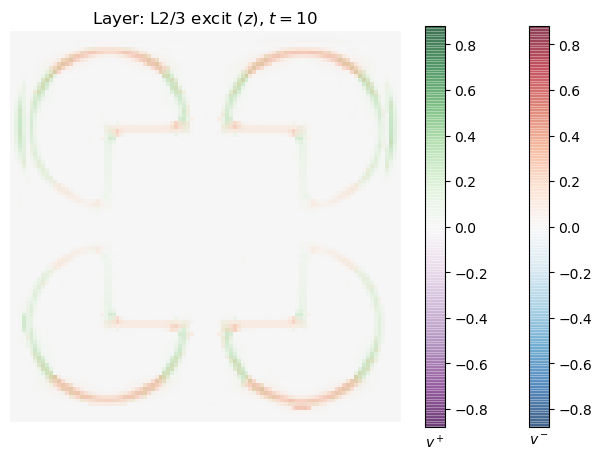

In [20]:
@benchmark begin
    t=10
    v0 = @view sol(t)[:,:,:,1]
					axMax = findmax(v0)[1]
					k=7
t=10
					fig, ax = plt.subplots()
					v1 = @view sol(t)[:,:,k,1]
					v2 = @view sol(t)[:,:,k+1,1]
					im = ax.imshow(sol.t, v1, cmap=matplotlib.cm.PRGn,
								   vmax=axMax, vmin=-axMax)
					im2 = ax.imshow(sol.t, v2, cmap=matplotlib.cm.RdBu_r,
								   vmax=axMax, vmin=-axMax, alpha=0.5)


end

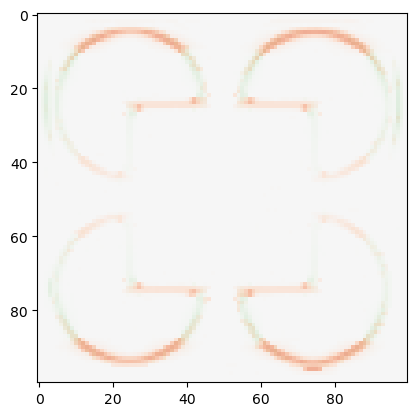

BenchmarkTools.Trial: 
  memory estimate:  2.76 MiB
  allocs estimate:  80396
  --------------
  minimum time:     265.121 ms (0.00% GC)
  median time:      267.017 ms (0.00% GC)
  mean time:        267.274 ms (0.00% GC)
  maximum time:     271.096 ms (0.00% GC)
  --------------
  samples:          19
  evals/sample:     1

In [28]:
t=10
v0 = @view sol(t)[:,:,:,1]
					axMax = findmax(v0)[1]
					k=7

					fig, ax = plt.subplots()
					v1 = @view sol(t)[:,:,k,1]
					v2 = @view sol(t)[:,:,k+1,1]
@benchmark begin
					im = ax.imshow(sol.t, v1, cmap=matplotlib.cm.PRGn,
								   vmax=axMax, vmin=-axMax, alpha=0.7)
					im2 = ax.imshow(sol.t, v2, cmap=matplotlib.cm.RdBu_r,
								   vmax=axMax, vmin=-axMax, alpha=0.7)
end
# 					cbar = fig.colorbar(im2,  shrink=0.9, ax=ax)
# 					cbar.ax.set_xlabel("\$v^-\$")
# 							cbar = fig.colorbar(im,  shrink=0.9, ax=ax)
# 					cbar.ax.set_xlabel("\$v^+\$")

# 					layer=Utils.layers[k]
# 						plt.title("Layer: $layer, \$t=$t\$")
# 						plt.axis("off")
# 						fig.tight_layout()

In [ ]:
t=10
v0 = @view sol(t)[:,:,:,1]
					axMax = findmax(v0)[1]
					k=7

					fig, ax = plt.subplots()
					v1 = @view sol(t)[:,:,k,1]
					v2 = @view sol(t)[:,:,k+1,1]
@benchmark begin
    v6 = @view sol.t[:]
					im = ax.imshow(sol.t, v1, cmap=matplotlib.cm.PRGn,
								   vmax=axMax, vmin=-axMax, alpha=0.7)
					im2 = ax.imshow(sol.t, v2, cmap=matplotlib.cm.RdBu_r,
								   vmax=axMax, vmin=-axMax, alpha=0.7)
end
# 					cbar = fig.colorbar(im2,  shrink=0.9, ax=ax)
# 					cbar.ax.set_xlabel("\$v^-\$")
# 							cbar = fig.colorbar(im,  shrink=0.9, ax=ax)
# 					cbar.ax.set_xlabel("\$v^+\$")

# 					layer=Utils.layers[k]
# 						plt.title("Layer: $layer, \$t=$t\$")
# 						plt.axis("off")
# 						fig.tight_layout()

In [32]:
sol.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  243
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          36
Number of rejected steps:                          4

In [33]:
sol.alg

Tsit5()

In [21]:
readdir(datadir("img"))

25-element Array{String,1}:
 ".ipynb_checkpoints"
 "Iine_gap_1_100_gs.png"
 "Iine_gap_2_100_gs.png"
 "Iine_gap_3_100_gs.png"
 "Iine_gap_4_100_gs.png"
 "Iines_gaps_100_gs.png"
 "diag_dots_100_gs.png"
 "diag_gap_100_gs.png"
 "kan_sq_cont.png"
 "kan_sq_cont_l.png"
 "mo05709.png"
 "stairs_100gs.png"
 "stairs_200gs.png"
 "viper00187.png"
 "viper00661.jpg"
 "viper00715.png"
 "viper00717.png"
 "viper00720.png"
 "viper00721.png"
 "viper00842.jpg"
 "viper00891.jpg"
 "viper00904.jpg"
 "viper00921.jpg"
 "viper01006.jpg"
 "viper01333.jpg"

In [22]:
sol = nothing
u0=nothing
arr1 = nothing
f=nothing
arr2=nothing

In [23]:
run(nvidia-smi)

UndefVarError: UndefVarError: nvidia not defined

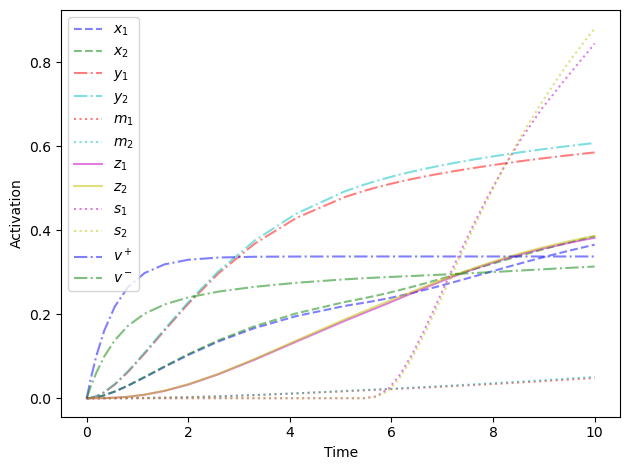

In [36]:
        fig, axs = plt.subplots()

        for k ∈ 1:12
            v3 = @view sol[:, :, k, 1, end]
            v4 = @view sol[findmax(v3)[2][1], findmax(v3)[2][2], k, 1, :]
            layer = Utils.layers_1[k]
            axs.plot(sol.t, v4, Utils.lines[k], label = "$layer", alpha=0.5)
        end
        axs.set_xlabel("Time")
        axs.set_ylabel("Activation")
        plt.legend()
        fig.tight_layout()
#         plt.savefig(plotsdir(
#             string("illusions", batch_),
#             string(file, "_time.png"),
#         ))